В цьому ноутбуці ми проведемо дослідницький аналіз даних про історичні платежі по кредитам клієнтами.

[Опис колонок в даних тут.](https://drive.google.com/file/d/1Yp2aOdC33QFAVfTyxav_gKGwi4M9VN1Z/view?usp=sharing)

Цільова змінна TARGET тут має наступне значення: 1 – клієнт із труднощами з оплатою: він/вона прострочив платіж понад X днів принаймні одного з перших Y платежів кредиту в нашій вибірці, 0 – усі інші випадки

Задача - виявити, яким клієнтам видавати кредит, а яким - не варто, бо вони з високою імовірністю його не повернуть.

Дані взяті з [Kaggle](https://www.kaggle.com/datasets/gauravduttakiit/loan-defaulter). Прошу використовувати саме ті, які надані в нашому курсі, аби нам бути впевненими, що ми точно працюємо з одними і тими ж даними.

# Імпорт необхідних бібліотек

In [310]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max.rows',130)
pd.set_option('display.max.columns',130)
pd.set_option('float_format', '{:.2f}'.format)

# Імпорт даних

Вмонтуємо наш диск, якщо Ви працюєте в Google Colab. Якщо працюєте локально, пропустіть наступну клітинку.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Знайдемо, де лежать наші файли з даними. В мене вони знаходяться тут:

In [5]:
!ls drive/MyDrive/Machine\ Learning\ для\ людей/data/credit

application_data.csv.zip	columns_description.csv		previous_application.csv.zip
application_data_processed.zip	columns_description.csv.gsheet


Якщо треба зчитати опис, то робимо це аналогічно.

In [319]:
descr = pd.read_csv("drive/MyDrive/Machine Learning для людей/data/credit/columns_description.csv")

In [320]:
descr.loc[1].Description

'Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)'

Зчитуємо дані.

In [321]:
df = pd.read_csv("drive/MyDrive/Machine Learning для людей/data/credit/application_data.csv.zip")

In [322]:
# Огляд декількох записів з датафрейму
df.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0         202500.00   406597.50     24700.50   
1               N             0         270000.00  1293502.50     35698.50   
2               Y             0          67500.00   135000.00      6750.00   
3               Y             0         135000.00   312682.50     29686.50   
4               Y             0         121500.00   513000.00     21865.50   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0        351000.00   Unaccompanied          Working   
1       1129500.00          Family    State servant   
2        135000.00   Unaccompanied          Working   
3        297000.00   Unaccompanied          Working   
4        513000.00   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                        0.02       -9461           -637           -3648.00   
1                        0.00      -16765          -1188           -1186.00   
2                        0.01      -19046           -225           -4260.00   
3                        0.01      -19005          -3039           -9833.00   
4                        0.03      -19932          -3038           -4311.00   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531        26.00           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers             1.00   
1                 1           1           0      Core staff             2.00   
2                 1           1           0        Laborers             1.00   
3                 1           0           0        Laborers             2.00   
4                 1           0           0      Core staff             1.00   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

# Перевірка структури даних

In [323]:
df.info(verbose = True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Non-Null Count   Dtype  
---   ------                        --------------   -----  
 0    SK_ID_CURR                    307511 non-null  int64  
 1    TARGET                        307511 non-null  int64  
 2    NAME_CONTRACT_TYPE            307511 non-null  object 
 3    CODE_GENDER                   307511 non-null  object 
 4    FLAG_OWN_CAR                  307511 non-null  object 
 5    FLAG_OWN_REALTY               307511 non-null  object 
 6    CNT_CHILDREN                  307511 non-null  int64  
 7    AMT_INCOME_TOTAL              307511 non-null  float64
 8    AMT_CREDIT                    307511 non-null  float64
 9    AMT_ANNUITY                   307499 non-null  float64
 10   AMT_GOODS_PRICE               307233 non-null  float64
 11   NAME_TYPE_SUITE               306219 non-null  object 
 12   NAME_INCOME_TYPE            

In [324]:
df.shape

(307511, 122)

Маємо ~307k рядків та 122 колонки.

## Статистичний звіт для числових змінних

In [325]:
df.describe()

SK_ID_CURR    TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
count   307511.00 307511.00     307511.00         307511.00   307511.00   
mean    278180.52      0.08          0.42         168797.92   599026.00   
std     102790.18      0.27          0.72         237123.15   402490.78   
min     100002.00      0.00          0.00          25650.00    45000.00   
25%     189145.50      0.00          0.00         112500.00   270000.00   
50%     278202.00      0.00          0.00         147150.00   513531.00   
75%     367142.50      0.00          1.00         202500.00   808650.00   
max     456255.00      1.00         19.00      117000000.00  4050000.00   

       AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
count    307499.00        307233.00                   307511.00   307511.00   
mean      27108.57        538396.21                        0.02   -16037.00   
std       14493.74        369446.46                        0.01     4363.99   
min        1615.50         40500.00                        0.00   -25229.00   
25%       16524.00        238500.00                        0.01   -19682.00   
50%       24903.00        450000.00                        0.02   -15750.00   
75%       34596.00        679500.00                        0.03   -12413.00   
max      258025.50       4050000.00                        0.07    -7489.00   

       DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
count      307511.00          307511.00        307511.00    104582.00   
mean        63815.05           -4986.12         -2994.20        12.06   
std        141275.77            3522.89          1509.45        11.94   
min        -17912.00          -24672.00         -7197.00         0.00   
25%         -2760.00           -7479.50         -4299.00         5.00   
50%         -1213.00           -4504.00         -3254.00         9.00   
75%          -289.00           -2010.00         -1720.00        15.00   
max        365243.00               0.00             0.00        91.00   

       FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
count   307511.00       307511.00        307511.00         307511.00   
mean         1.00            0.82             0.20              1.00   
std          0.00            0.38             0.40              0.04   
min          0.00            0.00             0.00              0.00   
25%          1.00            1.00             0.00              1.00   
50%          1.00            1.00             0.00              1.00   
75%          1.00            1.00             0.00              1.00   
max          1.00            1.00             1.00              1.00   

       FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
count   307511.00   307511.00        307509.00             307511.00   
mean         0.28        0.06             2.15                  2.05   
std          0.45        0.23             0.91                  0.51   
min          0.00        0.00             1.00                  1.00   
25%          0.00        0.00             2.00                  2.00   
50%          0.00        0.00             2.00                  2.00   
75%          1.00        0.00             3.00                  2.00   
max          1.00        1.00            20.00                  3.00   

       REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
count                    307511.00                307511.00   
mean                          2.03                    12.06   
std                           0.50                     3.27   
min                           1.00                     0.00   
25%                           2.00                    10.00   
50%                           2.00                    12.00   
75%                           2.00                    14.00   
max                           3.00                    23.00   

       REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
count                   307511

# Аналіз категоріальних змінних

In [326]:
df.select_dtypes(include = "object").columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

In [327]:
# Перевірка кількості категоріальних змінних
len(df.select_dtypes(include = "object").columns)

16

Дані містять 16 `categorical` змінних

# Аналіз числових змінних

In [328]:
number_df = df.select_dtypes(include="number")

In [329]:
number_df.columns

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=106)

In [330]:
# Перевірка кількості числових змінних
len(number_df.columns)

106

Дані міятять 106 `numerical` змінних

In [331]:
number_df.head()

SK_ID_CURR  TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0      100002       1             0         202500.00   406597.50   
1      100003       0             0         270000.00  1293502.50   
2      100004       0             0          67500.00   135000.00   
3      100006       0             0         135000.00   312682.50   
4      100007       0             0         121500.00   513000.00   

   AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0     24700.50        351000.00                        0.02       -9461   
1     35698.50       1129500.00                        0.00      -16765   
2      6750.00        135000.00                        0.01      -19046   
3     29686.50        297000.00                        0.01      -19005   
4     21865.50        513000.00                        0.03      -19932   

   DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
0           -637           -3648.00            -2120          NaN           1   
1          -1188           -1186.00             -291          NaN           1   
2           -225           -4260.00            -2531        26.00           1   
3          -3039           -9833.00            -2437          NaN           1   
4          -3038           -4311.00            -3458          NaN           1   

   FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
0               1                0                 1           1           0   
1               1                0                 1           1           0   
2               1                1                 1           1           0   
3               1                0                 1           0           0   
4               1                0                 1           0           0   

   CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0             1.00                     2                            2   
1             2.00                     1                            1   
2             1.00                     2                            2   
3             2.00                     2                            2   
4             1.00                     2                            2   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       10                           0   
1                       11                           0   
2                        9                           0   
3                       17                           0   
4                       11                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  \
0                       0                       0                        0   
1                       0                       0                        0   
2                       0                       0                        0   
3                       0                       0                        0   
4                       0                       1                        1   

   EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0          0.08          0.26          0.14            0.02              0.04   
1          0.31          0.62           NaN            0.10              0.05   
2           NaN          0.56          0.73             NaN               NaN   
3           NaN          0.65           NaN             NaN               NaN   
4           NaN          0.32           NaN             NaN               NaN   

   YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COM

# Робота з некоректними типами даних

Перевірка, чи немає у нас стовпця з неправильним типом даних

In [332]:
df.dtypes

SK_ID_CURR                        int64
TARGET                            int64
NAME_CONTRACT_TYPE               object
CODE_GENDER                      object
FLAG_OWN_CAR                     object
FLAG_OWN_REALTY                  object
CNT_CHILDREN                      int64
AMT_INCOME_TOTAL                float64
AMT_CREDIT                      float64
AMT_ANNUITY                     float64
AMT_GOODS_PRICE                 float64
NAME_TYPE_SUITE                  object
NAME_INCOME_TYPE                 object
NAME_EDUCATION_TYPE              object
NAME_FAMILY_STATUS               object
NAME_HOUSING_TYPE                object
REGION_POPULATION_RELATIVE      float64
DAYS_BIRTH                        int64
DAYS_EMPLOYED                     int64
DAYS_REGISTRATION               float64
DAYS_ID_PUBLISH                   int64
OWN_CAR_AGE                     float64
FLAG_MOBIL                        int64
FLAG_EMP_PHONE                    int64
FLAG_WORK_PHONE                   int64
FLAG_CONT_MOBILE                  int64
FLAG_PHONE                        int64
FLAG_EMAIL                        int64
OCCUPATION_TYPE                  object
CNT_FAM_MEMBERS                 float64
REGION_RATING_CLIENT              int64
REGION_RATING_CLIENT_W_CITY       int64
WEEKDAY_APPR_PROCESS_START       object
HOUR_APPR_PROCESS_START           int64
REG_REGION_NOT_LIVE_REGION        int64
REG_REGION_NOT_WORK_REGION        int64
LIVE_REGION_NOT_WORK_REGION       int64
REG_CITY_NOT_LIVE_CITY            int64
REG_CITY_NOT_WORK_CITY            int64
LIVE_CITY_NOT_WORK_CITY           int64
ORGANIZATION_TYPE                object
EXT_SOURCE_1                    float64
EXT_SOURCE_2                    float64
EXT_SOURCE_3                    float64
APARTMENTS_AVG                  float64
BASEMENTAREA_AVG                float64
YEARS_BEGINEXPLUATATION_AVG     float64
YEARS_BUILD_AVG                 float64
COMMONAREA_AVG                  float64
ELEVATORS_AVG                   float64
ENTRANCES_AVG                   float64
FLOORSMAX_AVG                   float64
FLOORSMIN_AVG                   float64
LANDAREA_AVG                    float64
LIVINGAPARTMENTS_AVG            float64
LIVINGAREA_AVG                  float64
NONLIVINGAPARTMENTS_AVG         float64
NONLIVINGAREA_AVG               float64
APARTMENTS_MODE                 float64
BASEMENTAREA_MODE               float64
YEARS_BEGINEXPLUATATION_MODE    float64
YEARS_BUILD_MODE                float64
COMMONAREA_MODE                 float64
ELEVATORS_MODE                  float64
ENTRANCES_MODE                  float64
FLOORSMAX_MODE                  float64
FLOORSMIN_MODE                  float64
LANDAREA_MODE                   float64
LIVINGAPARTMENTS_MODE           float64
LIVINGAREA_MODE                 float64
NONLIVINGAPARTMENTS_MODE        float64
NONLIVINGAREA_MODE              float64
APARTMENTS_MEDI                 float64
BASEMENTAREA_MEDI               float64
YEARS_BEGINEXPLUATATION_MEDI    float64
YEARS_BUILD_MEDI                float64
COMMONAREA_MEDI                 float64
ELEVATORS_MEDI                  float64
ENTRANCES_MEDI                  float64
FLOORSMAX_MEDI                  float64
FLOORSMIN_MEDI                  float64
LANDAREA_MEDI                   float64
LIVINGAPARTMENTS_MEDI           float64
LIVINGAREA_MEDI                 float64
NONLIVINGAPARTMENTS_MEDI        float64
NONLIVINGAREA_MEDI              float64
FONDKAPREMONT_MODE               object
HOUSETYPE_MODE                   object
TOTALAREA_MODE                  float64
WALLSMATERIAL_MODE               object
EMERGENCYSTATE_MODE              object
OBS_30_CNT_SOCIAL_CIRCLE        float64
DEF_30_CNT_SOCIAL_CIRCLE        float64
OBS_60_CNT_SOCIAL_CIRCLE        float64
DEF_60_CNT_SOCIAL_CIRCLE        float64
DAYS_LAST_PHONE_CHANGE          float64
FLAG_DOCUMENT_2                   int64
FLAG_DOCUMENT_3                   int64
FLAG_DOCUMENT_4                   int64
FLAG_DOCUMENT_5                   int64


Дивлячись на дані та відповідні їм типи даних, можна змінити тип стовпчика SKU.

In [333]:
df['SK_ID_CURR'] = df['SK_ID_CURR'].astype("str")

Також ми можемо змінити всі стовпці `flag` на тип даних, який є більш економний для зберігання.

Ось скільки пам'яті в Мб займають наші дані зараз.

In [334]:
df.memory_usage().sum()/1024/1024

286.2270965576172

In [335]:
'flag' in 'SK_ID_CURR'.lower()

False

In [336]:
flag_cols = ['flag' in col.lower() for col in df.columns]

In [337]:
df[df.columns[flag_cols]].head()

FLAG_OWN_CAR FLAG_OWN_REALTY  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            N               Y           1               1                0   
1            N               N           1               1                0   
2            Y               Y           1               1                1   
3            N               Y           1               1                0   
4            N               Y           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  FLAG_DOCUMENT_2  FLAG_DOCUMENT_3  \
0                 1           1           0                0                1   
1                 1           1           0                0                1   
2                 1           1           0                0                0   
3                 1           0           0                0                1   
4                 1           0           0                0                0   

   FLAG_DOCUMENT_4  FLAG_DOCUMENT_5  FLAG_DOCUMENT_6  FLAG_DOCUMENT_7  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   FLAG_DOCUMENT_8  FLAG_DOCUMENT_9  FLAG_DOCUMENT_10  FLAG_DOCUMENT_11  \
0                0                0                 0                 0   
1                0                0                 0                 0   
2                0                0                 0                 0   
3                0                0                 0                 0   
4                1                0                 0                 0   

   FLAG_DOCUMENT_12  FLAG_DOCUMENT_13  FLAG_DOCUMENT_14  FLAG_DOCUMENT_15  \
0                 0                 0                 0                 0   
1                 0                 0                 0                 0   
2                 0                 0                 0                 0   
3                 0                 0                 0                 0   
4                 0                 0                 0                 0   

   FLAG_DOCUMENT_16  FLAG_DOCUMENT_17  FLAG_DOCUMENT_18  FLAG_DOCUMENT_19  \
0                 0                 0                 0                 0   
1                 0                 0                 0                 0   
2                 0                 0                 0                 0   
3                 0                 0                 0                 0   
4                 0                 0                 0                 0   

   FLAG_DOCUMENT_20  FLAG_DOCUMENT_21  
0                 0                 0  
1                 0                 0  
2                 0                 0  
3                 0                 0  
4                 0                 0

In [338]:
df[df.columns[flag_cols]].nunique()

FLAG_OWN_CAR        2
FLAG_OWN_REALTY     2
FLAG_MOBIL          2
FLAG_EMP_PHONE      2
FLAG_WORK_PHONE     2
FLAG_CONT_MOBILE    2
FLAG_PHONE          2
FLAG_EMAIL          2
FLAG_DOCUMENT_2     2
FLAG_DOCUMENT_3     2
FLAG_DOCUMENT_4     2
FLAG_DOCUMENT_5     2
FLAG_DOCUMENT_6     2
FLAG_DOCUMENT_7     2
FLAG_DOCUMENT_8     2
FLAG_DOCUMENT_9     2
FLAG_DOCUMENT_10    2
FLAG_DOCUMENT_11    2
FLAG_DOCUMENT_12    2
FLAG_DOCUMENT_13    2
FLAG_DOCUMENT_14    2
FLAG_DOCUMENT_15    2
FLAG_DOCUMENT_16    2
FLAG_DOCUMENT_17    2
FLAG_DOCUMENT_18    2
FLAG_DOCUMENT_19    2
FLAG_DOCUMENT_20    2
FLAG_DOCUMENT_21    2
dtype: int64

Типи даних в pandas взяті з numpy, і ось тут список всіх типів даних в numpy:

https://numpy.org/doc/stable/user/basics.types.html

Кожен тип даних займає певну кількість байт у пам'яті. Давайте з'ясуємо, скільки займає 1 тип int8 та 1 тип int64 і скільки пам'яті ми заощадимо, якщо змінимо тип.

In [339]:
import numpy as np
from sys import getsizeof

In [340]:
getsizeof(np.int64(1))

32

In [341]:
getsizeof(np.int8(1))

25

In [342]:
7 * df.shape[0] * sum(flag_cols) / 1024 / 1024

57.48000717163086

Отже, ми можемо потенційно заощадити 57 Мб пам'яті! І трансформувати наш фрейм даних буде простіше. Давайте змінимо тип.


In [343]:
str_flag_cols = ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

In [344]:
for col in str_flag_cols:
  df[col] = np.where(df[col]=='Y', 1, 0)

In [345]:
df[str_flag_cols].nunique()

FLAG_OWN_CAR       2
FLAG_OWN_REALTY    2
dtype: int64

In [346]:
df.columns[flag_cols]

Index(['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4',
       'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7',
       'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10',
       'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13',
       'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
       'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19',
       'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21'],
      dtype='object')

In [347]:
df[df.columns[flag_cols]] = df[df.columns[flag_cols]].astype('int8')

In [348]:
df.memory_usage().sum()/1024/1024

228.74708938598633

# Робота з пропущеними значеннями

Найпростіше емпіричне правило для опрацювання пропущених значень: якщо пропущених значень більше за 40% - видаляємо колонку, якщо менше за 40% - аналізуємо, як можна заповнити і чи треба.

Зазвичай, якщо відсоток пропущених даних більший за 10 і немає чіткої (яка значно виділяється) моди (найчастішого) значення в даних, то лишаємо дані як є до використання методів машинного навчання. Далі якщо метод вимагає заповення пропущених значень, можемо експериментувати із заповеннями. Також хорошою практикою є створити окрему колонку-флаг (0/1), яка вказує, де були пропущені значення - це буде додаткова ознака для моделі.


Перевіримо, чи немає null-значень в нашому наборі даних

In [349]:
df.isnull().values.any()

True

Порахуємо загальну кількість null-значень в наборі даних

In [350]:
df.isnull().values.sum()

9152465

Сформуємо список із стовпців з null-значеннями

In [351]:
df.columns[df.isnull().any()]

Index(['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'OWN_CAR_AGE',
       'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
       'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG',
       'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG',
       'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG',
       'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE',
       'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE',
       'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE',
       'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE',
       'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE',
       'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI',
       'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI',
       'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMI

In [352]:
len(df.columns[df.isnull().any()])

67

Усього `67` стовпців мають одне або більше NULL-значень в даних

## Кількість та відсоток пропущених значень у стовпцях

In [353]:
null_count = df.isnull().sum()
null_percentage = round((df.isnull().sum()/df.shape[0])*100, 2)

In [354]:
df.shape[0]

307511

In [355]:
null_df = pd.DataFrame({'column_name' : df.columns,'null_count' : null_count,'null_percentage': null_percentage})
null_df.reset_index(drop = True, inplace = True)

In [356]:
null_df.sort_values(by = 'null_percentage', ascending = False)

column_name  null_count  null_percentage
76                COMMONAREA_MEDI      214865            69.87
48                 COMMONAREA_AVG      214865            69.87
62                COMMONAREA_MODE      214865            69.87
70       NONLIVINGAPARTMENTS_MODE      213514            69.43
56        NONLIVINGAPARTMENTS_AVG      213514            69.43
84       NONLIVINGAPARTMENTS_MEDI      213514            69.43
86             FONDKAPREMONT_MODE      210295            68.39
68          LIVINGAPARTMENTS_MODE      210199            68.35
54           LIVINGAPARTMENTS_AVG      210199            68.35
82          LIVINGAPARTMENTS_MEDI      210199            68.35
52                  FLOORSMIN_AVG      208642            67.85
66                 FLOORSMIN_MODE      208642            67.85
80                 FLOORSMIN_MEDI      208642            67.85
75               YEARS_BUILD_MEDI      204488            66.50
61               YEARS_BUILD_MODE      204488            66.50
47                YEARS_BUILD_AVG      204488            66.50
21                    OWN_CAR_AGE      202929            65.99
81                  LANDAREA_MEDI      182590            59.38
67                  LANDAREA_MODE      182590            59.38
53                   LANDAREA_AVG      182590            59.38
73              BASEMENTAREA_MEDI      179943            58.52
45               BASEMENTAREA_AVG      179943            58.52
59              BASEMENTAREA_MODE      179943            58.52
41                   EXT_SOURCE_1      173378            56.38
71             NONLIVINGAREA_MODE      169682            55.18
57              NONLIVINGAREA_AVG      169682            55.18
85             NONLIVINGAREA_MEDI      169682            55.18
77                 ELEVATORS_MEDI      163891            53.30
49                  ELEVATORS_AVG      163891            53.30
63                 ELEVATORS_MODE      163891            53.30
89             WALLSMATERIAL_MODE      156341            50.84
72                APARTMENTS_MEDI      156061            50.75
44                 APARTMENTS_AVG      156061            50.75
58                APARTMENTS_MODE      156061            50.75
78                 ENTRANCES_MEDI      154828            50.35
50                  ENTRANCES_AVG      154828            50.35
64                 ENTRANCES_MODE      154828            50.35
55                 LIVINGAREA_AVG      154350            50.19
69                LIVINGAREA_MODE      154350            50.19
83                LIVINGAREA_MEDI      154350            50.19
87                 HOUSETYPE_MODE      154297            50.18
65                 FLOORSMAX_MODE      153020            49.76
79                 FLOORSMAX_MEDI      153020            49.76
51                  FLOORSMAX_AVG      153020            49.76
60   YEARS_BEGINEXPLUATATION_MODE      150007            48.78
74   YEARS_BEGINEXPLUATATION_MEDI      150007            48.78
46    YEARS_BEGINEXPLUATATION_AVG      150007            48.78
88                 TOTALAREA_MODE      148431            48.27
90            EMERGENCYSTATE_MODE      145755            47.40
28                OCCUPATION_TYPE       96391            31.35
43                   EXT_SOURCE_3       60965            19.83
116    AMT_REQ_CREDIT_BUREAU_HOUR       41519            13.50
117     AMT_REQ_CREDIT_BUREAU_DAY       41519            13.50
118    AMT_REQ_CREDIT_BUREAU_WEEK       41519            13.50
119     AMT_REQ_CREDIT_BUREAU_MON       41519            13.50
120     AMT_REQ_CREDIT_BUREAU_QRT       41519            13.50
121    AMT_REQ_CREDIT_BUREAU_YEAR       41519            13.50
11                NAME_TYPE_SUITE        1292             0.42
92       DEF_30_CNT_SOCIAL_CIRCLE        1021             0.33
91       OBS_30_CNT_SOCIAL_CIRCLE        1021             0.33
93       OBS_60_CNT_SOCIAL_CIRCLE        1021             0.33
94       DEF_60_CNT_SOCIAL_CIRCLE        1021             0.33
42                   EXT_SOURCE_2         660        

## Видалення стовпців з NULL значеннями > 40%

Сформуємо список стовпців з NULL значеннями > 40% у список. Ми видалимо ці стовпці з датафрейму, оскільки в них занадто багато пропущених значень.

In [357]:
columns_to_be_deleted = null_df[null_df['null_percentage'] > 40].column_name.to_list()

In [358]:
len(columns_to_be_deleted)

49

Всього потрібно видалити `49` стовпців. Видалення їх з основного датафрейму **`df`**

In [359]:
df.drop(columns = columns_to_be_deleted, inplace = True)

Перевірка підрахунку стовпців після видалення. Мало б залишитись лише `73` стовпці

In [360]:
df.shape

(307511, 73)

## Перевірка стовпців з NULL значеннями < 40%

Створення датафрейму `null_df_under40` зі стовпцями, де відсоток пропущених значеннь менше 40%

In [361]:
null_df_under40 = null_df[null_df['null_percentage'] < 40]

In [362]:
null_df_under40.sort_values(by = 'null_percentage', ascending = False)

column_name  null_count  null_percentage
28               OCCUPATION_TYPE       96391            31.35
43                  EXT_SOURCE_3       60965            19.83
121   AMT_REQ_CREDIT_BUREAU_YEAR       41519            13.50
120    AMT_REQ_CREDIT_BUREAU_QRT       41519            13.50
119    AMT_REQ_CREDIT_BUREAU_MON       41519            13.50
118   AMT_REQ_CREDIT_BUREAU_WEEK       41519            13.50
117    AMT_REQ_CREDIT_BUREAU_DAY       41519            13.50
116   AMT_REQ_CREDIT_BUREAU_HOUR       41519            13.50
11               NAME_TYPE_SUITE        1292             0.42
91      OBS_30_CNT_SOCIAL_CIRCLE        1021             0.33
92      DEF_30_CNT_SOCIAL_CIRCLE        1021             0.33
93      OBS_60_CNT_SOCIAL_CIRCLE        1021             0.33
94      DEF_60_CNT_SOCIAL_CIRCLE        1021             0.33
42                  EXT_SOURCE_2         660             0.21
10               AMT_GOODS_PRICE         278             0.09
101              FLAG_DOCUMENT_7           0             0.00
95        DAYS_LAST_PHONE_CHANGE           1             0.00
96               FLAG_DOCUMENT_2           0             0.00
97               FLAG_DOCUMENT_3           0             0.00
98               FLAG_DOCUMENT_4           0             0.00
99               FLAG_DOCUMENT_5           0             0.00
100              FLAG_DOCUMENT_6           0             0.00
105             FLAG_DOCUMENT_11           0             0.00
102              FLAG_DOCUMENT_8           0             0.00
103              FLAG_DOCUMENT_9           0             0.00
104             FLAG_DOCUMENT_10           0             0.00
39       LIVE_CITY_NOT_WORK_CITY           0             0.00
106             FLAG_DOCUMENT_12           0             0.00
107             FLAG_DOCUMENT_13           0             0.00
108             FLAG_DOCUMENT_14           0             0.00
109             FLAG_DOCUMENT_15           0             0.00
110             FLAG_DOCUMENT_16           0             0.00
111             FLAG_DOCUMENT_17           0             0.00
112             FLAG_DOCUMENT_18           0             0.00
113             FLAG_DOCUMENT_19           0             0.00
114             FLAG_DOCUMENT_20           0             0.00
115             FLAG_DOCUMENT_21           0             0.00
40             ORGANIZATION_TYPE           0             0.00
0                     SK_ID_CURR           0             0.00
38        REG_CITY_NOT_WORK_CITY           0             0.00
9                    AMT_ANNUITY          12             0.00
17                    DAYS_BIRTH           0             0.00
16    REGION_POPULATION_RELATIVE           0             0.00
15             NAME_HOUSING_TYPE           0             0.00
14            NAME_FAMILY_STATUS           0             0.00
13           NAME_EDUCATION_TYPE           0             0.00
12              NAME_INCOME_TYPE           0             0.00
8                     AMT_CREDIT           0             0.00
1                         TARGET           0             0.00
7               AMT_INCOME_TOTAL           0             0.00
6                   CNT_CHILDREN           0             0.00
5                FLAG_OWN_REALTY           0             0.00
4                   FLAG_OWN_CAR           0             0.00
3                    CODE_GENDER           0             0.00
2             NAME_CONTRACT_TYPE           0             0.00
18                 DAYS_EMPLOYED           0             0.00
19             DAYS_REGISTRATION           0             0.00
20               DAYS_ID_PUBLISH           0             0.00
22                    FLAG_MOBIL           0             0.00
23                FLAG_EMP_PHONE           0             0.00
24               FLAG_WORK_PHONE           0             0.00
25              FLAG_CONT_MOBILE           0             0.00
26                    FLAG_PHONE           0             0.00
27                    FLAG_EMAIL           0         

Опрацюємо кожну з колонок.

### Аналіз стовпця `OCCUPATION_TYPE`

- нульові значення = 31.35%

In [363]:
df['OCCUPATION_TYPE'].value_counts()

OCCUPATION_TYPE
Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: count, dtype: int64

Заміна NULL-значень на категорією `Unknown`

In [364]:
df['OCCUPATION_TYPE'].fillna(value = 'Unknown', inplace = True)

<ipython-input-364-b67c39e84274>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['OCCUPATION_TYPE'].fillna(value = 'Unknown', inplace = True)


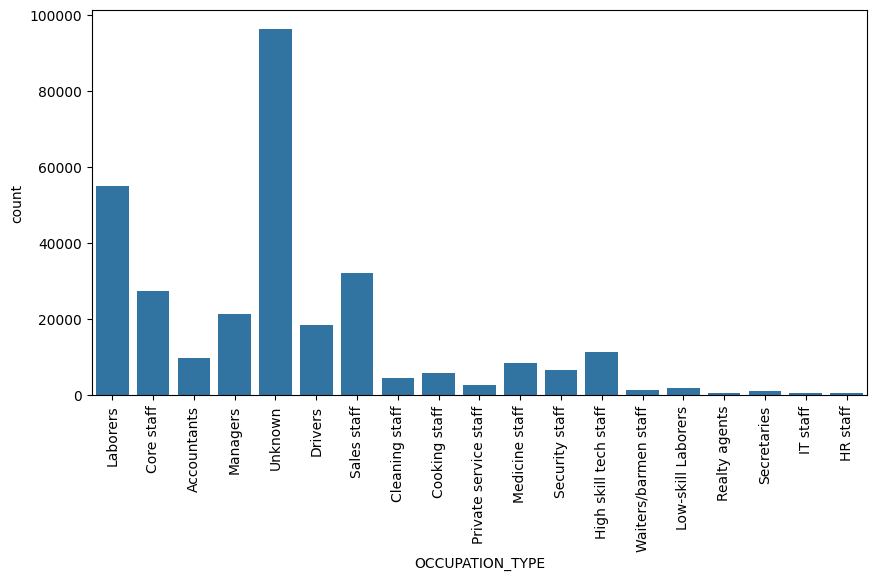

In [365]:
plt.figure(figsize = (10,5))
sns.countplot(data = df, x = "OCCUPATION_TYPE")
plt.xticks(rotation = 90)
plt.show()

**Спостереження**
- Якщо поглянути на графік, то найбільшу кількість заявників на кредит мають `Laborers`
- Для імпутації краще залишити дані як є (пропущені значення становлять 31,35%) і не проводити імпутацію за якоюсь константою, як-от мода або мін/макс медіана, якщо це числовий стовпчик, оскільки це може викривити дані в подальших розрахунках.

Існує також можливість імпутації за допомогою більш "розумних" методів, але ми вивчимо їх пізніше, а зараз ми робимо те, що можемо, за допомогою деяких найпростіших перетворень.

### Аналіз стовпця `EXT_SOURCE_3`

- пропущені значення = 19.83%

In [366]:
df.EXT_SOURCE_3.value_counts().head()

EXT_SOURCE_3
0.75    1460
0.71    1315
0.69    1276
0.67    1191
0.65    1154
Name: count, dtype: int64

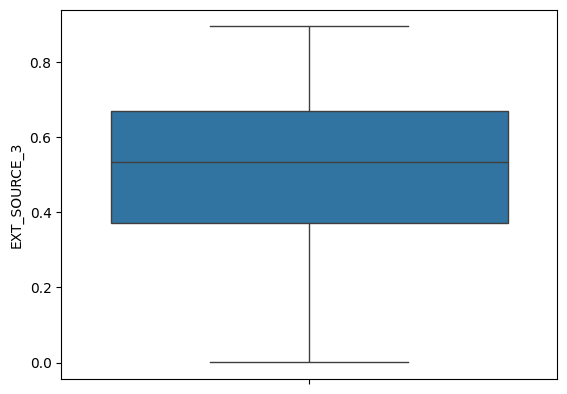

In [367]:
sns.boxplot(df.EXT_SOURCE_3)
plt.show()

Отримання процентильних значень для `EXT_SOURCE_3`

In [368]:
df.EXT_SOURCE_3.quantile(q = [0.25,0.5,0.75,1])

0.25   0.37
0.50   0.54
0.75   0.67
1.00   0.90
Name: EXT_SOURCE_3, dtype: float64

Найбільш повторюване значення в `EXT_SOURCE_3

In [369]:
df.EXT_SOURCE_3.mode()[0]

0.746300213050371

Перевірка середнього значення `EXT_SOURCE_3`

In [370]:
df.EXT_SOURCE_3.mean()

0.5108529061799658

**Спостереження**
-  Дивлячись на діагараму розмаху, медіана становить 0,535276
-  Найчастіше повторюване значення - 0,74630
-  Середнє значення - 0,51085
-  Хоча середнє та медіана є ближчими і можуть бути використані для імпутації, оскільки відсутнє відсоткове значення є більшим (19,83%), краще залишити дані як є і не проводити імпутації. Якщо метод вимагає імпутації, ми можемо імпутувати дані за допомогою медіани і створити ще один стовпчик, в якому буде позначено, які значення були імпутовані.

# ДЗ 1. Аналіз стовпців AMT_REQ_CREDIT_BUREAU з пропущеними значеннями
 Виведіть середнє, моду, медіану та відсоток для наступних колонок:


*   AMT_REQ_CREDIT_BUREAU_YEAR
*   AMT_REQ_CREDIT_BUREAU_QRT
*   AMT_REQ_CREDIT_BUREAU_MON
*   AMT_REQ_CREDIT_BUREAU_WEEK
*   AMT_REQ_CREDIT_BUREAU_DAY
*   AMT_REQ_CREDIT_BUREAU_HOUR

На основі виведених даних напишіть висновок про те, чи варто заповнювати пусті значення і якщо так, то яким чином.



# Аналіз стовпця AMT_REQ_CREDIT_BUREAU_YEAR
* Пропущенні значення 13.50%

In [371]:
df["AMT_REQ_CREDIT_BUREAU_YEAR"].value_counts()

AMT_REQ_CREDIT_BUREAU_YEAR
0.00     71801
1.00     63405
2.00     50192
3.00     33628
4.00     20714
5.00     12052
6.00      6967
7.00      3869
8.00      2127
9.00      1096
11.00       31
12.00       30
10.00       22
13.00       19
14.00       10
17.00        7
15.00        6
19.00        4
18.00        4
16.00        3
25.00        1
23.00        1
22.00        1
21.00        1
20.00        1
Name: count, dtype: int64

In [372]:
df.AMT_REQ_CREDIT_BUREAU_YEAR.mean()

1.899974435321363

In [373]:
df.AMT_REQ_CREDIT_BUREAU_YEAR.mode()

0   0.00
Name: AMT_REQ_CREDIT_BUREAU_YEAR, dtype: float64

In [374]:
df.AMT_REQ_CREDIT_BUREAU_YEAR.median()

1.0

In [375]:
df.AMT_REQ_CREDIT_BUREAU_YEAR.isnull().mean()*100

13.501630835970097

Для аналізу розподілу значень у стовпці AMT_REQ_CREDIT_BUREAU_YEAR можна побудувати кілька типів графіків, які допоможуть краще зрозуміти дані:

****Boxplot****

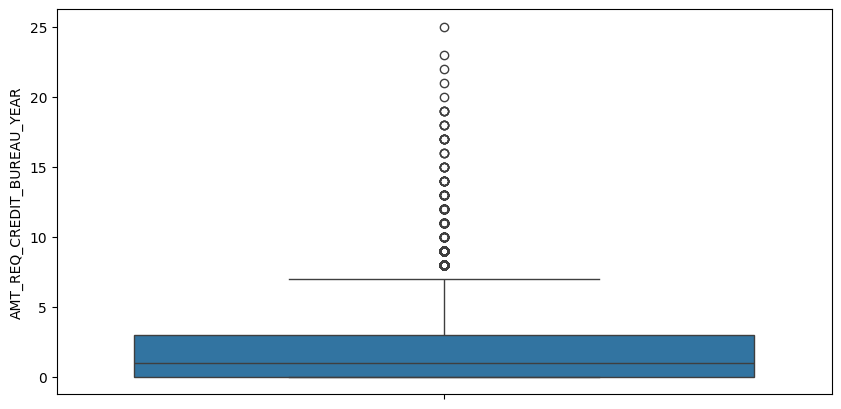

In [376]:
plt.figure(figsize = (10,5))
sns.boxplot(df.AMT_REQ_CREDIT_BUREAU_YEAR)
plt.show()

**Гістограма**




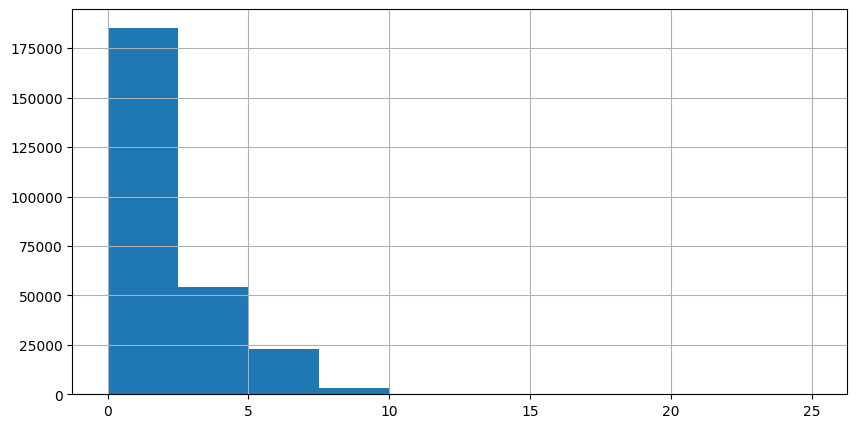

In [377]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,5))
df.AMT_REQ_CREDIT_BUREAU_YEAR.hist()
plt.show()

**Спостереження**

Дивлячись на діагараму розмаху,барплот та інші обчислення, можна побачити, що:
* середнє становить 1.9;
* мода: 0.00;
* медіана: 1.0.
* пропущені значення: 13.50% (тобто, значна частина даних відсутня, але заповнення можливо)

Значення дуже зміщені до 0(mode = 0), що означає, що більшість клієнтів не мали запиітв до кредитного бюро за рік. Також більшість значень <=3, а дуже великі значення(понад 10) є аномальними, що свідчить про спеціфічну групу клієнітів.
 У нас 13.50% пропущених значень - це частка не надто велика, але достатьо значна, щоб пропуски могли вплинути на аналіз або моделювання.

 Я вважаю, що варто провести імпутацію та заповнити пропуски залежно від цілей:
 * простий підхід - модою(0.00), оскільки вона є найчастішим значенням.
 * щоб зберегти розподіл даних - медіаною(1.0), оскільки вона краще відображає загальну тенденцію клієнтів із кількома запитами.

Отже, ми можемо імпутувати дані за допомогою моди або медіани і створити ще один стовпчик, в якому буде позначено, які значення були імпутовані.

# Аналіз стовпця AMT_REQ_CREDIT_BUREAU_QRT
* Пропущенні значення 13.50%

In [378]:
df["AMT_REQ_CREDIT_BUREAU_QRT"].value_counts()

AMT_REQ_CREDIT_BUREAU_QRT
0.00      215417
1.00       33862
2.00       14412
3.00        1717
4.00         476
5.00          64
6.00          28
8.00           7
7.00           7
261.00         1
19.00          1
Name: count, dtype: int64

In [379]:
df.AMT_REQ_CREDIT_BUREAU_QRT.mean()

0.26547414959848414

In [380]:
df.AMT_REQ_CREDIT_BUREAU_QRT.mode()

0   0.00
Name: AMT_REQ_CREDIT_BUREAU_QRT, dtype: float64

In [381]:
df.AMT_REQ_CREDIT_BUREAU_QRT.median()

0.0

In [382]:
df.AMT_REQ_CREDIT_BUREAU_QRT.isnull().mean()*100

13.501630835970097

**Barchart**

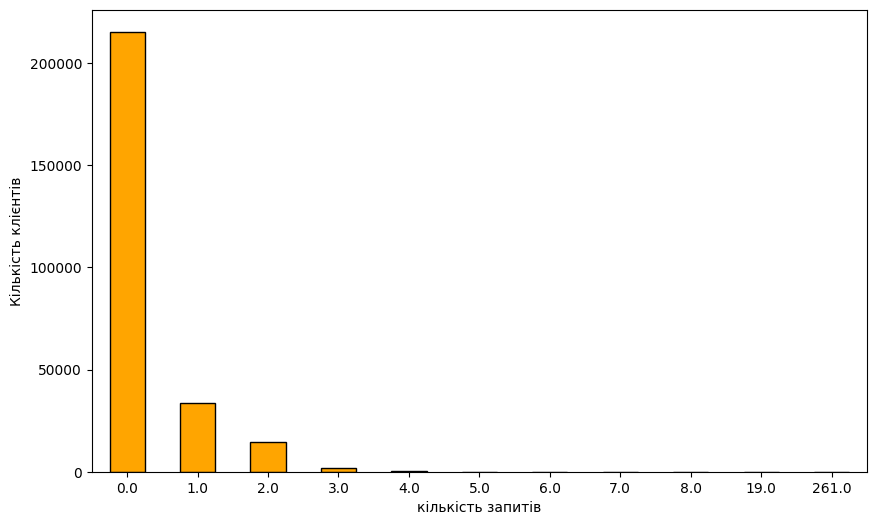

In [383]:
value_counts = df["AMT_REQ_CREDIT_BUREAU_QRT"].value_counts().sort_index()
value_counts.plot(kind="bar", figsize = (10, 6), color = "orange", edgecolor ="k")
plt.xlabel("кількість запитів")
plt.ylabel("Кількість клієнтів")
plt.xticks(rotation = 0)
plt.show()

**Спостереження**

Дивлячись на барплот та інші статистичні обчислення, можна побачити, що:
* середнє становить 0.2654;
* мода: 0.00;
* медіана:  0.00.
* пропущені значення: 13.50% (тобто, значна частина даних відсутня, але заповнення можливо)

Значення дуже зміщені до 0(mode = 0), що означає, що більшість клієнтів не мали запиітв до кредитного бюро за квартиль.

У нас 13.50% пропущених значень - це частка не надто велика, але достатьо значна, щоб пропуски могли вплинути на аналіз або моделювання.

 Я вважаю, щоб уникнути втрати даних, варто провести імпутацію, а саме, використовуючи моду(0.0), оскільки це відповідає природньому розподілу даних та дозволяє мінімазувати вплив на аналіз.Також потрібно створити ще один стовпчик, в якому буде позначено, які значення були імпутовані.


# Аналіз стовпця AMT_REQ_CREDIT_BUREAU_MON
* Пропущенні значення 13.50%

In [384]:
df["AMT_REQ_CREDIT_BUREAU_MON"].value_counts()

AMT_REQ_CREDIT_BUREAU_MON
0.00     222233
1.00      33147
2.00       5386
3.00       1991
4.00       1076
5.00        602
6.00        343
7.00        298
9.00        206
8.00        185
10.00       132
11.00       119
12.00        77
13.00        72
14.00        40
15.00        35
16.00        23
17.00        14
18.00         6
19.00         3
24.00         1
23.00         1
27.00         1
22.00         1
Name: count, dtype: int64

In [385]:
df.AMT_REQ_CREDIT_BUREAU_YEAR.mean()

1.899974435321363

In [386]:
df.AMT_REQ_CREDIT_BUREAU_YEAR.mode()

0   0.00
Name: AMT_REQ_CREDIT_BUREAU_YEAR, dtype: float64

In [387]:
df.AMT_REQ_CREDIT_BUREAU_YEAR.median()

1.0

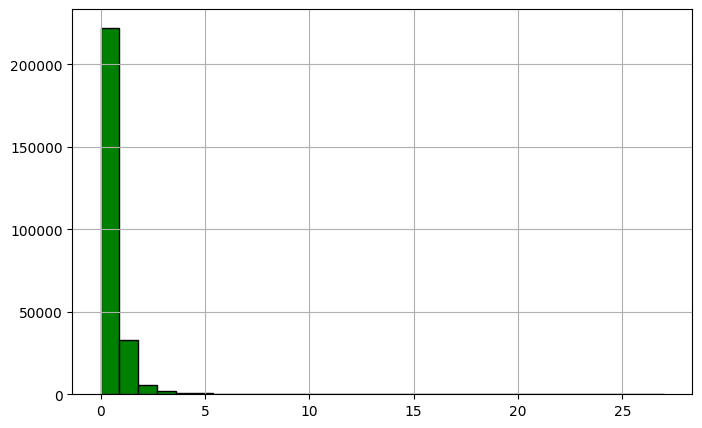

In [388]:
plt.figure(figsize=(8, 5))
df["AMT_REQ_CREDIT_BUREAU_MON"].hist(bins = 30, edgecolor = "k", color = "green")
plt.show()


**Спостереження**

Дивлячись на барплот та інші статистичні обчислення, можна побачити, що:
* середнє становить 0.8999;
* мода: 0.00;
* медіана:  1.00.
* пропущені значення: 13.50% (це частка не надто велика, але достатьо значна, щоб пропуски могли вплинути на аналіз або моделювання).

Значення дуже зміщені до 0(mode = 0), що означає, що більшість клієнтів не мали запитів до кредитного бюро протягом місяця.


 Я вважаю, щоб уникнути втрати даних, варто провести імпутацію, використовуючи моду(0.0), оскільки це відповідає природньому розподілу даних та не спотворює статистичні характеристики колонки. Також потрібно створити ще один стовпчик, в якому буде позначено, які значення були імпутовані.


# Аналіз стовпця AMT_REQ_CREDIT_BUREAU_WEEK
* Пропущенні значення 13.50%

In [389]:
df["AMT_REQ_CREDIT_BUREAU_WEEK"].value_counts()

AMT_REQ_CREDIT_BUREAU_WEEK
0.00    257456
1.00      8208
2.00       199
3.00        58
4.00        34
6.00        20
5.00        10
8.00         5
7.00         2
Name: count, dtype: int64

In [390]:
df.AMT_REQ_CREDIT_BUREAU_WEEK.mean()

0.0343619356973142

In [391]:
df.AMT_REQ_CREDIT_BUREAU_WEEK.mode()

0   0.00
Name: AMT_REQ_CREDIT_BUREAU_WEEK, dtype: float64

In [392]:
df.AMT_REQ_CREDIT_BUREAU_WEEK.median()

0.0

**Histogram**

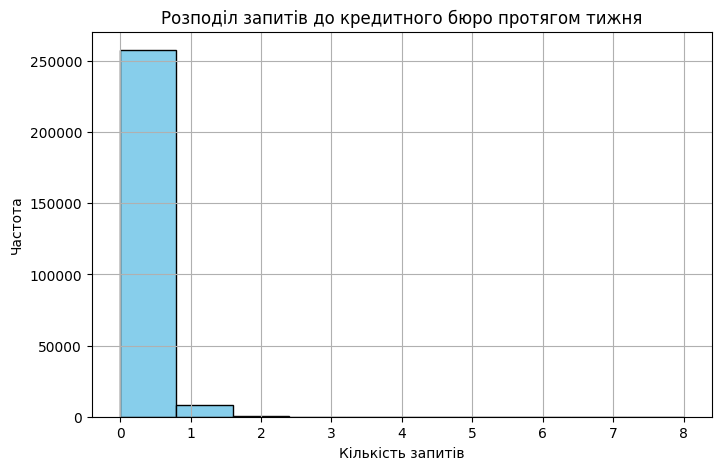

In [393]:
plt.figure(figsize = (8,5))
df["AMT_REQ_CREDIT_BUREAU_WEEK"].hist(bins= 10, edgecolor = "k", color = "skyblue")
plt.title('Розподіл запитів до кредитного бюро протягом тижня')
plt.xlabel('Кількість запитів')
plt.ylabel('Частота')
plt.show()

**Спостереження**

Дивлячись на гістограму та інші статистичні обчислення, можна побачити, що:
* середнє становить 0.03436;
* мода: 0.00;
* медіана:  0.00.
* пропущені значення: 13.50% (це частка не надто велика, але достатьо значна, щоб пропуски могли вплинути на аналіз або моделювання).

Значення дуже зміщені до 0(mode = 0), що означає, що більшість клієнтів не мали запитів до кредитного бюро протягом тижня.


 Я вважаю, щоб уникнути втрати даних, варто провести імпутацію, використовуючи моду(0.0), оскільки це зберігає характер розподілу даних, уникаючи зайвих викривлень. Також потрібно створити ще один стовпчик, в якому буде позначено, які значення були імпутовані.

# Аналіз стовпця AMT_REQ_CREDIT_BUREAU_DAY
* Пропущенні значення 13.50%

In [394]:
df["AMT_REQ_CREDIT_BUREAU_DAY"].value_counts()

AMT_REQ_CREDIT_BUREAU_DAY
0.00    264503
1.00      1292
2.00       106
3.00        45
4.00        26
5.00         9
6.00         8
9.00         2
8.00         1
Name: count, dtype: int64

In [395]:
df.AMT_REQ_CREDIT_BUREAU_DAY.mean()

0.0070002105326475985

In [396]:
df.AMT_REQ_CREDIT_BUREAU_DAY.mode()

0   0.00
Name: AMT_REQ_CREDIT_BUREAU_DAY, dtype: float64

In [397]:
df.AMT_REQ_CREDIT_BUREAU_DAY.median()

0.0

<Axes: xlabel='AMT_REQ_CREDIT_BUREAU_DAY'>

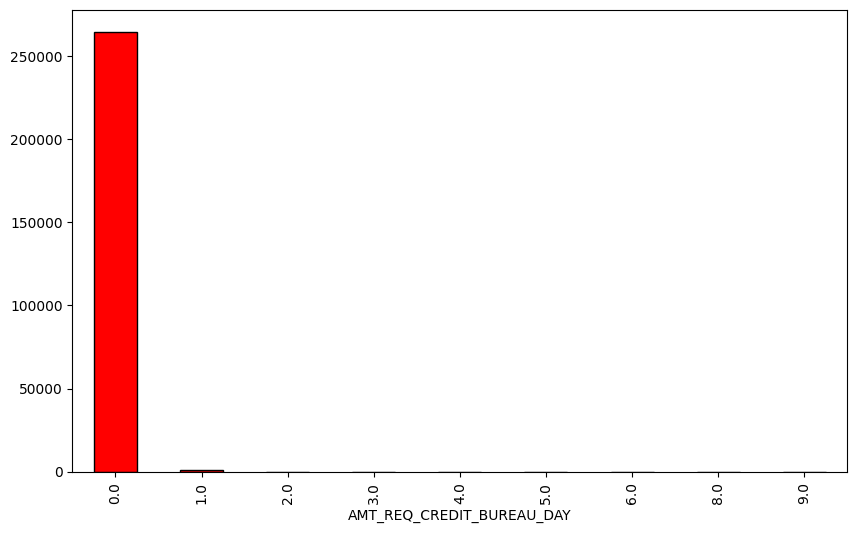

In [398]:
value_counts_1 = df["AMT_REQ_CREDIT_BUREAU_DAY"].value_counts().sort_index()
value_counts_1.plot(kind = "bar", figsize = (10, 6), color = "red", edgecolor = "k")

**Спостереження**

Дивлячись на гістограму та інші статистичні обчислення, можна побачити, що:
* середнє становить 0.007;
* мода: 0.00;
* медіана:  0.00.
* пропущені значення: 13.50% (це частка не надто велика, але достатьо значна, щоб пропуски могли вплинути на аналіз або моделювання).

Значення дуже зміщені до 0(mode = 0), що означає, що більшість клієнтів не мали запитів до кредитного бюро протягом дня.


 Я вважаю, щоб уникнути втрати даних, варто провести імпутацію, використовуючи моду(0.0), оскільки це зберігає характер розподілу даних, уникаючи зайвих викривлень. Також потрібно створити ще один стовпчик, в якому буде позначено, які значення були імпутовані.

# Аналіз стовпця AMT_REQ_CREDIT_BUREAU_HOUR
* Пропущенні значення 13.50%

In [399]:
df["AMT_REQ_CREDIT_BUREAU_HOUR"].value_counts()

AMT_REQ_CREDIT_BUREAU_HOUR
0.00    264366
1.00      1560
2.00        56
3.00         9
4.00         1
Name: count, dtype: int64

In [400]:
df.AMT_REQ_CREDIT_BUREAU_HOUR.mean()

0.006402448193930645

In [401]:
df.AMT_REQ_CREDIT_BUREAU_HOUR.mode()

0   0.00
Name: AMT_REQ_CREDIT_BUREAU_HOUR, dtype: float64

In [402]:
df.AMT_REQ_CREDIT_BUREAU_HOUR.median()

0.0

<Axes: xlabel='AMT_REQ_CREDIT_BUREAU_HOUR'>

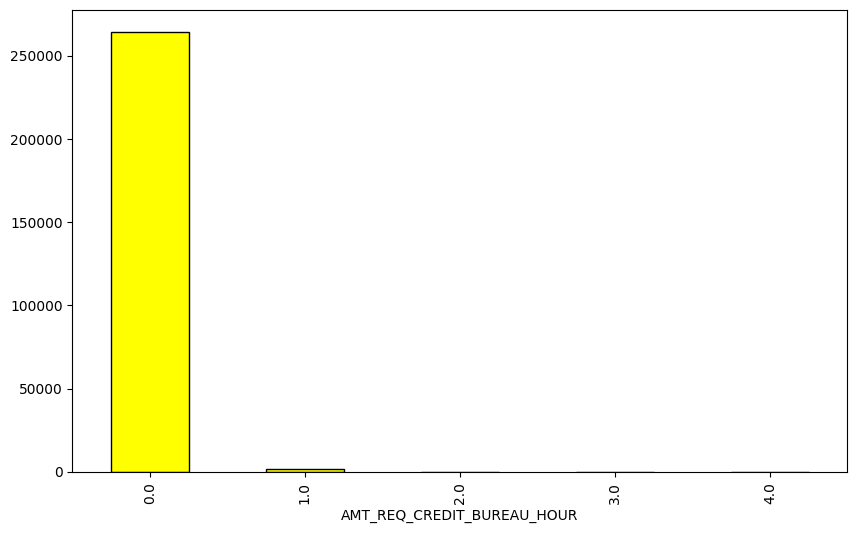

In [403]:
value_counts_1 = df["AMT_REQ_CREDIT_BUREAU_HOUR"].value_counts().sort_index()
value_counts_1.plot(kind = "bar", figsize = (10, 6), color = "yellow", edgecolor = "k")


**Спостереження**

Дивлячись на барплот та інші статистичні обчислення, можна побачити, що:
* середнє становить 0.0064;
* мода: 0.00;
* медіана:  0.00.
* пропущені значення: 13.50% (це частка не надто велика, але достатьо значна, щоб пропуски могли вплинути на аналіз або моделювання).

Значення дуже зміщені до 0(mode = 0), що означає, що більшість клієнтів не мали запитів до кредитного бюро протягом години.


 Я вважаю, щоб уникнути втрати даних, варто провести імпутацію, використовуючи моду(0.0), оскільки це зберігає характер розподілу даних, уникаючи зайвих викривлень. Також потрібно створити ще один стовпчик, в якому буде позначено, які значення були імпутовані.

## Загальний висновок
У всіх колонках, де пропущені значення становлять 13.5%, більшість значень мають 0 (не було запитів у бюро).
Найбільш доцільним методом для заповнення пропущених значень у всіх цих колонках є заповнення модою (0.0). Це дозволяє зберегти природний розподіл даних і відповідає більшості випадків.

# Перевірка стовпців зі значеннями NULL > 0% та < 1%

Створення датафрейму `null_df_under1` з відсотком пропущених значень > 0% та < 1% у кожному стовпці

In [404]:
null_df_under1 = null_df[(null_df['null_percentage'] > 0) & (null_df['null_percentage'] < 1)]

In [405]:
null_df_under1.sort_values(by = 'null_percentage', ascending = False)

column_name  null_count  null_percentage
11           NAME_TYPE_SUITE        1292             0.42
91  OBS_30_CNT_SOCIAL_CIRCLE        1021             0.33
92  DEF_30_CNT_SOCIAL_CIRCLE        1021             0.33
93  OBS_60_CNT_SOCIAL_CIRCLE        1021             0.33
94  DEF_60_CNT_SOCIAL_CIRCLE        1021             0.33
42              EXT_SOURCE_2         660             0.21
10           AMT_GOODS_PRICE         278             0.09

## Аналіз стовпця `NAME_TYPE_SUITE`

In [406]:
null_df_under1[null_df_under1.column_name == 'NAME_TYPE_SUITE']

column_name  null_count  null_percentage
11  NAME_TYPE_SUITE        1292             0.42

In [407]:
df['NAME_TYPE_SUITE'].value_counts()

NAME_TYPE_SUITE
Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: count, dtype: int64

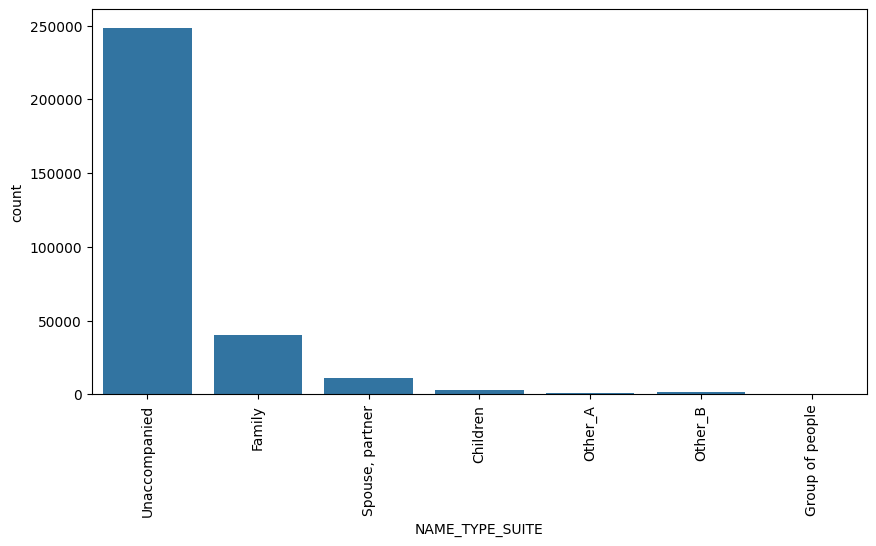

In [408]:
plt.figure(figsize = (10,5))
sns.countplot(data = df, x = "NAME_TYPE_SUITE")
plt.xticks(rotation = 90)
plt.show()

**Спостереження**
-   Дивлячись на графік, категорія `Unaccompanied` має найбільшу кількість заявників на отримання кредиту. Отже, більшість позичальників наважуються звертатися за кредитом без супроводу.
- Ми можемо продовжити імпутацію `Unaccompanied` в датафреймі, але краше надати перевагу другому варіанту.
- Ми також могли б імпутувати дані зі значенням `NA`, оскільки ця колонка є категоричною.
- Аналогічно, якщо в колонці не вистачає менше 1% даних, ми можемо її опустити. Але якщо ми вилучимо всі дані в усіх стовпчиках, де пропущено <=1% даних, ми можемо вилучити занадто багато даних. Тому я здебільшого зберігаю дані настільки, наскільки це можливо.

In [409]:
df['NAME_TYPE_SUITE'].fillna('NA', inplace=True)

<ipython-input-409-9eba76e3e9b9>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['NAME_TYPE_SUITE'].fillna('NA', inplace=True)


## Аналіз стовпця `OBS_30_CNT_SOCIAL_CIRCLE`

In [410]:
null_df_under1[null_df_under1.column_name == 'OBS_30_CNT_SOCIAL_CIRCLE']

column_name  null_count  null_percentage
91  OBS_30_CNT_SOCIAL_CIRCLE        1021             0.33

In [411]:
df.OBS_30_CNT_SOCIAL_CIRCLE.value_counts().head(10)

OBS_30_CNT_SOCIAL_CIRCLE
0.00    163910
1.00     48783
2.00     29808
3.00     20322
4.00     14143
5.00      9553
6.00      6453
7.00      4390
8.00      2967
9.00      2003
Name: count, dtype: int64

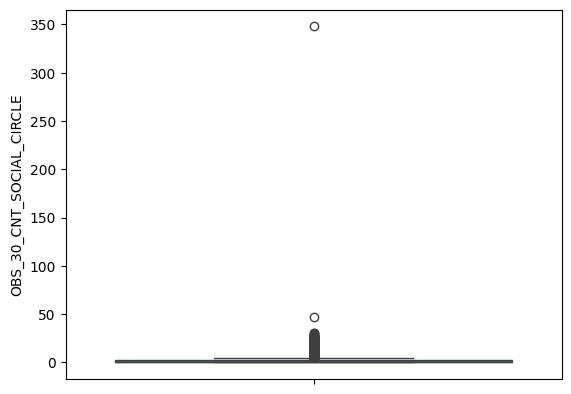

In [412]:
sns.boxplot(df.OBS_30_CNT_SOCIAL_CIRCLE)
plt.show()

Розрахунок перцентилів `OBS_30_CNT_SOCIAL_CIRCLE`

In [413]:
df.OBS_30_CNT_SOCIAL_CIRCLE.quantile(q = [0.25,0.5,0.75,1])

0.25     0.00
0.50     0.00
0.75     2.00
1.00   348.00
Name: OBS_30_CNT_SOCIAL_CIRCLE, dtype: float64

Найбільш повторюване значення в `OBS_30_CNT_SOCIAL_CIRCLE`

In [414]:
df.OBS_30_CNT_SOCIAL_CIRCLE.mode()[0]

0.0

Середнє значення `OBS_30_CNT_SOCIAL_CIRCLE`

In [415]:
df.OBS_30_CNT_SOCIAL_CIRCLE.mean()

1.4222454239942575

**Спостереження**
- Дивлячись на діаграму розмаху, медіана дорівнює 0.0
- Найчастіше повторюване значення - 0.0
- Середнє значення - 1,4222
- Є два викидні значення на рівні 50 та 350.
- Медіана і мода близькі (з огляду на діапазон даних у цьому стовпчику) і можуть бути використані для імпутації. Це не призведе до зміщення, оскільки відсоток пропущених значень невеликий (0,33%)

In [416]:
df['OBS_30_CNT_SOCIAL_CIRCLE'].fillna(df['OBS_30_CNT_SOCIAL_CIRCLE'].median(), inplace=True)

<ipython-input-416-2ec5564a2152>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['OBS_30_CNT_SOCIAL_CIRCLE'].fillna(df['OBS_30_CNT_SOCIAL_CIRCLE'].median(), inplace=True)


# ДЗ 2. Аналіз і заповнення пустих значень у колонках з малим відсотком пропущених
За прикладом вище проведіть аналіз пропущених значень в колонках:
* DEF_30_CNT_SOCIAL_CIRCLE
* EXT_SOURCE_2
* OBS_60_CNT_SOCIAL_CIRCLE
* DEF_60_CNT_SOCIAL_CIRCLE
* AMT_GOODS_PRICE

Для швидкого аналізу рекомендую написати функцію, яку ви зможете викликати для кожної з колонок.

Зробіть висновок що робити з пропущеними значеннями в кожному випадку та виконайте ту дію, яку зазначили.

# Аналіз стовпця DEF_30_CNT_SOCIAL_CIRCLE
Пропущенні значення 0.33%

In [417]:
null_df_under1[null_df_under1.column_name == 'DEF_30_CNT_SOCIAL_CIRCLE']

column_name  null_count  null_percentage
92  DEF_30_CNT_SOCIAL_CIRCLE        1021             0.33

In [418]:
df['DEF_30_CNT_SOCIAL_CIRCLE'].value_counts()

DEF_30_CNT_SOCIAL_CIRCLE
0.00     271324
1.00      28328
2.00       5323
3.00       1192
4.00        253
5.00         56
6.00         11
7.00          1
34.00         1
8.00          1
Name: count, dtype: int64

In [419]:
def analyze_the_column(df, column_name):

    mean_value = df[column_name].mean()
    median_value = df[column_name].median()
    mode_value = df[column_name].mode()[0]

    print(f"Середнє значення: {mean_value:.2f}")
    print(f"Медіана: {median_value:.2f}")
    print(f"Мода: {mode_value}")

    return mean_value, median_value, mode_value

mean_value, median_value, mode_value = analyze_the_column(df, 'DEF_30_CNT_SOCIAL_CIRCLE')


Середнє значення: 0.14
Медіана: 0.00
Мода: 0.0


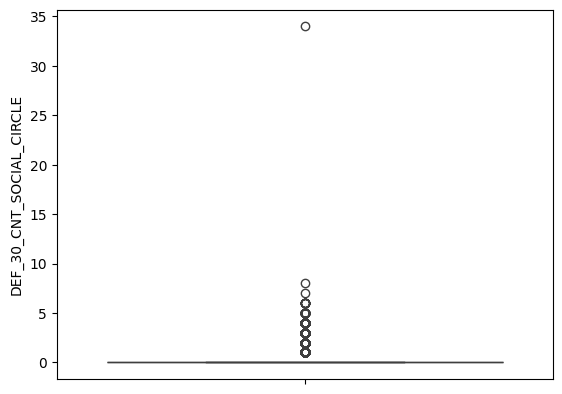

In [420]:
sns.boxplot(df.DEF_30_CNT_SOCIAL_CIRCLE)
plt.show()

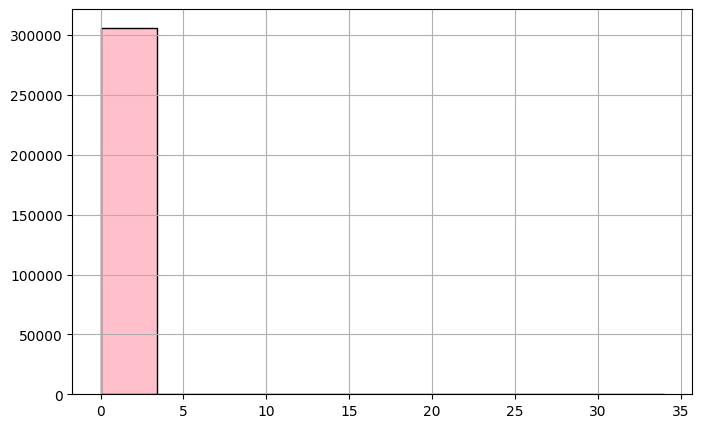

In [421]:
plt.figure(figsize = (8, 5))
df['DEF_30_CNT_SOCIAL_CIRCLE'].hist(bins = 10, edgecolor = 'k', color = 'pink')
plt.show()

In [422]:
df.DEF_30_CNT_SOCIAL_CIRCLE.quantile(q= [0.25, 0.5, 0.75, 1])

0.25    0.00
0.50    0.00
0.75    0.00
1.00   34.00
Name: DEF_30_CNT_SOCIAL_CIRCLE, dtype: float64

**Спостереження**
- Дивлячись на діаграму розмаху, медіана дорівнює 0.0
- Найчастіше повторюване значення - 0.0
- Середнє значення - 0.14
- Є декілька викидних значеннь приблизно на рівні від 1 до 9 та 34.
- Медіана і мода близькі (з огляду на діапазон даних у цьому стовпчику) і можуть бути використані для імпутації. Це не призведе до зміщення, оскільки відсоток пропущених значень невеликий (0,33%).

In [423]:
df.fillna({"DEF_30_CNT_SOCIAL_CIRCLE": median_value}, inplace = True)

# Аналіз стовпця EXT_SOURCE_2
Пропущенні значення 0.21%

In [424]:
null_df_under1[null_df_under1.column_name == 'EXT_SOURCE_2']

column_name  null_count  null_percentage
42  EXT_SOURCE_2         660             0.21

In [425]:
df['EXT_SOURCE_2'].value_counts()

EXT_SOURCE_2
0.29    721
0.26    417
0.27    343
0.16    322
0.27    306
       ... 
0.00      1
0.26      1
0.28      1
0.18      1
0.27      1
Name: count, Length: 119831, dtype: int64

In [426]:
def analyze_the_column(df, column_name):

    mean_value = df[column_name].mean()
    median_value = df[column_name].median()
    mode_value = df[column_name].mode()[0]

    print(f"Середнє значення: {mean_value:.2f}")
    print(f"Медіана: {median_value:.2f}")
    print(f"Мода: {mode_value}")

    return mean_value, median_value, mode_value

mean_value, median_value, mode_value = analyze_the_column(df, 'EXT_SOURCE_2')

Середнє значення: 0.51
Медіана: 0.57
Мода: 0.2858978721410488


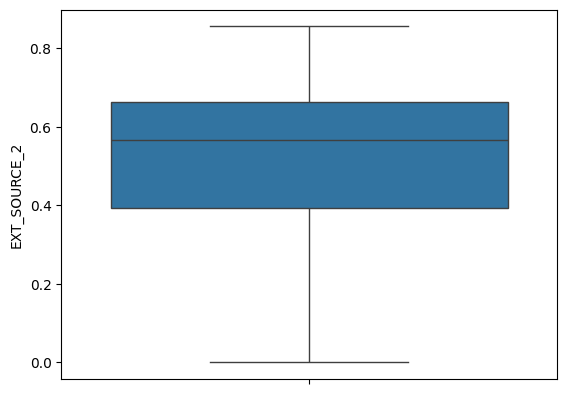

In [427]:
sns.boxplot(df.EXT_SOURCE_2)
plt.show()

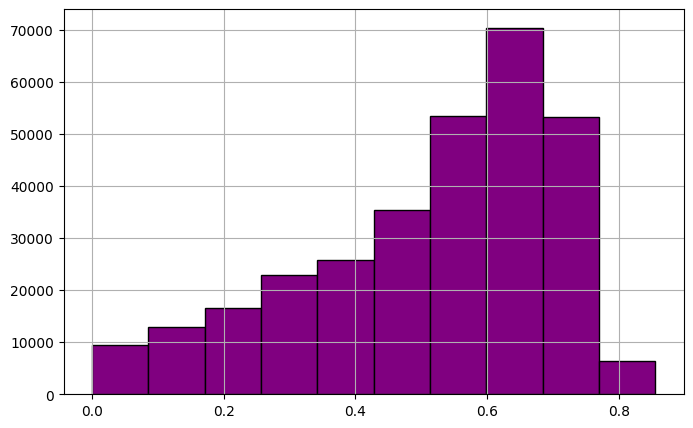

In [428]:
plt.figure(figsize = (8, 5))
df['EXT_SOURCE_2'].hist(bins = 10, edgecolor = 'k', color = 'purple')
plt.show()

**Спостереження**
- Дивлячись на діаграму розмаху та гістограму,
- медіана дорівнює 0.57
- Найчастіше повторюване значення - 0.2859
- Середнє значення - 0.51
- Викидів немає
- Для збереження структури даних підходить мода, тому вона може бути використана для імпутації. Це не призведе до зміщення, оскільки відсоток пропущених значень невеликий (0,21%).

In [429]:
df.fillna({"EXT_SOURCE_2": mode_value}, inplace = True)

# Аналіз стовпця OBS_60_CNT_SOCIAL_CIRCLE
Пропущенні значення 0.33%

In [430]:
null_df_under1[null_df_under1.column_name == 'OBS_60_CNT_SOCIAL_CIRCLE']

column_name  null_count  null_percentage
93  OBS_60_CNT_SOCIAL_CIRCLE        1021             0.33

In [431]:
df['OBS_60_CNT_SOCIAL_CIRCLE'].value_counts()

OBS_60_CNT_SOCIAL_CIRCLE
0.00      164666
1.00       48870
2.00       29766
3.00       20215
4.00       13946
5.00        9463
6.00        6349
7.00        4344
8.00        2886
9.00        1959
10.00       1335
11.00        837
12.00        620
13.00        401
14.00        238
15.00        166
16.00        137
17.00         73
18.00         49
19.00         44
20.00         30
21.00         28
22.00         20
23.00         13
24.00         12
25.00         11
27.00          5
29.00          2
28.00          1
47.00          1
344.00         1
30.00          1
26.00          1
Name: count, dtype: int64

In [432]:
def analyze_the_column(df, column_name):

    mean_value = df[column_name].mean()
    median_value = df[column_name].median()
    mode_value = df[column_name].mode()[0]

    print(f"Середнє значення: {mean_value:.2f}")
    print(f"Медіана: {median_value:.2f}")
    print(f"Мода: {mode_value}")

    return mean_value, median_value, mode_value

mean_value, median_value, mode_value = analyze_the_column(df, 'OBS_60_CNT_SOCIAL_CIRCLE')

Середнє значення: 1.41
Медіана: 0.00
Мода: 0.0


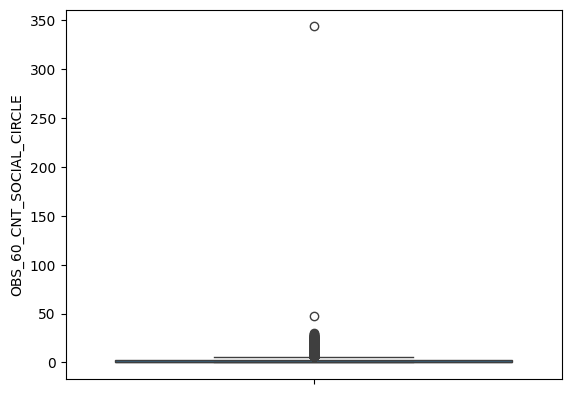

In [433]:
sns.boxplot(df.OBS_60_CNT_SOCIAL_CIRCLE)
plt.show()

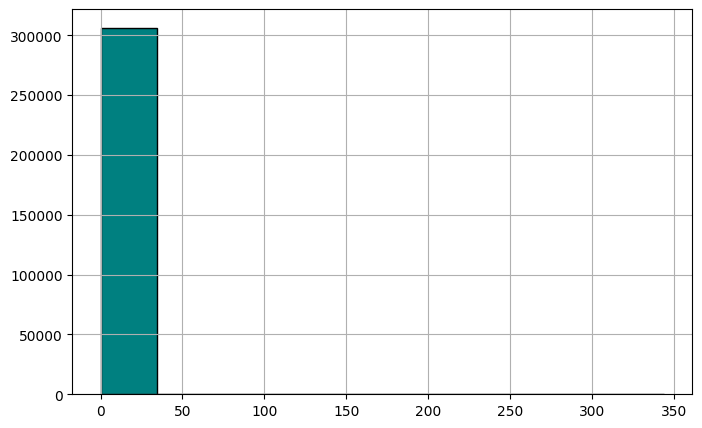

In [434]:
plt.figure(figsize = (8, 5))
df['OBS_60_CNT_SOCIAL_CIRCLE'].hist(bins = 10, edgecolor = 'k', color = 'teal')
plt.show()

**Спостереження**
- Дивлячись на діаграму розмаху, медіана дорівнює 0.0
- Найчастіше повторюване значення - 0.0
- Середнє значення - 1.41
- Є декілька викидних значеннь приблизно на рівні 50 та 350.
- Медіана і мода близькі (з огляду на діапазон даних у цьому стовпчику) і можуть бути використані для імпутації. Це не призведе до зміщення, оскільки відсоток пропущених значень невеликий (0,33%).

In [435]:
df['OBS_60_CNT_SOCIAL_CIRCLE'].fillna(df['OBS_60_CNT_SOCIAL_CIRCLE'].median(), inplace=True)

<ipython-input-435-10dd3c085fec>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['OBS_60_CNT_SOCIAL_CIRCLE'].fillna(df['OBS_60_CNT_SOCIAL_CIRCLE'].median(), inplace=True)


# Аналіз стовпця DEF_60_CNT_SOCIAL_CIRCLE
Пропущенні значення 0.33%

In [436]:
null_df_under1[null_df_under1.column_name == 'DEF_60_CNT_SOCIAL_CIRCLE']

column_name  null_count  null_percentage
94  DEF_60_CNT_SOCIAL_CIRCLE        1021             0.33

In [437]:
df['DEF_60_CNT_SOCIAL_CIRCLE'].value_counts()

DEF_60_CNT_SOCIAL_CIRCLE
0.00     280721
1.00      21841
2.00       3170
3.00        598
4.00        135
5.00         20
6.00          3
7.00          1
24.00         1
Name: count, dtype: int64

In [438]:
def analyze_the_column(df, column_name):

    mean_value = df[column_name].mean()
    median_value = df[column_name].median()
    mode_value = df[column_name].mode()[0]

    print(f"Середнє значення: {mean_value:.2f}")
    print(f"Медіана: {median_value:.2f}")
    print(f"Мода: {mode_value}")

    return mean_value, median_value, mode_value

mean_value, median_value, mode_value = analyze_the_column(df, 'DEF_60_CNT_SOCIAL_CIRCLE')

Середнє значення: 0.10
Медіана: 0.00
Мода: 0.0


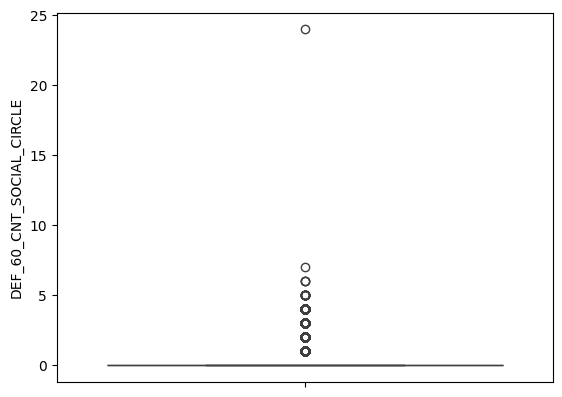

In [439]:
sns.boxplot(df.DEF_60_CNT_SOCIAL_CIRCLE)
plt.show()

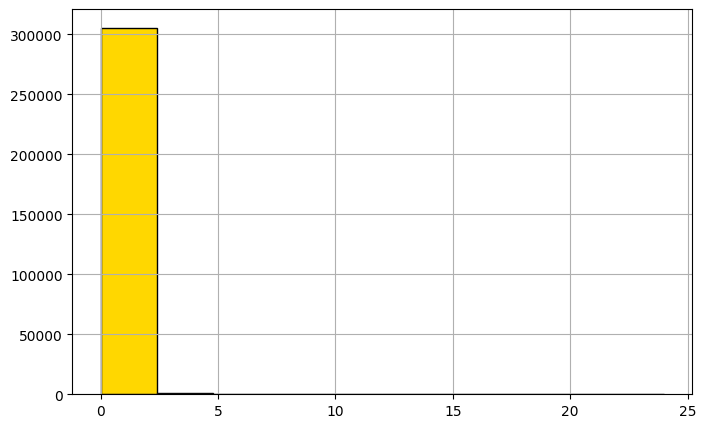

In [440]:
plt.figure(figsize = (8, 5))
df['DEF_60_CNT_SOCIAL_CIRCLE'].hist(bins = 10, edgecolor = 'k', color = 'gold')
plt.show()

**Спостереження**
- Дивлячись на діаграму розмаху, медіана дорівнює 0.0
- Найчастіше повторюване значення - 0.0
- Середнє значення - 0.10
- Є декілька викидних значеннь приблизно на рівні від 1 до 9 та 24.
- Медіана і мода близькі (з огляду на діапазон даних у цьому стовпчику) і можуть бути використані для імпутації. Це не призведе до зміщення, оскільки відсоток пропущених значень невеликий (0,33%).

In [441]:
df.fillna({"DEF_60_CNT_SOCIAL_CIRCLE": median_value}, inplace = True)

# Аналіз стовпця AMT_GOODS_PRICE
Пропущенні значення 0.09%

In [442]:
null_df_under1[null_df_under1.column_name == 'AMT_GOODS_PRICE']

column_name  null_count  null_percentage
10  AMT_GOODS_PRICE         278             0.09

In [443]:
df['AMT_GOODS_PRICE'].value_counts()

AMT_GOODS_PRICE
450000.00     26022
225000.00     25282
675000.00     24962
900000.00     15416
270000.00     11428
              ...  
1265751.00        1
503266.50         1
810778.50         1
666090.00         1
743863.50         1
Name: count, Length: 1002, dtype: int64

In [444]:
def analyze_the_column(df, column_name):

    mean_value = df[column_name].mean()
    median_value = df[column_name].median()
    mode_value = df[column_name].mode()[0]

    print(f"Середнє значення: {mean_value:.2f}")
    print(f"Медіана: {median_value:.2f}")
    print(f"Мода: {mode_value}")

    return mean_value, median_value, mode_value

mean_value, median_value, mode_value = analyze_the_column(df, 'AMT_GOODS_PRICE')

Середнє значення: 538396.21
Медіана: 450000.00
Мода: 450000.0


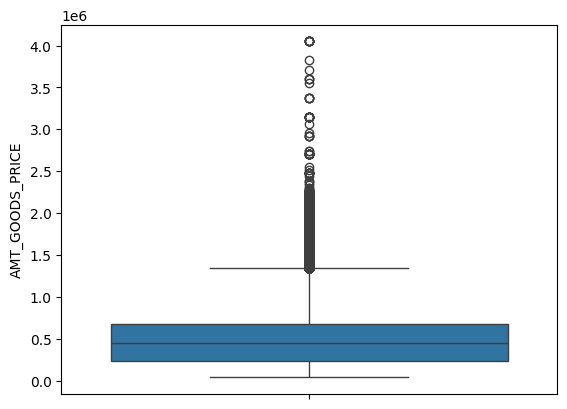

In [445]:
sns.boxplot(df.AMT_GOODS_PRICE)
plt.show()

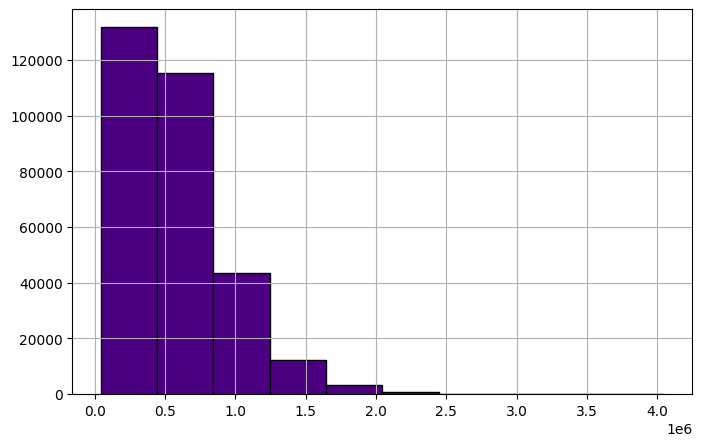

In [446]:
plt.figure(figsize = (8, 5))
df['AMT_GOODS_PRICE'].hist(bins = 10, edgecolor = 'k', color = 'indigo')
plt.show()

**Спостереження**
- Дивлячись на діаграму розмаху та гістограму,
- медіана дорівнює 450000.00
- Найчастіше повторюване значення - 450000.00
- Середнє значення - 538396.21
- Є декілька викидних значеннь приблизно на рівні від 1 до 9 та 24.
- Оскільки дані містять викиди, медіана є найкращим вибором для заповнення пропущених значень. Вона стійка до впливу викидів і відповідає основному розподілу даних. Медіана і мода близькі (з огляду на діапазон даних у цьому стовпчику) і можуть бути використані для імпутації. Це не призведе до зміщення, оскільки відсоток пропущених значень невеликий (0,09%).

In [447]:
df.fillna({"AMT_GOODS_PRICE": median_value}, inplace = True)

# Робота з неправильними/невідомими значеннями даних

### Аналіз стовпця `CODE_GENDER`

Перевірка діапазону значень

In [448]:
df['CODE_GENDER'].value_counts()

CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64

Стать має бути тільки чоловіча або жіноча. Значення `XNA` може вказувати на те, що значення не було надано заявником або пропущено кредитним спеціалістом, який перевіряє заявку

In [449]:
df[df['CODE_GENDER'] == 'XNA']

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER  FLAG_OWN_CAR  \
35657      141289       0    Revolving loans         XNA             1   
38566      144669       0    Revolving loans         XNA             0   
83382      196708       0    Revolving loans         XNA             0   
189640     319880       0    Revolving loans         XNA             1   

        FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
35657                 1             0         207000.00   382500.00   
38566                 1             2         157500.00   270000.00   
83382                 1             1         135000.00   405000.00   
189640                1             0         247500.00   540000.00   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
35657      19125.00        337500.00   Unaccompanied               Working   
38566      13500.00        225000.00          Family               Working   
83382      20250.00        225000.00   Unaccompanied               Working   
189640     27000.00        900000.00   Unaccompanied  Commercial associate   

                  NAME_EDUCATION_TYPE NAME_FAMILY_STATUS    NAME_HOUSING_TYPE  \
35657   Secondary / secondary special            Married  Municipal apartment   
38566   Secondary / secondary special            Married    House / apartment   
83382                Higher education            Married    House / apartment   
189640              Incomplete higher     Civil marriage    House / apartment   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
35657                         0.02      -20232         -10044   
38566                         0.03      -13717          -2797   
83382                         0.04      -10647          -1228   
189640                        0.04       -9649          -2293   

        DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  \
35657           -10024.00            -3537           1               1   
38566            -2241.00            -4659           1               1   
83382             -183.00            -1671           1               1   
189640           -4099.00            -2326           1               1   

        FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
35657                 1                 1           1           0   
38566                 1                 1           1           0   
83382                 1                 1           1           0   
189640                1                 1           1           0   

           OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
35657              Unknown             2.00                     3   
38566   Low-skill Laborers             4.00                     2   
83382           Core staff             3.00                     2   
189640             Unknown             2.00                     2   

        REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
35657                             3                    TUESDAY   
38566                             2                     FRIDAY   
83382                             2                   THURSDAY   
189640                            2                     FRIDAY   

        HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
35657                        10                           0   
38566                        16                           0   
83382                        15                           0   
189640                       15                           0   

        REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
35657                            0                            0   
38566                            0                            0   
83382                            0                            0   
189640                           0                            0   

        REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
35657                        0                       

Оскільки дані виглядають достовірними, ми перевіримо можливість застосування методу імпутації.
- Заявників-жінок удвічі більше, ніж заявників-чоловіків
- Отже, ми прирівняємо `CODE_GENDER` до 'F'

In [450]:
df['CODE_GENDER_CHANGED'] = df['CODE_GENDER'].apply(lambda x: 1 if x == 'XNA' else 0)

In [451]:
df['CODE_GENDER'] = df['CODE_GENDER'].apply(lambda x: 'F' if x == 'XNA' else x)

Перевірка, чи вилучено `XNA

In [452]:
df['CODE_GENDER'].value_counts()

CODE_GENDER
F    202452
M    105059
Name: count, dtype: int64

### Аналіз стовпця `DAYS_BIRTH`

In [453]:
df['DAYS_BIRTH'].value_counts().head()

DAYS_BIRTH
-13749    43
-13481    42
-18248    41
-10020    41
-15771    40
Name: count, dtype: int64

Існує ~17K+ унікальних записів, всі з яких, схоже, мають від'ємні значення

In [454]:
df['DAYS_BIRTH'].unique()

array([ -9461, -16765, -19046, ...,  -7951,  -7857, -25061])

In [455]:
df['DAYS_BIRTH'].nunique()

17460

In [456]:
df['DAYS_BIRTH'].describe()

count   307511.00
mean    -16037.00
std       4363.99
min     -25229.00
25%     -19682.00
50%     -15750.00
75%     -12413.00
max      -7489.00
Name: DAYS_BIRTH, dtype: float64

Перетворення `Days Birth` на додатні дні

In [457]:
df['DAYS_BIRTH'] = df['DAYS_BIRTH'].apply(lambda x: -x if x < 0 else x)

In [458]:
df['DAYS_BIRTH'].describe()

count   307511.00
mean     16037.00
std       4363.99
min       7489.00
25%      12413.00
50%      15750.00
75%      19682.00
max      25229.00
Name: DAYS_BIRTH, dtype: float64

Всі дні в `DAYS_BIRTH` мають додатні значення - це може бути зручніше для аналізу.

#### Створимо нову колонку `YEARS_BIRTH` для зручності аналізу

In [459]:
df['YEARS_BIRTH'] = df['DAYS_BIRTH'].apply(lambda x: round(x/365))

### Аналіз стовпця `NAME_FAMILY_STATUS`

Перевірка діапазону значень

In [460]:
df['NAME_FAMILY_STATUS'].value_counts()

NAME_FAMILY_STATUS
Married                 196432
Single / not married     45444
Civil marriage           29775
Separated                19770
Widow                    16088
Unknown                      2
Name: count, dtype: int64

Стать має бути тільки чоловіча або жіноча. Значення `Unknown` може означати, що значення не було вказане заявником або пропущене кредитним спеціалістом, який перевіряє заявку

In [461]:
df[df['NAME_FAMILY_STATUS'] == 'Unknown']

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER  FLAG_OWN_CAR  \
41982      148605       0    Revolving loans           M             0   
187348     317181       0    Revolving loans           F             0   

        FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
41982                 1             0         450000.00   675000.00   
187348                1             0         202500.00   585000.00   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
41982      33750.00        450000.00              NA  Commercial associate   
187348     29250.00        450000.00              NA  Commercial associate   

       NAME_EDUCATION_TYPE NAME_FAMILY_STATUS    NAME_HOUSING_TYPE  \
41982      Lower secondary            Unknown  Municipal apartment   
187348    Higher education            Unknown    House / apartment   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
41982                         0.02       12396          -1161   
187348                        0.03       12844           -232   

        DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  \
41982            -3265.00            -4489           1               1   
187348           -1597.00            -1571           1               1   

        FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
41982                 1                 1           1           0   
187348                0                 1           0           0   

       OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
41982         Managers              NaN                     2   
187348     Accountants              NaN                     2   

        REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
41982                             2                   THURSDAY   
187348                            2                     FRIDAY   

        HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
41982                        15                           0   
187348                       14                           0   

        REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
41982                            1                            1   
187348                           0                            0   

        REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
41982                        0                       1   
187348                       0                       0   

        LIVE_CITY_NOT_WORK_CITY       ORGANIZATION_TYPE  EXT_SOURCE_2  \
41982                         1               Insurance          0.70   
187348                        0  Business Entity Type 2          0.65   

        EXT_SOURCE_3  OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
41982            NaN                      3.00                      0.00   
187348          0.67                      1.00                      0.00   

        OBS_60_CNT_SOCIAL_CIRCLE  DEF_60_CNT_SOCIAL_CIRCLE  \
41982                       3.00                      0.00   
187348                      1.00                      0.00   

        DAYS_LAST_PHONE_CHANGE  FLAG_DOCUMENT_2  FLAG_DOCUMENT_3  \
41982                  -876.00                0                0   
187348                 -654.00                0                0   

        FLAG_DOCUMENT_4  FLAG_DOCUMENT_5  FLAG_DOCUMENT_6  FLAG_DOCUMENT_7  \
41982                 0                1                0                0   
187348                0                0                0                1   

        FLAG_DOCUMENT_8  FLAG_DOCUMENT_9  FLAG_DOCUMENT_10  FLAG_DOCUMENT_11  \
41982                 0                0                 0                 0   
187348                0                0                 0                 0   

        FLAG_DOCUMENT_12  FLAG_DOCUMENT_13  FLAG_DOCUMENT_14  \
41982                  0                 0                 0   
187348                 0                 0                 0   

        FLAG_DOCUMENT_15 

In [462]:
df['NAME_FAMILY_STATUS'].value_counts(normalize = True) * 100

NAME_FAMILY_STATUS
Married                63.88
Single / not married   14.78
Civil marriage          9.68
Separated               6.43
Widow                   5.23
Unknown                 0.00
Name: proportion, dtype: float64

Оскільки дані виглядають достовірними, ми продовжимо перевірку методу імпутації.
- Одружені заявники складають понад 63% заявників.
- Отже, ми прирівняємо `NAME_FAMILY_STATUS` до `Married`.

In [463]:
df['NAME_FAMILY_STATUS'] = df['NAME_FAMILY_STATUS'].apply(lambda x: 'Married' if x == 'Unknown' else x)

Перевірка чи вилучено `Unknown`

In [464]:
df['NAME_FAMILY_STATUS'].value_counts()

NAME_FAMILY_STATUS
Married                 196434
Single / not married     45444
Civil marriage           29775
Separated                19770
Widow                    16088
Name: count, dtype: int64

### Аналіз стовпця`DAYS_EMPLOYED`

In [465]:
df['DAYS_EMPLOYED'].value_counts().head()

DAYS_EMPLOYED
 365243    55374
-200         156
-224         152
-230         151
-199         151
Name: count, dtype: int64

In [466]:
df['DAYS_EMPLOYED'].value_counts(normalize = True) * 100

DAYS_EMPLOYED
 365243   18.01
-200       0.05
-224       0.05
-230       0.05
-199       0.05
           ... 
-13961     0.00
-11827     0.00
-10176     0.00
-9459      0.00
-8694      0.00
Name: proportion, Length: 12574, dtype: float64

In [467]:
len(df[df['DAYS_EMPLOYED'] < 365243])

252137

In [468]:
df[df['DAYS_EMPLOYED'] < 365243].DAYS_EMPLOYED.value_counts()

DAYS_EMPLOYED
-200      156
-224      152
-199      151
-230      151
-212      150
         ... 
-13961      1
-11827      1
-10176      1
-9459       1
-8694       1
Name: count, Length: 12573, dtype: int64

In [469]:
df['DAYS_EMPLOYED'].unique()

array([  -637,  -1188,   -225, ..., -12971, -11084,  -8694])

In [470]:
df['DAYS_EMPLOYED'].nunique()

12574

**Спостереження**
- Існує ~55K+ записів, для яких `DAYS_EMPLOYED` дорівнює 365243 дням
- Решта 252K+ записів мають від'ємне значення днів
- Існує 12 574 унікальних значень для `DAYS_EMPLOYED

 - Колонка `DAYS_EMPLOYED` вказує на те, за скільки днів до подачі заявки особа почала поточну роботу, заявник/кредитний спеціаліст повинен ввести від'ємні значення, щоб вказати дні, що передують даті подачі заявки.<br>
 - Ми конвертуємо від'ємні значення в `DAYS_EMPLOYED` в додатні дні, щоб стандартизувати дні під час використання в розрахунках

In [471]:
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].apply(lambda x: -x if x < 0 else x)

In [472]:
df['DAYS_EMPLOYED'].value_counts().head()

DAYS_EMPLOYED
365243    55374
200         156
224         152
230         151
199         151
Name: count, dtype: int64

Ми бачимо, що всі дні в `DAYS_EMPLOYED` мають додатні значення.

**Для ~55K+ записів, для яких `DAYS_EMPLOYED` становить 365243 дні**
- Конвертуючи це в роки, ми отримуємо 1000 років, які фізично неможливо використати для працевлаштування заявника
- Це відповідає 18% даних і не може бути аномалією
- Вони можуть бути або "пенсіонерами", або "безробітними", і, дивлячись на дані, наш висновок є правильним

> Є два способи впоратися з цим
>> 1) Ми залишаємо дані такими, якими вони є, і враховуємо це під час аналізу АБО  <br>
>> 2) Ми розраховуємо середню кількість днів зайнятості без урахування цієї категорії та вписуємо її замість 365243 днів для пенсіонерів. <br>
>> Для безробітних кількість днів зайнятості може дорівнювати 0

*Примітка*
 - Під час розрахунків у цьому стовпчику ми повинні враховувати цей сценарій, оскільки інакше він спотворює наші результати

In [473]:
days_median = df[df['DAYS_EMPLOYED'] != 365243].DAYS_EMPLOYED.median()

In [474]:
df_days_employed = df['DAYS_EMPLOYED'].apply(lambda x: days_median if x==365243 else x)

<Axes: >

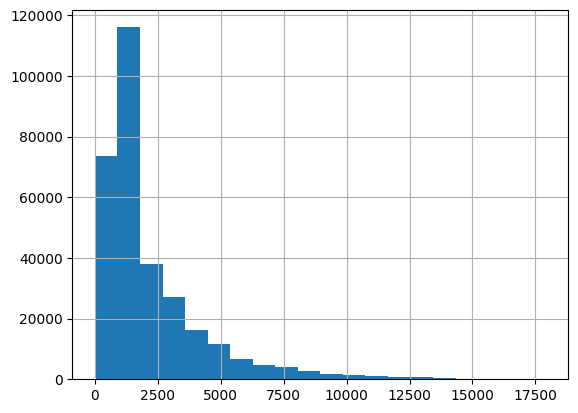

In [475]:
df_days_employed.hist(bins=20)

<Axes: >

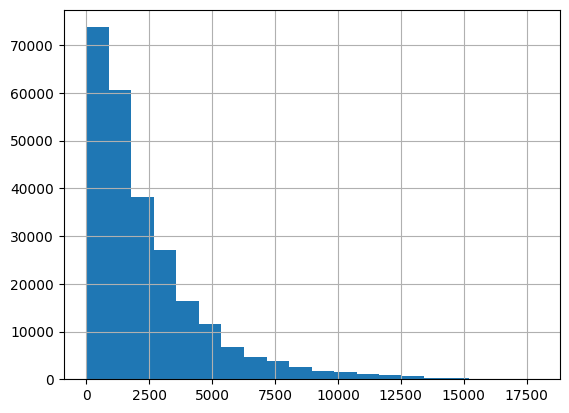

In [476]:
df[df['DAYS_EMPLOYED'] != 365243].DAYS_EMPLOYED.hist(bins=20)

In [477]:
df[df['DAYS_EMPLOYED'] == 365243].NAME_INCOME_TYPE.value_counts()

NAME_INCOME_TYPE
Pensioner     55352
Unemployed       22
Name: count, dtype: int64

#### Створимо нову колонку `YEARS_EMPLOYED` для зручності аналізу

In [478]:
df['YEARS_EMPLOYED'] = df['DAYS_EMPLOYED'].apply(lambda x: round(x/365))

### Аналіз стовпця `DAYS_REGISTRATION`

In [479]:
df['DAYS_REGISTRATION'].value_counts().head()

DAYS_REGISTRATION
-1.00    113
-7.00     98
-6.00     96
-4.00     92
-2.00     92
Name: count, dtype: int64

In [480]:
df['DAYS_REGISTRATION'].value_counts(normalize = True).head()

DAYS_REGISTRATION
-1.00   0.00
-7.00   0.00
-6.00   0.00
-4.00   0.00
-2.00   0.00
Name: proportion, dtype: float64

In [481]:
df['DAYS_REGISTRATION'].unique()

array([ -3648.,  -1186.,  -4260., ..., -16396., -14558., -14798.])

In [482]:
df['DAYS_REGISTRATION'].nunique()

15688

Перетворення `DAYS_REGISTRATION` в додатні дні

In [483]:
df['DAYS_REGISTRATION'] = df['DAYS_REGISTRATION'].apply(lambda x: -x if x < 0 else x)

In [484]:
df['DAYS_REGISTRATION'].value_counts().head()

DAYS_REGISTRATION
1.00    113
7.00     98
6.00     96
4.00     92
2.00     92
Name: count, dtype: int64

Всі дні в `DAYS_REGISTRATION` мають додатні значення

#### Створимо нову колонку `YEARS_REGISTRATION` для зручності аналізу

In [485]:
df['YEARS_REGISTRATION'] = df['DAYS_REGISTRATION'].apply(lambda x: round(x/365))

### Аналіз стовпця `DAYS_ID_PUBLISH`

In [486]:
df['DAYS_ID_PUBLISH'].value_counts().head()

DAYS_ID_PUBLISH
-4053    169
-4095    162
-4046    161
-4417    159
-4256    158
Name: count, dtype: int64

In [487]:
df['DAYS_ID_PUBLISH'].value_counts(normalize = True).head()

DAYS_ID_PUBLISH
-4053   0.00
-4095   0.00
-4046   0.00
-4417   0.00
-4256   0.00
Name: proportion, dtype: float64

In [488]:
df['DAYS_ID_PUBLISH'].unique()

array([-2120,  -291, -2531, ..., -6194, -5854, -6211])

In [489]:
df['DAYS_ID_PUBLISH'].nunique()

6168

Перетворення `DAYS_ID_PUBLISH` в додатні дні

In [490]:
df['DAYS_ID_PUBLISH'] = df['DAYS_ID_PUBLISH'].apply(lambda x: -x if x < 0 else x)

In [491]:
df['DAYS_ID_PUBLISH'].value_counts().head()

DAYS_ID_PUBLISH
4053    169
4095    162
4046    161
4417    159
4256    158
Name: count, dtype: int64

Всі дні в `DAYS_ID_PUBLISH` мають додатні значення

#### Створимо нову колонку `YEARS_ID_PUBLISH` для зручності аналізу

In [492]:
df['YEARS_ID_PUBLISH'] = df['DAYS_ID_PUBLISH'].apply(lambda x: round(x/365))

### Аналіз стовпця `DAYS_LAST_PHONE_CHANGE`

In [493]:
df['DAYS_LAST_PHONE_CHANGE'].value_counts().head()

DAYS_LAST_PHONE_CHANGE
0.00     37672
-1.00     2812
-2.00     2318
-3.00     1763
-4.00     1285
Name: count, dtype: int64

In [494]:
df['DAYS_LAST_PHONE_CHANGE'].value_counts(normalize = True).head()

DAYS_LAST_PHONE_CHANGE
0.00    0.12
-1.00   0.01
-2.00   0.01
-3.00   0.01
-4.00   0.00
Name: proportion, dtype: float64

In [495]:
df['DAYS_LAST_PHONE_CHANGE'].unique()

array([-1134.,  -828.,  -815., ..., -3988., -3899., -3538.])

In [496]:
df['DAYS_LAST_PHONE_CHANGE'].nunique()

3773

Перетворення `DAYS_LAST_PHONE_CHANGE` в додатні дні

In [497]:
df['DAYS_LAST_PHONE_CHANGE'] = df['DAYS_LAST_PHONE_CHANGE'].apply(lambda x: -x if x < 0 else x)

In [498]:
df['DAYS_LAST_PHONE_CHANGE'].value_counts().head()

DAYS_LAST_PHONE_CHANGE
0.00    37672
1.00     2812
2.00     2318
3.00     1763
4.00     1285
Name: count, dtype: int64

Всі дні в `DAYS_LAST_PHONE_CHANGE` мають додатні значення

#### Створення нової колонки `YEARS_LAST_PHONE_CHANGE` для зручності аналізу

In [499]:
df['YEARS_LAST_PHONE_CHANGE'] = df['DAYS_LAST_PHONE_CHANGE'].apply(lambda x: round(x/365,0))

# Функції для автоматизації

### Створення функції `age_cat` для категоризації даних, що містять інформацію про роки

In [500]:
def age_cat(years):
    if years <= 20:
        return '0-20'
    elif years > 20 and years <= 30:
        return '20-30'
    elif years > 30 and years <= 40:
        return '30-40'
    elif years > 40 and years <= 50:
        return '40-50'
    elif years > 50 and years <= 60:
        return '50-60'
    elif years > 60 and years <= 70:
        return '60-70'
    elif years > 70:
        return '70+'

### Одномірний (категоріальний vs цільовий) та двомірний (категоріальний vs категоріальний) аналіз (гістограма) - категоріальні стовпчики

In [501]:
import matplotlib.pyplot as plt


def bi_cat_countplot(df, column, hue_column):
    unique_hue_values = df[hue_column].unique()
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(14,6)

    pltname = f'Нормалізований розподіл значень за категорією: {column}'
    proportions = df.groupby(hue_column)[column].value_counts(normalize=True)
    proportions = (proportions*100).round(2)
    ax = proportions.unstack(hue_column).sort_values(
        by=unique_hue_values[0], ascending=False
        ).plot.bar(ax=axes[0], title=pltname)

    # анотація значень в барплоті
    for container in ax.containers:
        ax.bar_label(container, fmt='{:,.1f}%')

    pltname = f'Кількість даних за категорією: {column}'
    counts = df.groupby(hue_column)[column].value_counts()
    ax = counts.unstack(hue_column).sort_values(
        by=unique_hue_values[0], ascending=False
        ).plot.bar(ax=axes[1], title=pltname)

    for container in ax.containers:
      ax.bar_label(container)


def uni_cat_target_compare(df, column):
    bi_cat_countplot(df, column, hue_column='TARGET')


### Обчислення мінімального та максимального діапазону відхилень для числових стовпців

In [502]:
def outlier_range(dataset,column):
    Q1 = dataset[column].quantile(0.25)
    Q3 = dataset[column].quantile(0.75)
    IQR = Q3 - Q1
    Min_value = (Q1 - 1.5 * IQR)
    Max_value = (Q3 + 1.5 * IQR)
    return Max_value

### Робота з викидами для числових стовпців

In [503]:
import warnings

def dist_box(dataset, column):
    with warnings.catch_warnings():
      warnings.simplefilter("ignore")

      plt.figure(figsize=(16,6))

      plt.subplot(1,2,1)
      sns.distplot(dataset[column], color = 'purple')
      pltname = 'Графік розподілу для ' + column
      plt.ticklabel_format(style='plain', axis='x')
      plt.title(pltname)

      plt.subplot(1,2,2)
      red_diamond = dict(markerfacecolor='r', marker='D')
      sns.boxplot(y = column, data = dataset, flierprops = red_diamond)
      pltname = 'Боксплот для ' + column
      plt.title(pltname)

      plt.show()

### Аналіз стовпця `CNT_CHILDREN`

In [504]:
df['CNT_CHILDREN'].value_counts().sort_values(ascending = False);

In [505]:
(df['CNT_CHILDREN'].value_counts(normalize = True).sort_values(ascending = False) * 100).head()

CNT_CHILDREN
0   70.04
1   19.88
2    8.70
3    1.21
4    0.14
Name: proportion, dtype: float64

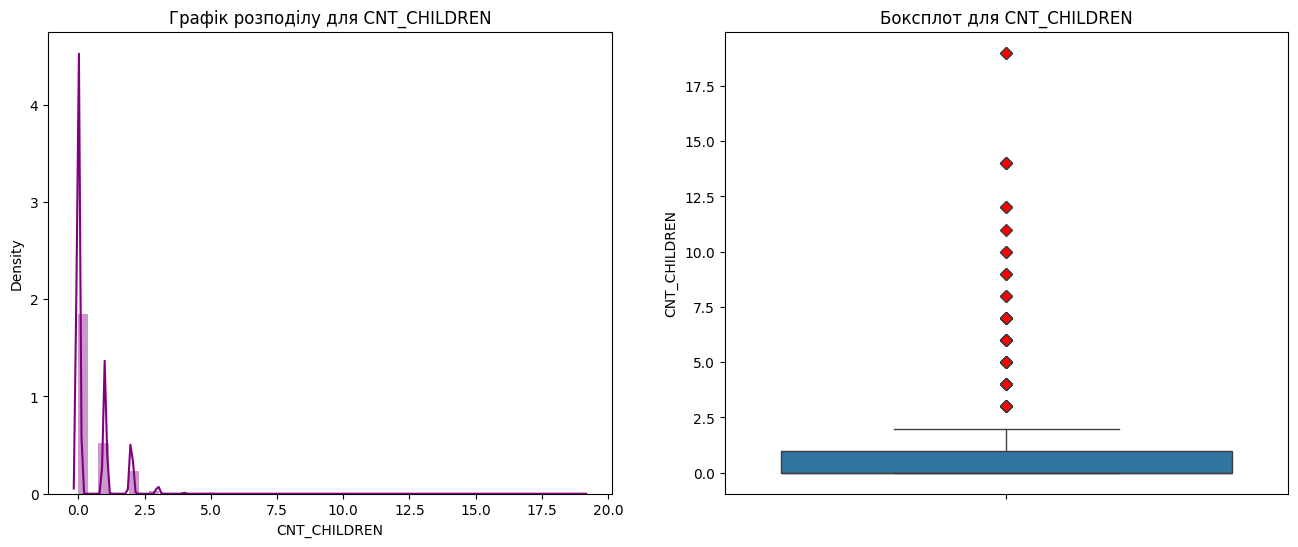

In [506]:
dist_box(df,'CNT_CHILDREN')

Розрахуємо IQR (Inter Quartile range)

In [507]:
Q1 = df['CNT_CHILDREN'].quantile(0.25)
Q3 = df['CNT_CHILDREN'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

1.0


In [508]:
Q1, Q3

(0.0, 1.0)

Значення *до* (Q1 - 1,5 * IQR) та *після* (Q3 + 1,5 * IQR) є викидами

In [509]:
Min_value = (Q1 - 1.5 * IQR)
Max_value = (Q3 + 1.5 * IQR)
print("Мінімальне значення, до якого існують викиди: {}".format(Min_value))
print("Максимальне значення, після якого існують викиди: {}".format(Max_value))

Мінімальне значення, до якого існують викиди: -1.5
Максимальне значення, після якого існують викиди: 2.5


In [510]:
df[df['CNT_CHILDREN'].isin(range(10,20))].YEARS_BIRTH

34545     47
80948     39
132585    31
155369    30
171125    38
176011    49
183878    56
186820    41
265784    28
267998    42
Name: YEARS_BIRTH, dtype: int64

In [511]:
df[df['CNT_CHILDREN'].isin([10])][['SK_ID_CURR', 'CNT_CHILDREN', 'YEARS_BIRTH']]

SK_ID_CURR  CNT_CHILDREN  YEARS_BIRTH
132585     253779            10           31
186820     316580            10           41

**Спостереження**
- Дивлячись на дані, ми бачимо, що кількість заявників, які мають більше 7 дітей, є дуже мінімальною (2 або 3 в кожній категорії)
- Крім того, дивлячись на дані для заявників з 10 дітьми, заявники мають лише 31 й 41 рік відповідно. Це виглядає як одиничний випадок й може розглядатися як відхилення від норми
- Як дистрибутивні, так і діаграми розмаху чітко показують, що значення, які перевищують значення 2.5, є відхиленнями від норми.

**Висновок**
- Заявники, які мають 3 або більше дітей, є випадками, що відхиляються від норми. Ми можемо надати спеціальний аналіз для цих випадків.

### Аналіз стовпця `AMT_INCOME_TOTAL`

In [512]:
df['AMT_INCOME_TOTAL'].value_counts().sort_values(ascending = False).head()

AMT_INCOME_TOTAL
135000.00    35750
112500.00    31019
157500.00    26556
180000.00    24719
90000.00     22483
Name: count, dtype: int64

In [513]:
(df['AMT_INCOME_TOTAL'].value_counts(normalize = True).sort_values(ascending = False) * 100).head()

AMT_INCOME_TOTAL
135000.00   11.63
112500.00   10.09
157500.00    8.64
180000.00    8.04
90000.00     7.31
Name: proportion, dtype: float64

In [514]:
df['AMT_INCOME_TOTAL'].describe(percentiles = [0.75,0.99,0.999])

count      307511.00
mean       168797.92
std        237123.15
min         25650.00
50%        147150.00
75%        202500.00
99%        472500.00
99.9%      900000.00
max     117000000.00
Name: AMT_INCOME_TOTAL, dtype: float64

Побудуємо графік для `AMT_INCOME_TOTAL`

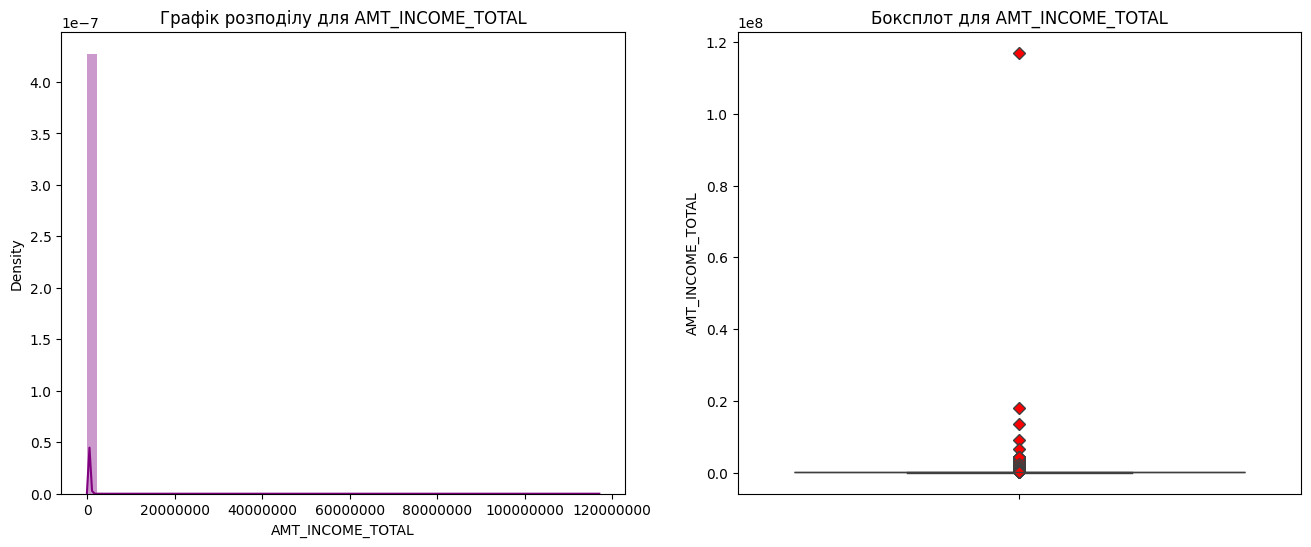

In [515]:
dist_box(df,'AMT_INCOME_TOTAL')

- Графіки кінцевого результату дуже тонкі, й ми можемо спостерігати викид близько ~120 мільйонів.
- Давайте побудуємо графік, розглядаючи лише дохід нижче 99,9% значення, тобто 900 тисяч.

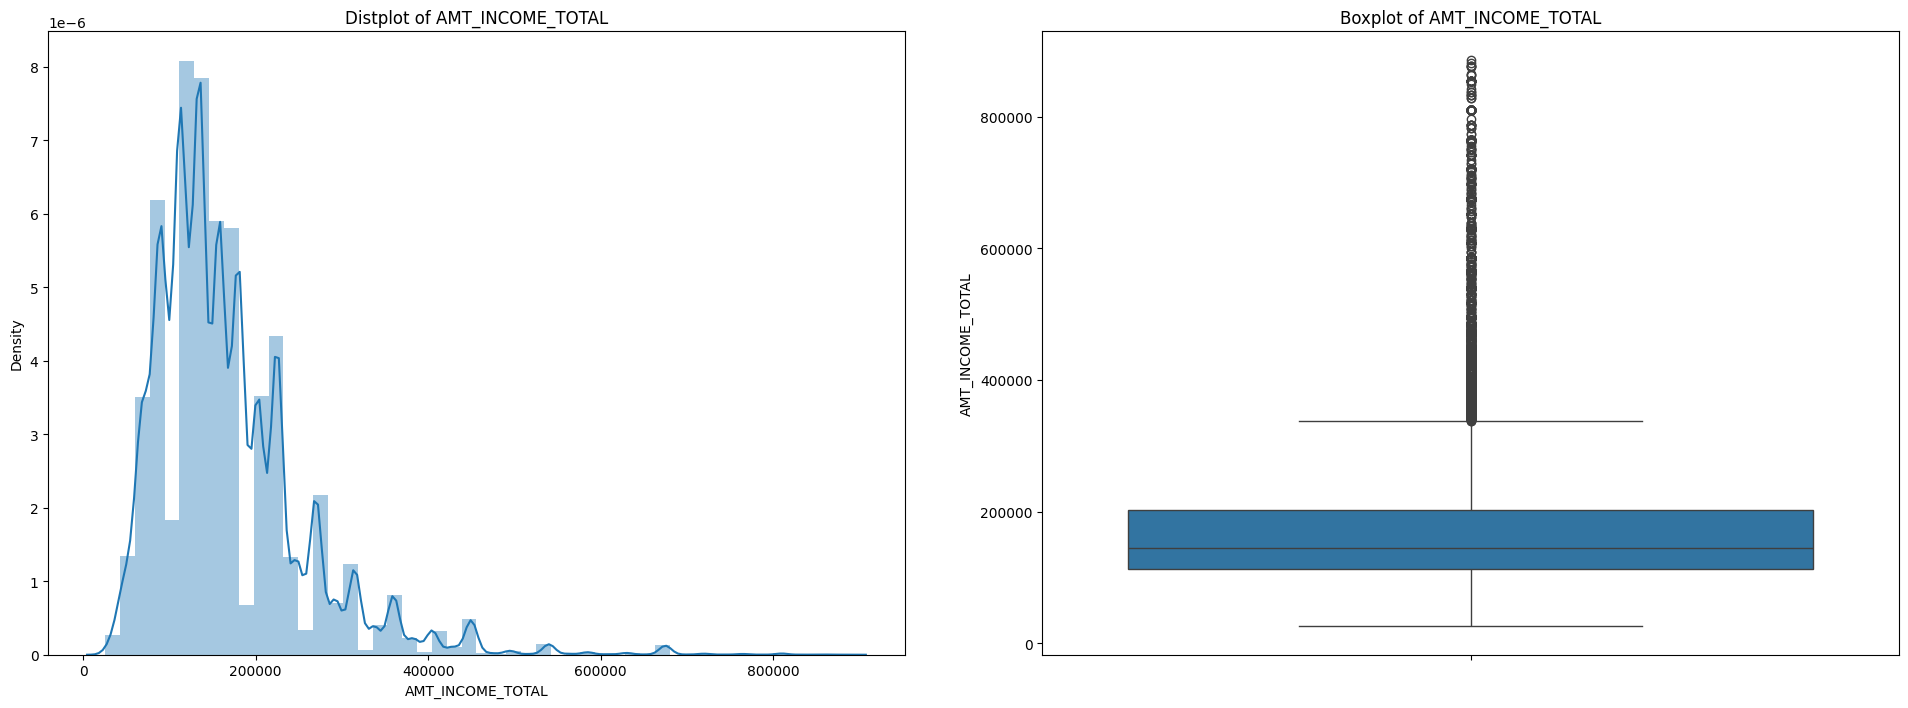

In [516]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.subplots(1,2 ,figsize = (20,8))

    plt.subplot(121)
    sns.distplot(df[df['AMT_INCOME_TOTAL'] < 900000].AMT_INCOME_TOTAL)
    pltname = 'Distplot of ' + 'AMT_INCOME_TOTAL'
    plt.title(pltname)

    plt.subplot(122)
    sns.boxplot(df[df['AMT_INCOME_TOTAL'] < 900000].AMT_INCOME_TOTAL)
    pltname = 'Boxplot of ' + 'AMT_INCOME_TOTAL'
    plt.title(pltname)

    plt.tight_layout(pad = 4)
    plt.show()

Тепер ми можемо чітко побачити розподіл і діапазон даних на обох графіках.
 - Це означає, що значення понад 900 тис. грн доходу явно є викидами

In [517]:
df[df['AMT_INCOME_TOTAL'] > 900000].head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER  FLAG_OWN_CAR  \
1504     101769       0    Revolving loans           M             1   
1723     102015       0         Cash loans           F             0   
3371     103938       0         Cash loans           F             0   
4603     105384       0    Revolving loans           F             1   
5673     106637       0         Cash loans           M             1   

      FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
1504                1             0        1080000.00   180000.00   
1723                1             0        1935000.00   269550.00   
3371                0             1        1350000.00  2410380.00   
4603                1             0        1350000.00   405000.00   
5673                1             3         967500.00   450000.00   

      AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
1504      9000.00        180000.00   Unaccompanied  Commercial associate   
1723     10534.50        225000.00   Unaccompanied             Pensioner   
3371    109053.00       2250000.00              NA  Commercial associate   
4603     20250.00        405000.00   Unaccompanied  Commercial associate   
5673     30073.50        450000.00   Unaccompanied  Commercial associate   

                NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
1504               Higher education            Married  House / apartment   
1723  Secondary / secondary special            Married  House / apartment   
3371               Higher education            Married  House / apartment   
4603               Higher education            Married  House / apartment   
5673               Higher education            Married  House / apartment   

      REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
1504                        0.07       13633           5536   
1723                        0.01       18636         365243   
3371                        0.07       12213            843   
4603                        0.02       14781           4768   
5673                        0.05       11901            546   

      DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  \
1504               3.00             4971           1               1   
1723            3401.00             2168           1               0   
3371             757.00             4132           1               1   
4603            3469.00             4045           1               1   
5673            2932.00              215           1               1   

      FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
1504                0                 1           0           0   
1723                0                 1           1           0   
3371                0                 1           1           0   
4603                0                 1           0           0   
5673                0                 1           0           0   

     OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
1504         Unknown             2.00                     1   
1723         Unknown             2.00                     2   
3371        Managers             3.00                     1   
4603        Managers             2.00                     2   
5673        Managers             5.00                     1   

      REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
1504                            1                     FRIDAY   
1723                            2                     MONDAY   
3371                            1                     SUNDAY   
4603                            2                    TUESDAY   
5673                            1                     MONDAY   

      HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
1504                       13                           0   
1723                       11                           0   
3371                       13                           0   
4603          

**Спостереження**
- Дивлячись на дані, ми бачимо, що дохід понад 900 тис. грн (99,9% значення) є викидом
- Як діаграма розподілу, так і діаграма розмаху чітко показують нам ту саму тенденцію

**Висновок**
- Апліканти з доходом понад 900 тис. грн (99,9% значення) є викидами

# ДЗ 3. Аналіз викидів
Подібно до прикладу, проаналізуйте колонки на викиди:
- CNT_FAM_MEMBERS;
- AMT_ANNUITY.

Зазначте які значення в них можна вважати викидами.

### Аналіз стовпця `CNT_FAM_MEMBERS`

In [518]:
df['CNT_FAM_MEMBERS'].value_counts().sort_values(ascending = False);

In [519]:
(df['CNT_FAM_MEMBERS'].value_counts(normalize = True).sort_values(ascending = False) * 100).head()

CNT_FAM_MEMBERS
2.00   51.50
1.00   22.06
3.00   17.11
4.00    8.03
5.00    1.13
Name: proportion, dtype: float64

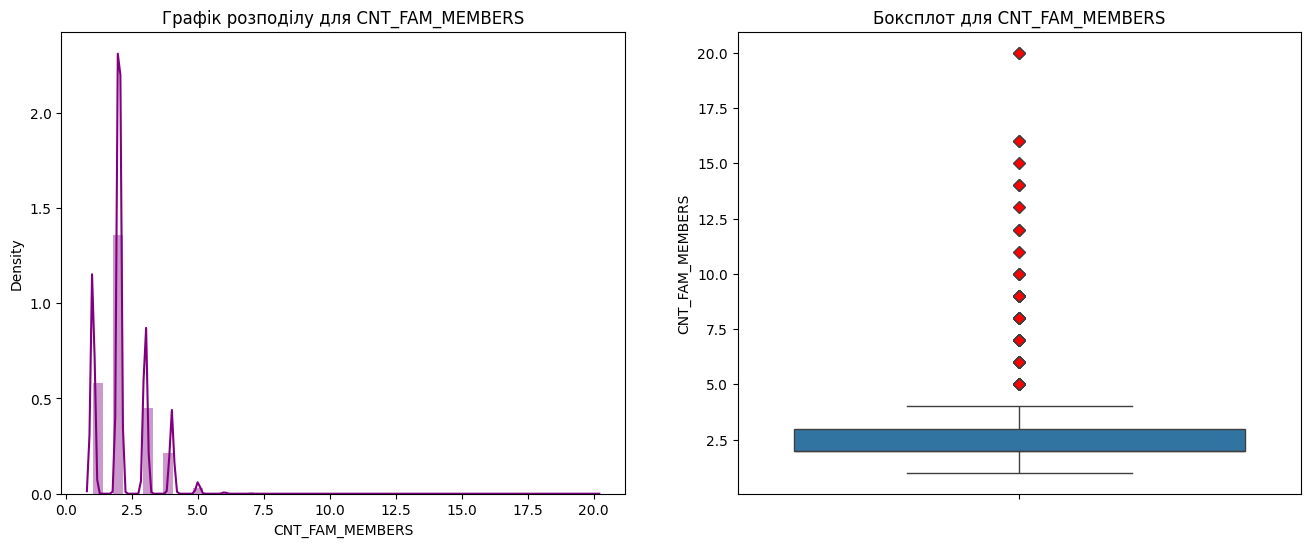

In [520]:
dist_box(df,'CNT_FAM_MEMBERS')

In [521]:
df['CNT_FAM_MEMBERS'].describe(percentiles = [0.75,0.99,0.999])

count   307509.00
mean         2.15
std          0.91
min          1.00
50%          2.00
75%          3.00
99%          5.00
99.9%        6.00
max         20.00
Name: CNT_FAM_MEMBERS, dtype: float64

In [522]:
Q1 = df['CNT_FAM_MEMBERS'].quantile(0.25)
Q3 = df['CNT_FAM_MEMBERS'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

1.0


In [523]:
Q1, Q3

(2.0, 3.0)

In [524]:
Min_value = (Q1 - 1.5 * IQR)
Max_value = (Q3 + 1.5 * IQR)
print("Мінімальне значення, до якого існують викиди: {}".format(Min_value))
print("Максимальне значення, після якого існують викиди: {}".format(Max_value))

Мінімальне значення, до якого існують викиди: 0.5
Максимальне значення, після якого існують викиди: 4.5


In [525]:
df[df['CNT_FAM_MEMBERS'].isin(range(10,20))].YEARS_BIRTH

12615     42
23881     30
34545     47
80948     39
132585    31
154317    31
171125    38
176011    49
183878    56
186820    41
267998    42
276768    40
Name: YEARS_BIRTH, dtype: int64

In [526]:
df[df['CNT_FAM_MEMBERS'].isin([12])][['SK_ID_CURR', 'CNT_FAM_MEMBERS', 'YEARS_BIRTH']]

SK_ID_CURR  CNT_FAM_MEMBERS  YEARS_BIRTH
132585     253779            12.00           31
186820     316580            12.00           41

**Спостереження**
- Дивлячись на дані, ми бачимо, що кількість заявників, які мають більше 5 членів сім'ї, є дуже мінімальною (2 або 3 в кожній категорії)
- Крім того, дивлячись на дані для заявників з 12 членами сім'ї, заявники мають лише 31 й 41 рік відповідно. Це виглядає як одиничний випадок й може розглядатися як відхилення від норми
- Як дистрибутивні, так і діаграми розмаху чітко показують, що значення, які перевищують значення 4.5, є відхиленнями від норми.

**Висновок**
- Заявники, які мають 5 або більше дітей, є випадками, що відхиляються від норми. Ми можемо надати спеціальний аналіз для цих випадків.

### Аналіз стовпця `AMT_ANNUITY`

In [527]:
df['AMT_ANNUITY'].value_counts().sort_values(ascending = False);

In [528]:
(df['AMT_ANNUITY'].value_counts(normalize = True).sort_values(ascending = False) * 100).head()

AMT_ANNUITY
9000.00    2.08
13500.00   1.79
6750.00    0.74
10125.00   0.66
37800.00   0.52
Name: proportion, dtype: float64

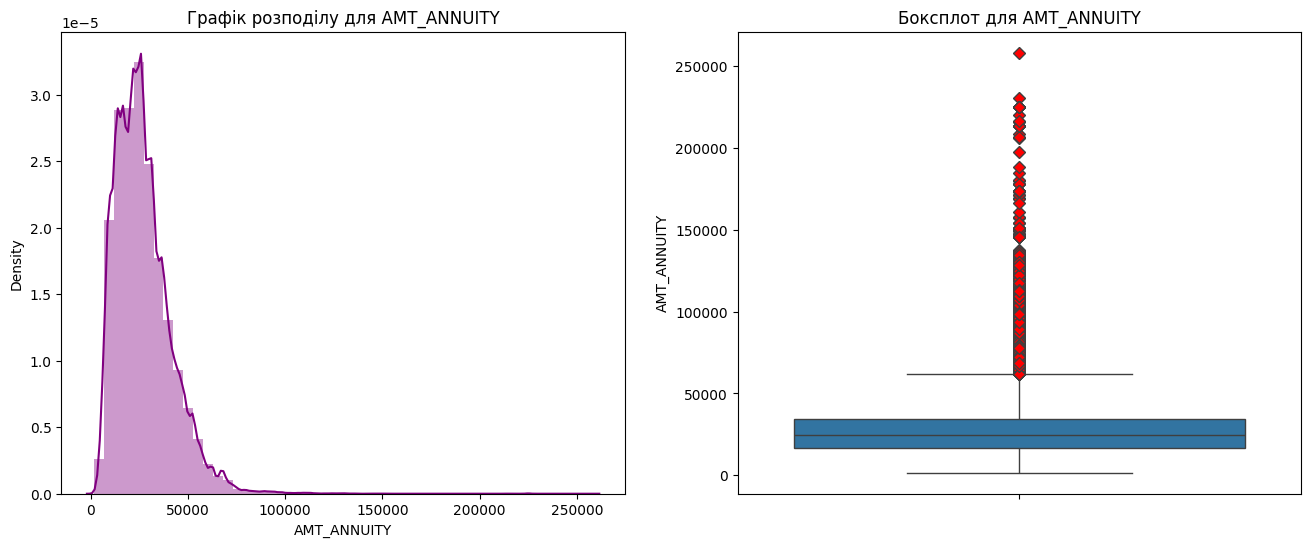

In [529]:
dist_box(df,'AMT_ANNUITY')

In [530]:
df['AMT_ANNUITY'].describe(percentiles = [0.75,0.99,0.999])

count   307499.00
mean     27108.57
std      14493.74
min       1615.50
50%      24903.00
75%      34596.00
99%      70006.50
99.9%   110047.50
max     258025.50
Name: AMT_ANNUITY, dtype: float64

In [531]:
outlier_range(df,'AMT_ANNUITY')

61704.0

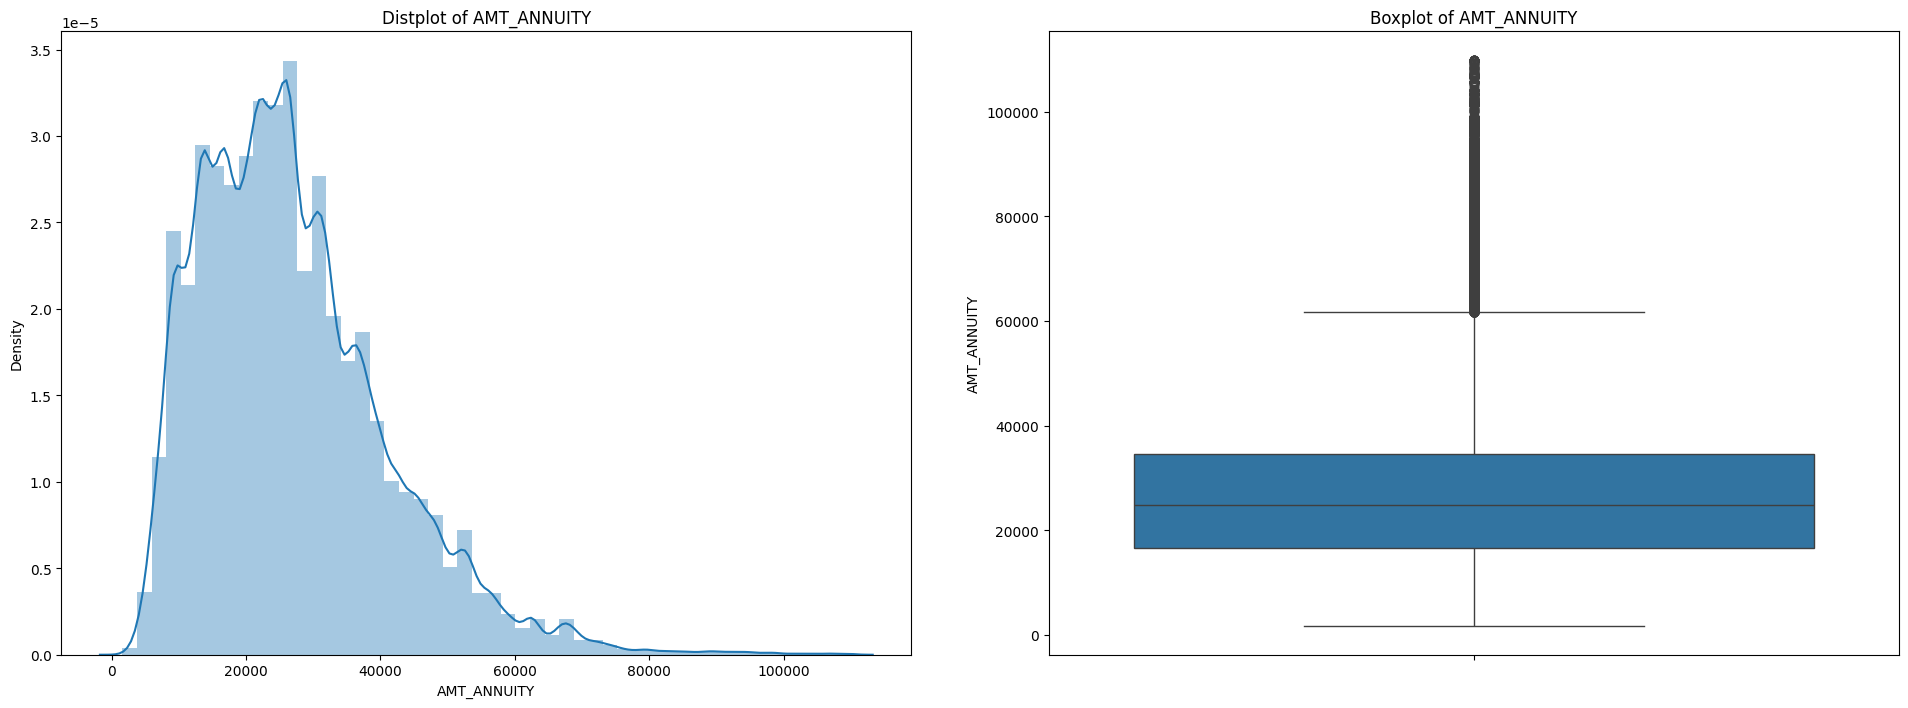

In [532]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.subplots(1,2 ,figsize = (20,8))

    plt.subplot(121)
    sns.distplot(df[df['AMT_ANNUITY'] < 110047.50].AMT_ANNUITY)
    pltname = 'Distplot of ' + 'AMT_ANNUITY'
    plt.title(pltname)

    plt.subplot(122)
    sns.boxplot(df[df['AMT_ANNUITY'] < 110047.50].AMT_ANNUITY)
    pltname = 'Boxplot of ' + 'AMT_ANNUITY'
    plt.title(pltname)

    plt.tight_layout(pad = 4)
    plt.show()

In [533]:
df[df['AMT_ANNUITY'] > 110047.50].head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER  FLAG_OWN_CAR  \
485      100559       0         Cash loans           F             1   
1446     101701       0         Cash loans           F             1   
2513     102931       0         Cash loans           F             1   
3228     103767       0         Cash loans           M             1   
3428     104003       0         Cash loans           F             1   

      FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
485                 1             0         450000.00  2286211.50   
1446                0             1         360000.00  2250000.00   
2513                1             1         292500.00  1409719.50   
3228                1             0         468000.00  2356920.00   
3428                1             1         180000.00  1157670.00   

      AMT_ANNUITY  AMT_GOODS_PRICE  NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
485     116266.50       2182500.00    Unaccompanied         State servant   
1446    116505.00       2250000.00    Unaccompanied               Working   
2513    135936.00       1377000.00    Unaccompanied               Working   
3228    119731.50       2250000.00  Spouse, partner  Commercial associate   
3428    112909.50       1125000.00    Unaccompanied  Commercial associate   

                NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
485                Higher education            Married  House / apartment   
1446  Secondary / secondary special     Civil marriage  House / apartment   
2513  Secondary / secondary special            Married  House / apartment   
3228               Higher education     Civil marriage  House / apartment   
3428               Higher education            Married  House / apartment   

      REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
485                         0.02       20589          13994   
1446                        0.01       13374           1563   
2513                        0.05       13928           6099   
3228                        0.07        9293            953   
3428                        0.01       10414           1188   

      DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  \
485             5893.00             4106           1               1   
1446            4890.00             2890           1               1   
2513            7991.00             3163           1               1   
3228            4171.00             1966           1               1   
3428            4880.00             1169           1               1   

      FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
485                 0                 1           0           0   
1446                1                 1           1           0   
2513                0                 1           1           0   
3228                0                 1           0           0   
3428                0                 1           0           0   

     OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
485       Core staff             2.00                     2   
1446     Sales staff             3.00                     3   
2513         Unknown             3.00                     1   
3228         Unknown             2.00                     1   
3428      Core staff             3.00                     3   

      REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
485                             2                     MONDAY   
1446                            3                  WEDNESDAY   
2513                            1                     MONDAY   
3228                            1                     MONDAY   
3428                            3                    TUESDAY   

      HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
485                        16                           0   
1446                       12                           0   
2513                       14                           0   
3228    

**Спостереження**
- Дивлячись на дані, ми бачимо, що анюїтетний кредит понад 110 тис. грн (99,9% значення) є викидом
- Як діаграма розподілу, так і діаграма розмаху чітко показують нам ту саму тенденцію.

**Висновок**
- Апліканти з анюїтетним кредитом понад 110 тис. грн (99,9% значення) є викидами.

# Розбиття на біни безперервних колонок для аналізу

### Категоризація стовпця `AMT_GOODS_PRICE

In [534]:
df['AMT_GOODS_PRICE'].value_counts().sort_values(ascending = False).head()

AMT_GOODS_PRICE
450000.00    26300
225000.00    25282
675000.00    24962
900000.00    15416
270000.00    11428
Name: count, dtype: int64

In [535]:
(df['AMT_GOODS_PRICE'].value_counts(normalize = True).sort_values(ascending = False) * 100).head()

AMT_GOODS_PRICE
450000.00   8.55
225000.00   8.22
675000.00   8.12
900000.00   5.01
270000.00   3.72
Name: proportion, dtype: float64

Подивимось статистичний звіт для `AMT_GOODS_PRICE

In [536]:
df['AMT_GOODS_PRICE'].describe(percentiles = [0.25,0.75,0.99,0.9999])

count     307511.00
mean      538316.29
std       369288.98
min        40500.00
25%       238500.00
50%       450000.00
75%       679500.00
99%      1800000.00
99.99%   2933964.00
max      4050000.00
Name: AMT_GOODS_PRICE, dtype: float64

Розподілимо значення в `AMT_GOODS_PRICE` на 5 бінів і створимо новий стовпець `AMT_GOODS_PRICE_CATEGORY`.

In [537]:
df['AMT_GOODS_PRICE_CATEGORY'] = pd.cut(df['AMT_GOODS_PRICE'],
                                        bins = 5, labels = ['very low', 'low', 'medium', 'high', 'very high'])

Перевірка заповнення значень згідно з очікуванням

In [538]:
df['AMT_GOODS_PRICE_CATEGORY'].value_counts()

AMT_GOODS_PRICE_CATEGORY
very low     247251
low           56087
medium         4108
high             47
very high        18
Name: count, dtype: int64

### Категоризація стовпця `YEARS_BIRTH`

Ми будемо класифікувати `YEARS_BIRTH` замість `DAYS_BIRTH`, оскільки роки легше інтерпретувати, ніж дні

In [539]:
df['YEARS_BIRTH'].value_counts().sort_values(ascending = False).head()

YEARS_BIRTH
39    9023
38    8793
37    8727
40    8602
41    8495
Name: count, dtype: int64

In [540]:
(df['YEARS_BIRTH'].value_counts(normalize = True).sort_values(ascending = False) * 100).head()

YEARS_BIRTH
39   2.93
38   2.86
37   2.84
40   2.80
41   2.76
Name: proportion, dtype: float64

Подивимось статистичний звіт для  `YEARS_BIRTH`

In [541]:
df['YEARS_BIRTH'].describe(percentiles = [0.25,0.75,0.99,0.9999])

count    307511.00
mean         43.94
std          11.96
min          21.00
25%          34.00
50%          43.00
75%          54.00
99%          67.00
99.99%       69.00
max          69.00
Name: YEARS_BIRTH, dtype: float64

Категоризуймо значення з `YEARS_BIRTH` у новий стовпець `YEARS_BIRTH_CATEGORY`.

In [542]:
df['YEARS_BIRTH_CATEGORY'] = df['YEARS_BIRTH'].apply(age_cat)

Перевірка заповнення значень згідно з очікуванням

In [543]:
df['YEARS_BIRTH_CATEGORY'].value_counts().sort_values(ascending = False)

YEARS_BIRTH_CATEGORY
30-40    82770
40-50    75509
50-60    67955
20-30    48869
60-70    32408
Name: count, dtype: int64

### Категоризація стовпця `YEARS_REGISTRATION`

Ми будемо класифікувати `YEARS_REGISTRATION` замість `DAYS_REGISTRATION`, оскільки роки легше інтерпретувати, ніж дні

In [544]:
df['YEARS_REGISTRATION'].value_counts().sort_values(ascending = False).head()

YEARS_REGISTRATION
1     15661
2     15564
3     13894
13    12866
12    12697
Name: count, dtype: int64

In [545]:
(df['YEARS_REGISTRATION'].value_counts(normalize = True).sort_values(ascending = False) * 100).head()

YEARS_REGISTRATION
1    5.09
2    5.06
3    4.52
13   4.18
12   4.13
Name: proportion, dtype: float64

Подивимось статистичний звіт для `YEARS_REGISTRATION`

In [546]:
df['YEARS_REGISTRATION'].describe(percentiles = [0.25,0.75,0.99,0.9999])

count    307511.00
mean         13.66
std           9.66
min           0.00
25%           6.00
50%          12.00
75%          20.00
99%          38.00
99.99%       54.25
max          68.00
Name: YEARS_REGISTRATION, dtype: float64

Категоризуймо значення з `YEARS_REGISTRATION` в новий стовпець `YEARS_REGISTRATION_CATEGORY`.

In [547]:
df['YEARS_REGISTRATION_CATEGORY'] = df['YEARS_REGISTRATION'].apply(age_cat)

Перевірка заповнення значень згідно з очікуванням

In [548]:
df['YEARS_REGISTRATION_CATEGORY'].value_counts().sort_values(ascending = False)

YEARS_REGISTRATION_CATEGORY
0-20     230697
20-30     59288
30-40     16051
40-50      1406
50-60        60
60-70         9
Name: count, dtype: int64

# Зберігання оновлених даних зі стисненням

In [549]:
filename = "drive/MyDrive/Machine Learning для людей/data/credit/application_data_processed"
compression_options = dict(method='zip', archive_name=f'{filename}.csv')
df.to_csv(f'{filename}.zip', compression=compression_options, index=False)

In [550]:
# якщо Вам треба буде зчитати оновлені дані - замініть шлях на свій і можна зчитати їх тут
# df = pd.read_csv('drive/MyDrive/Machine Learning для людей/data/credit/application_data_processed.zip')

# Перевірка дисбалансу для цільового стовпця `TARGET`

### Аналіз стовпця `TARGET`

In [551]:
df['TARGET'].value_counts().sort_values(ascending = False)

TARGET
0    282686
1     24825
Name: count, dtype: int64

In [552]:
df['TARGET'].value_counts(normalize = True).sort_values(ascending = False) * 100

TARGET
0   91.93
1    8.07
Name: proportion, dtype: float64

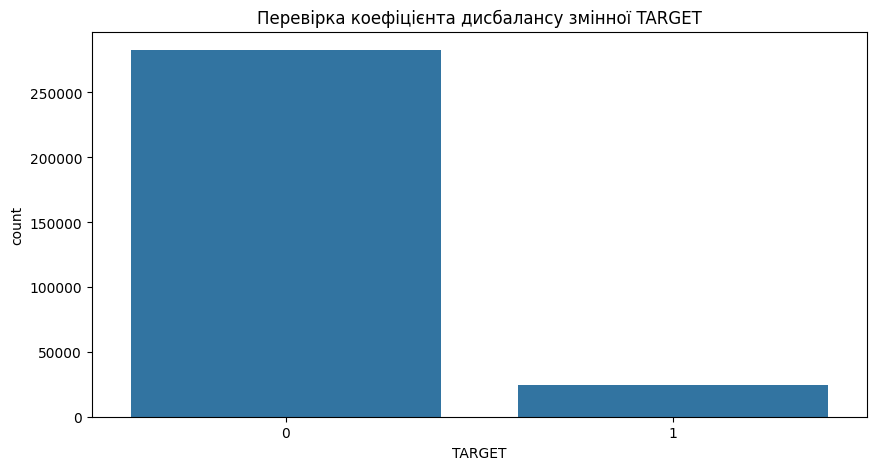

In [553]:
plt.figure(figsize = (10,5))
sns.countplot(x = df['TARGET'], data = df)
plt.title('Перевірка коефіцієнта дисбалансу змінної TARGET')
plt.show()

**Спостереження**

- Ми маємо дисбаланс у змінній `TARGET` на основі % спостережень
 - Значення `TARGET` 1 - це клієнт, який має труднощі з оплатою (прострочення платежу більше ніж на X днів принаймні за одним з перших Y платежів за кредитом). Це лише 8,07% даних
 - Значення `TARGET` 0 - всі інші випадки, окрім 1. Це 91,93% даних

# Розподіл даних на основі `TARGET`

### Створіть новий фрейм даних зі значенням `TARGET` 1
- Значення `TARGET` 1 представляє клієнта з платіжними труднощами (він/вона прострочив платіж більш ніж на X днів принаймні по одному з перших Y платежів за кредитом). Це лише 8,07% даних

In [554]:
df1 = df[df['TARGET'] == 1]

In [555]:
df1.TARGET.value_counts()

TARGET
1    24825
Name: count, dtype: int64

### Створити новий фрейм даних зі значенням `TARGET` 0
- Значення `TARGET` 0 представляє всі інші випадки, крім 1. Це 91.93% даних

In [556]:
df0 = df[df['TARGET'] == 0]

In [557]:
df0.TARGET.value_counts()

TARGET
0    282686
Name: count, dtype: int64

# Одномірний аналіз категоріальних змінних

### Аналіз стовпця `NAME_CONTRACT_TYPE`

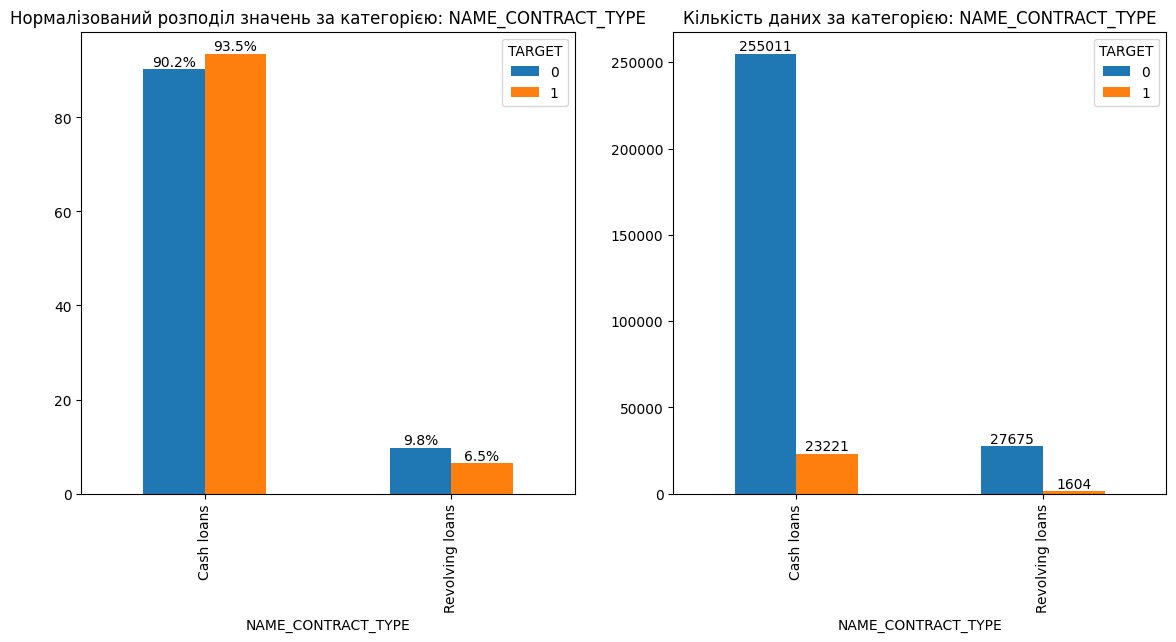

In [558]:
uni_cat_target_compare(df, 'NAME_CONTRACT_TYPE')

**Спостереження**

- Дивлячись на гістограми, ми не бачимо суттєвих відмінностей у `NAME_CONTRACT_TYPE` між клієнтами, які мають труднощі з оплатою, та клієнтами, які платять вчасно

**Висновок**
- Колонка `NAME_CONTRACT_TYPE` не надає жодних переконливих доказів на користь клієнтів, які мають труднощі з оплатою АБО вчасно сплачують

# ДЗ 4. Одновимірний аналіз категоріальної колонки

Проведіть подібний аналіз для колонки

- CODE_GENDER;
- FLAG_OWN_CAR;
- NAME_INCOME_TYPE.

 Опціонально:

 - NAME_EDUCATION_TYPE;
 - NAME_FAMILY_STATUS.

Чи є вплив цих змінних на цільову та який саме?

### Аналіз стовпця `CODE_GENDER`


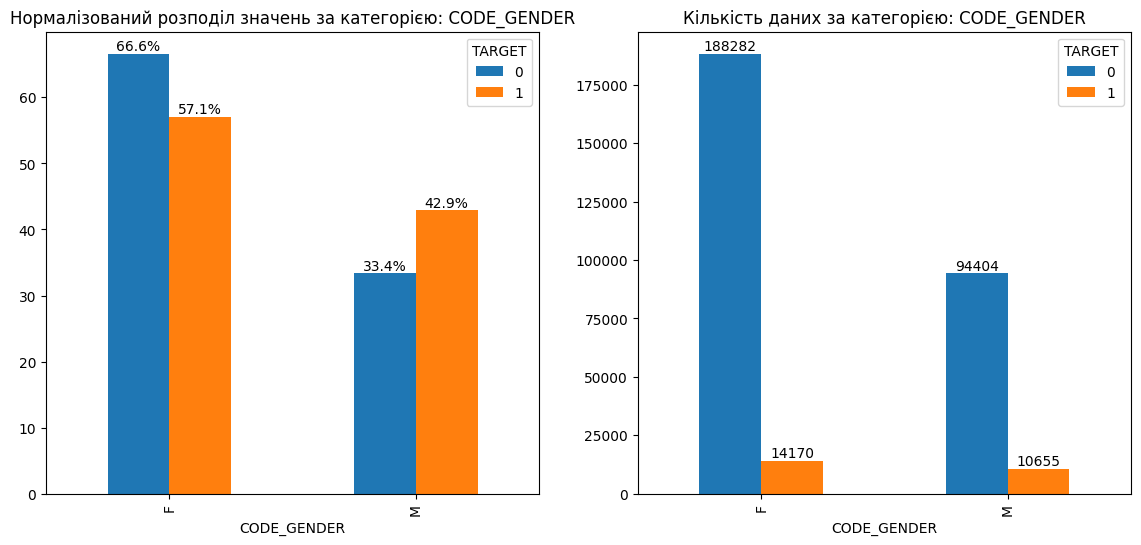

In [559]:
uni_cat_target_compare(df, 'CODE_GENDER')

**Спостереження**

- Дивлячись на гістограми, ми бачимо певні відмінності у `CODE_GENDER` між клієнтами, які мають труднощі з оплатою, та клієнтами, які платять вчасно.

**Висновок**
- Колонка `CODE_GENDER` надає певні докази того, що ймовірність того, що чоловік не виплатить кредит, є трішки вищою (майже на 10%).

### Аналіз стовпця `FLAG_OWN_CAR`

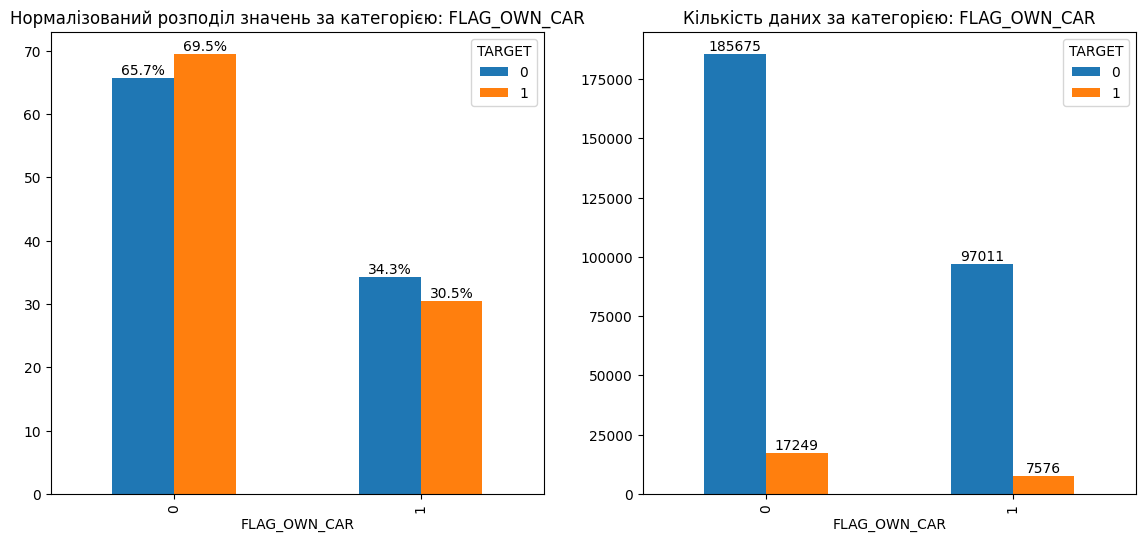

In [560]:
uni_cat_target_compare(df, 'FLAG_OWN_CAR' )

**Спостереження**

- Дивлячись на гістограми, ми не бачимо суттєвих відмінностей у `FLAG_OWN_CAR` між клієнтами, які мають труднощі з оплатою, та клієнтами, які платять вчасно

**Висновок**
- Колонка `FLAG_OWN_CAR` не надає жодних переконливих доказів на користь клієнтів, які мають труднощі з оплатою АБО вчасно сплачують


### Аналіз стовпця `NAME_INCOME_TYPE`

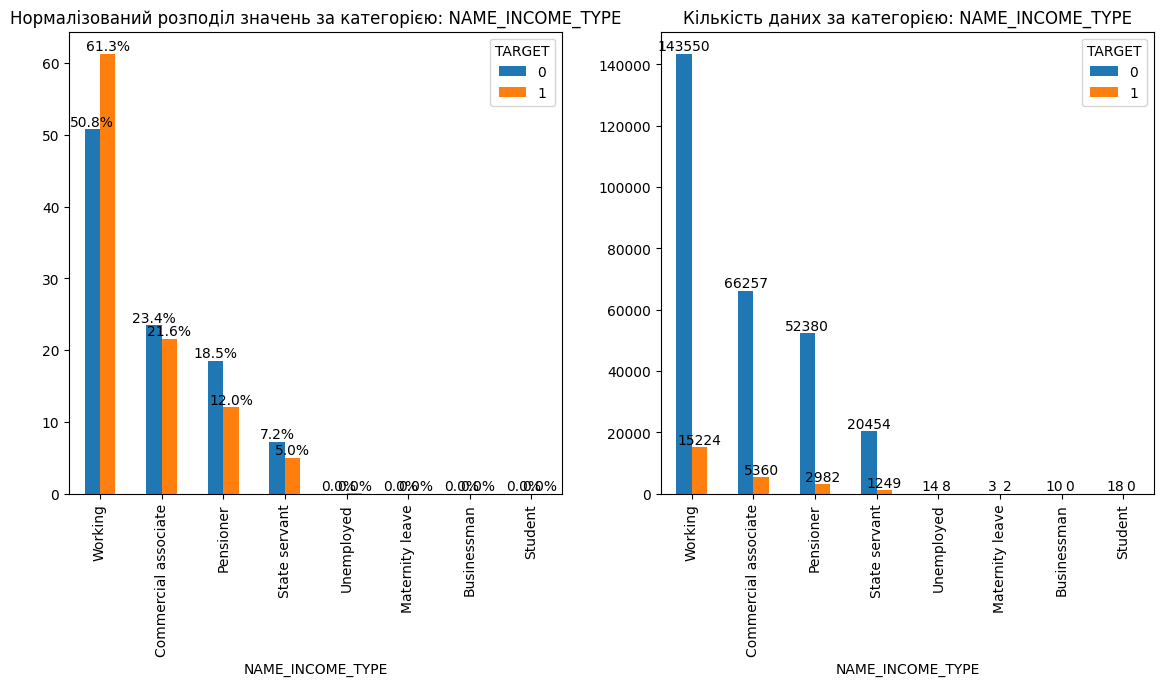

In [561]:
uni_cat_target_compare(df, 'NAME_INCOME_TYPE')

**Спостереження**

- Дивлячись на гістограми, ми бачимо суттєві відмінності у `NAME_INCOME_TYPE` між парцюючими клієнтами, які мають труднощі з оплатою, та клієнтами, які платять вчасно

**Висновок**
- Колонка `NAME_INCOME_TYPE` надає певні докази того, що працюючі клієнти не виплатять кредит вчасно з більшою ймовірністю (майже 10%), ніж виплатять.

Однак це все відносно, і на мою думку, це не є важливим чинником, який потрібно брати до уваги.

### Аналіз стовпця `NAME_EDUCATION_TYPE`

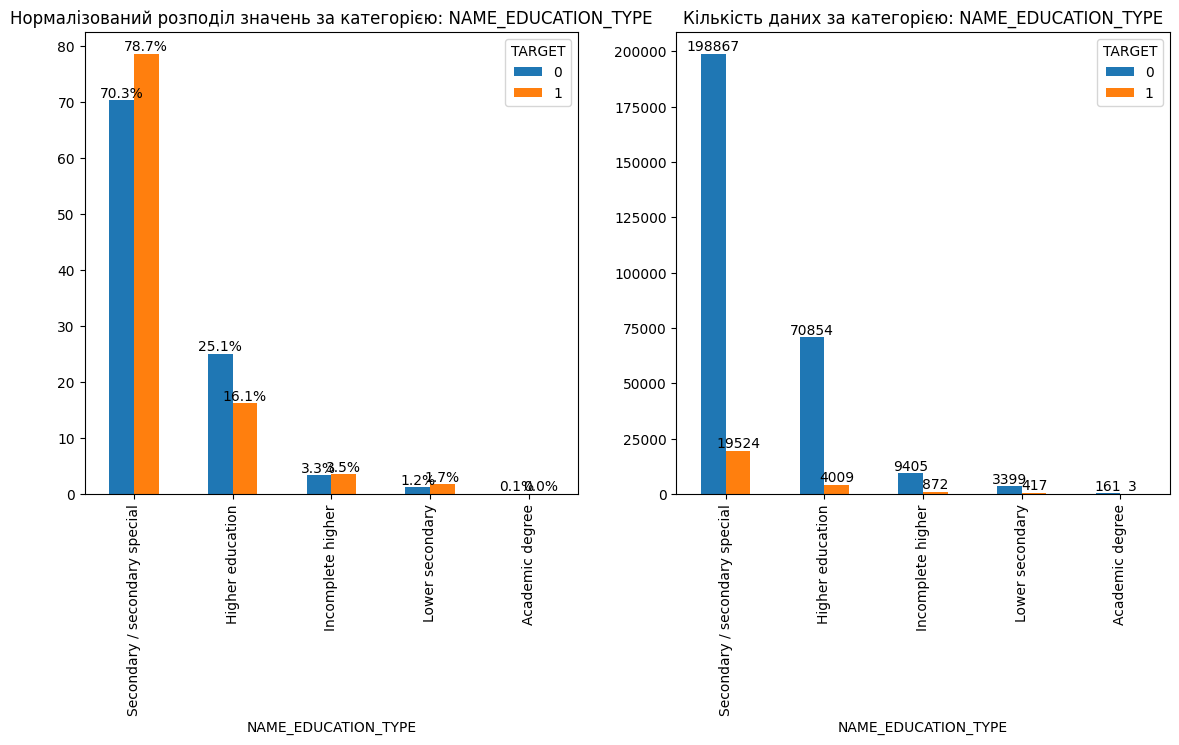

In [562]:
uni_cat_target_compare(df, 'NAME_EDUCATION_TYPE')

**Спостереження**

- Дивлячись на гістограми, ми не бачимо суттєвих відмінностей у `NAME_CONTRACT_TYPE` між клієнтами, які мають труднощі з оплатою, та клієнтами, які платять вчасно

**Висновок**
- Колонка `NAME_CONTRACT_TYPE` не надає жодних переконливих доказів на користь клієнтів, які мають труднощі з оплатою АБО вчасно сплачують


### Аналіз стовпця `NAME_FAMILY_STATUS`



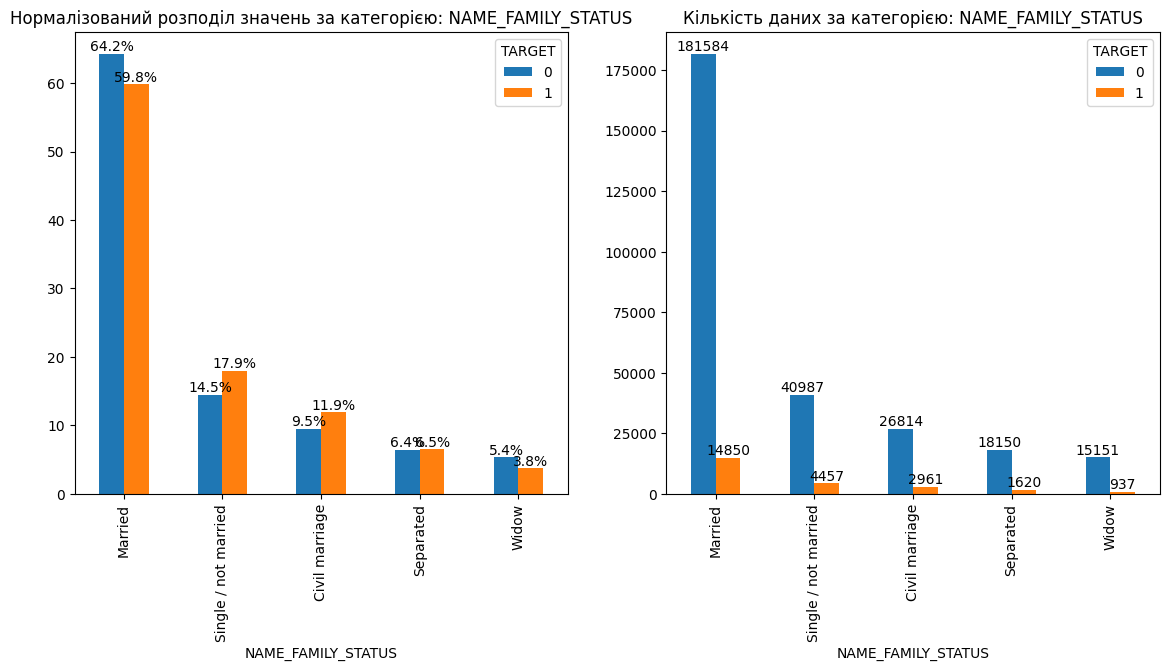

In [563]:
uni_cat_target_compare(df, 'NAME_FAMILY_STATUS')

**Спостереження**

- Дивлячись на гістограми, ми не бачимо суттєвих відмінностей у `NAME_FAMILY_STATUS` між клієнтами, які мають труднощі з оплатою, та клієнтами, які платять вчасно.

**Висновок**
- Колонка `NAME_FAMILY_STATUS` не надає жодних переконливих доказів на користь клієнтів, які мають труднощі з оплатою АБО вчасно сплачують.


# Кореляційний аналіз числових змінних

### Побудова кореляційної матриці для випадків із платіжними труднощами

In [564]:
df1.select_dtypes(include='number').shape

(24825, 68)

Є 67 числових стовпчиків. Створимо кореляційну матрицб `corr` для кращого перегляду результатів

In [565]:
corr_df1 = df1.select_dtypes(include='number').corr()

In [566]:
corr_df1.head()

TARGET  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
TARGET               NaN           NaN              NaN           NaN   
FLAG_OWN_CAR         NaN          1.00             0.02          0.07   
FLAG_OWN_REALTY      NaN          0.02             1.00          0.02   
CNT_CHILDREN         NaN          0.07             0.02          1.00   
AMT_INCOME_TOTAL     NaN          0.02             0.01          0.00   

                  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
TARGET                         NaN         NaN          NaN              NaN   
FLAG_OWN_CAR                  0.02        0.10         0.14             0.10   
FLAG_OWN_REALTY               0.01       -0.01         0.00            -0.02   
CNT_CHILDREN                  0.00       -0.00         0.03            -0.01   
AMT_INCOME_TOTAL              1.00        0.04         0.05             0.04   

                  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
TARGET                                   NaN         NaN            NaN   
FLAG_OWN_CAR                            0.03       -0.07          -0.11   
FLAG_OWN_REALTY                         0.03        0.11           0.06   
CNT_CHILDREN                           -0.03       -0.26          -0.19   
AMT_INCOME_TOTAL                        0.01       -0.00          -0.01   

                  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  \
TARGET                          NaN              NaN         NaN   
FLAG_OWN_CAR                  -0.07             0.02         NaN   
FLAG_OWN_REALTY                0.01            -0.02         NaN   
CNT_CHILDREN                  -0.15             0.03         NaN   
AMT_INCOME_TOTAL              -0.00             0.00         NaN   

                  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
TARGET                       NaN              NaN               NaN   
FLAG_OWN_CAR                0.11            -0.02              0.00   
FLAG_OWN_REALTY            -0.06            -0.14             -0.01   
CNT_CHILDREN                0.19             0.05              0.00   
AMT_INCOME_TOTAL            0.01            -0.01             -0.00   

                  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
TARGET                   NaN         NaN              NaN   
FLAG_OWN_CAR           -0.00        0.03             0.11   
FLAG_OWN_REALTY        -0.05        0.03             0.03   
CNT_CHILDREN           -0.02        0.01             0.89   
AMT_INCOME_TOTAL       -0.00        0.01             0.01   

                  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
TARGET                             NaN                          NaN   
FLAG_OWN_CAR                     -0.01                        -0.01   
FLAG_OWN_REALTY                  -0.01                        -0.01   
CNT_CHILDREN                      0.04                         0.04   
AMT_INCOME_TOTAL                 -0.02                        -0.02   

                  HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
TARGET                                NaN                         NaN   
FLAG_OWN_CAR                         0.01                       -0.00   
FLAG_OWN_REALTY                     -0.12                       -0.05   
CNT_CHILDREN                        -0.02                       -0.02   
AMT_INCOME_TOTAL                     0.01                        0.01   

                  REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
TARGET                                   NaN                          NaN   
FLAG_OWN_CAR                            0.02                         0.02   
FLAG_OWN_REALTY                        -0.04                        -0.02   
CNT_CHILDREN                           -0.02                        -0.01   
AMT_INCOME_TOTAL                        0.01                         0.01   

                  REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
TARGET                               NaN       

Перегляд повної кореляційної матриці

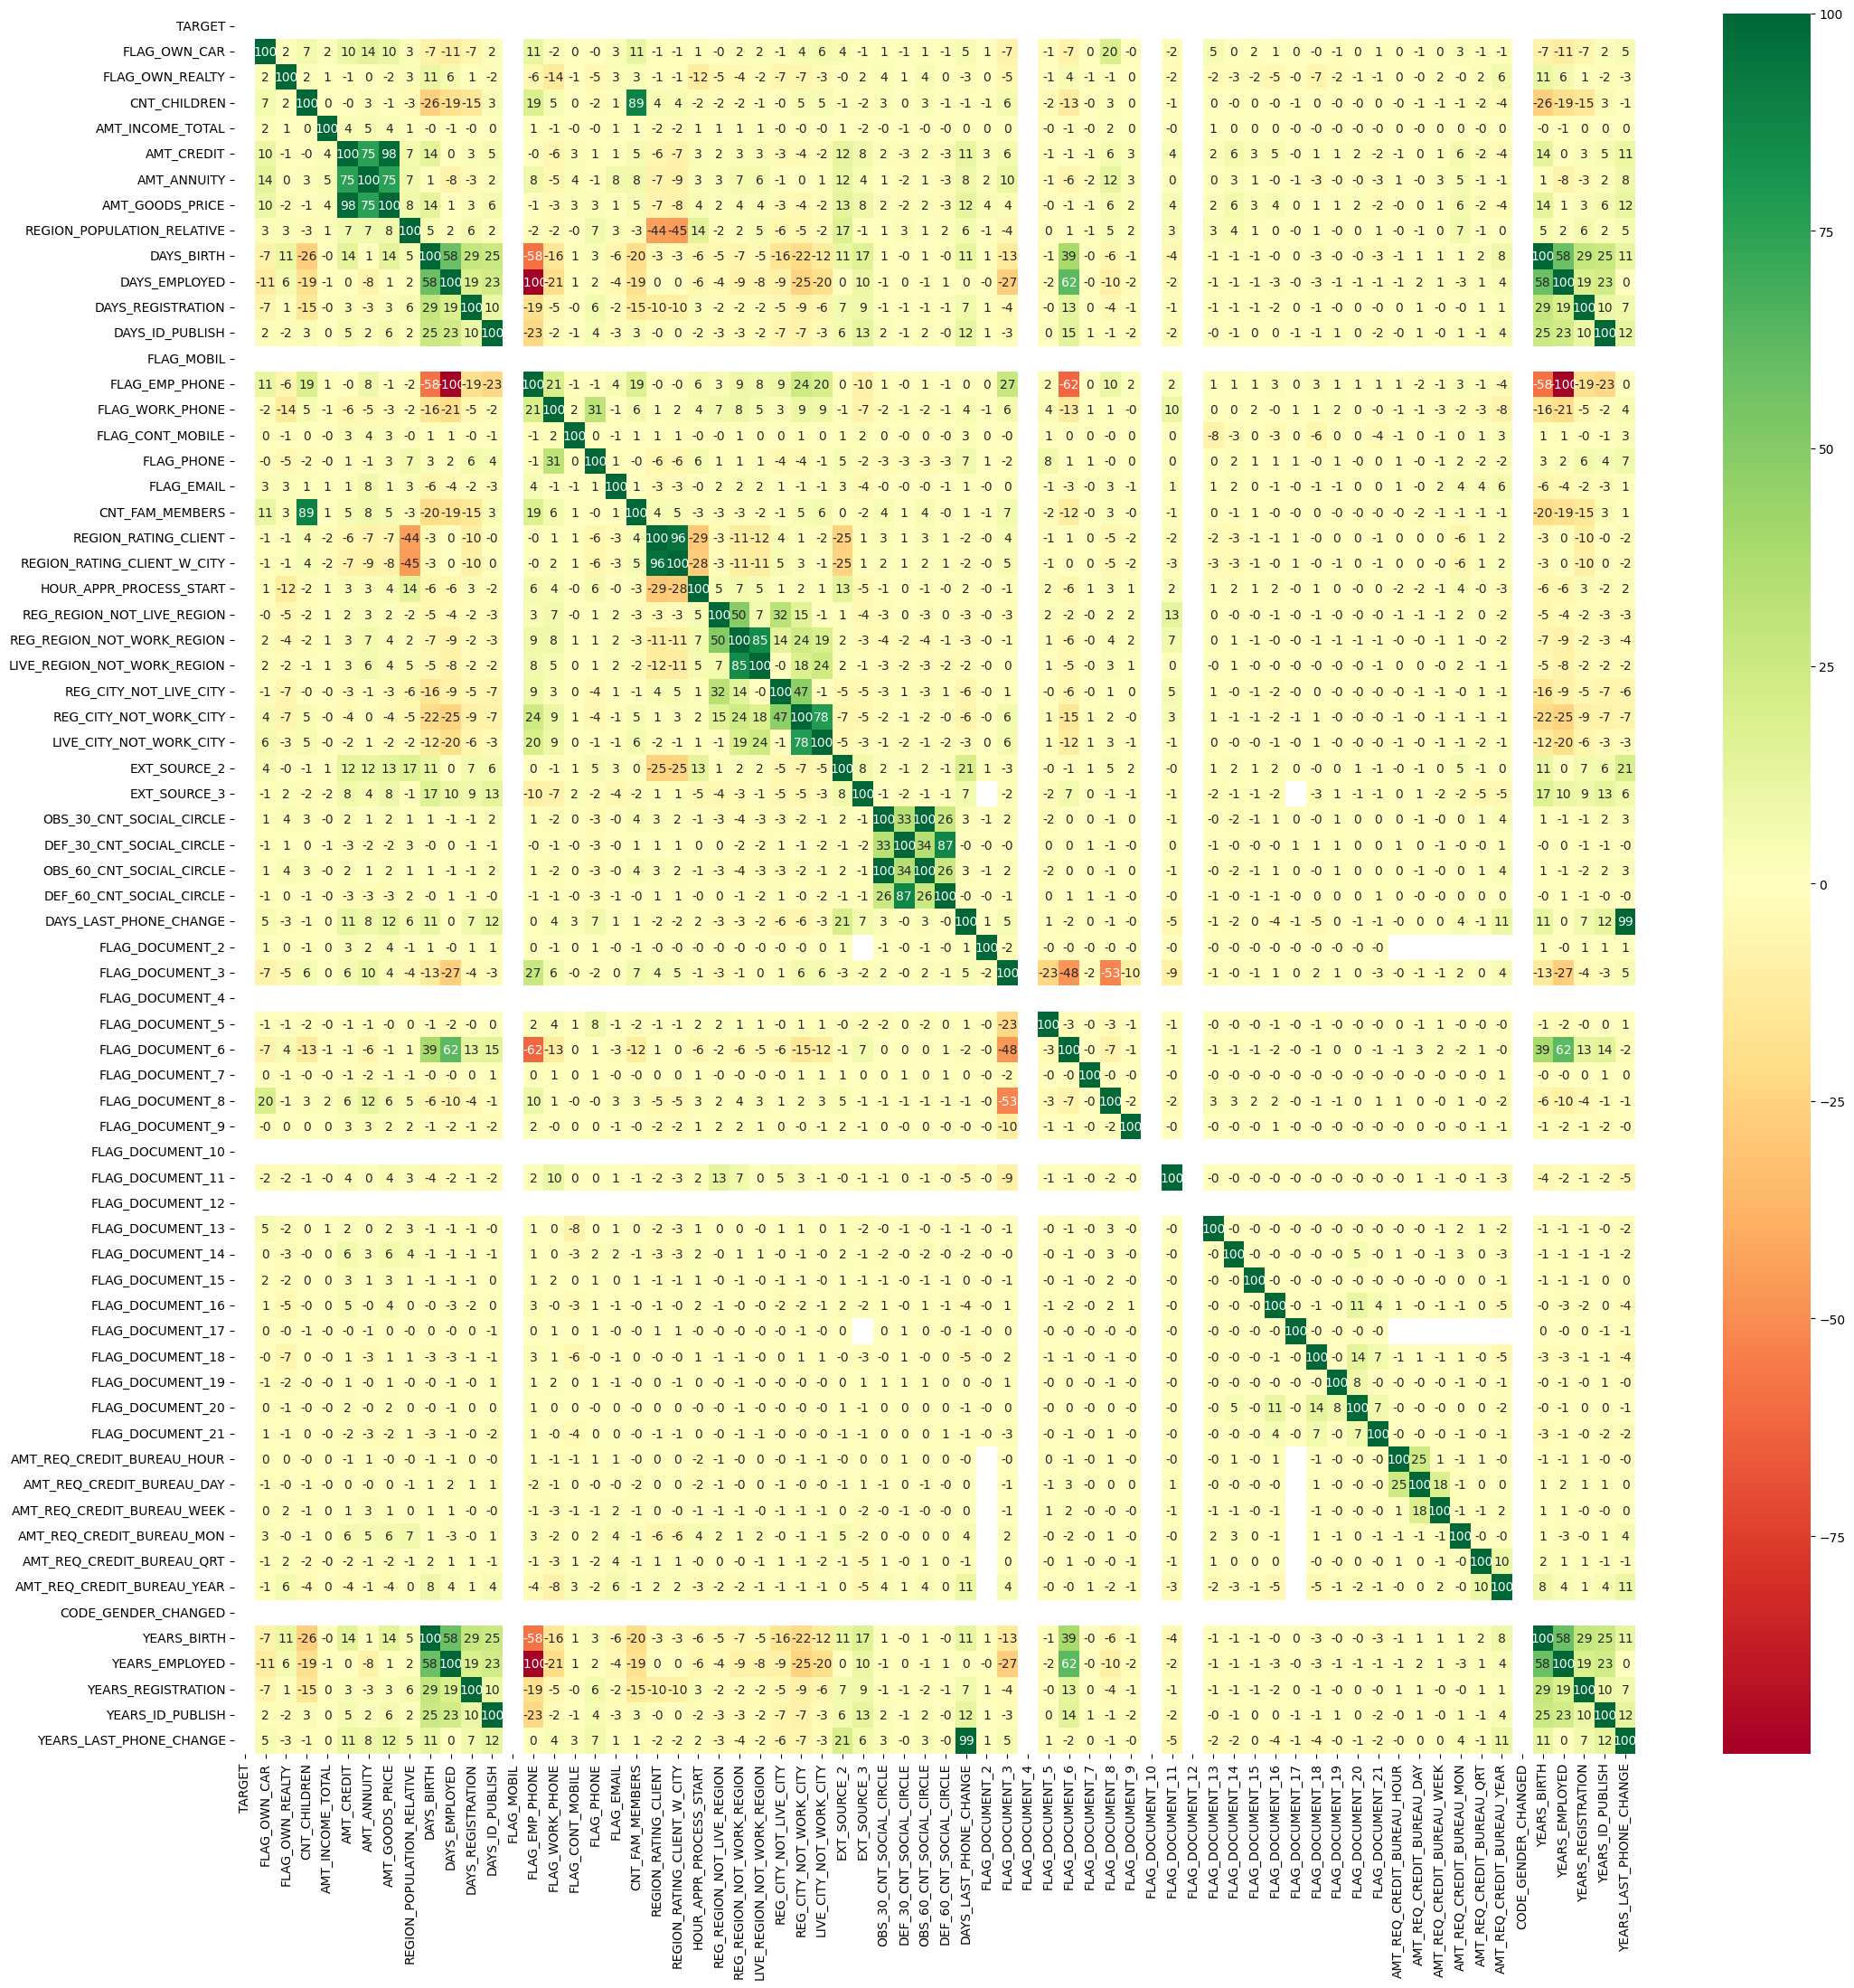

In [567]:
plt.figure(figsize = (25,25))
sns.heatmap(data = corr_df1*100, annot = True, cmap = "RdYlGn", cbar = True, fmt='.0f')
plt.show()

Створимо теплову карту для перегляду кореляцій вище 80% і 99,99%

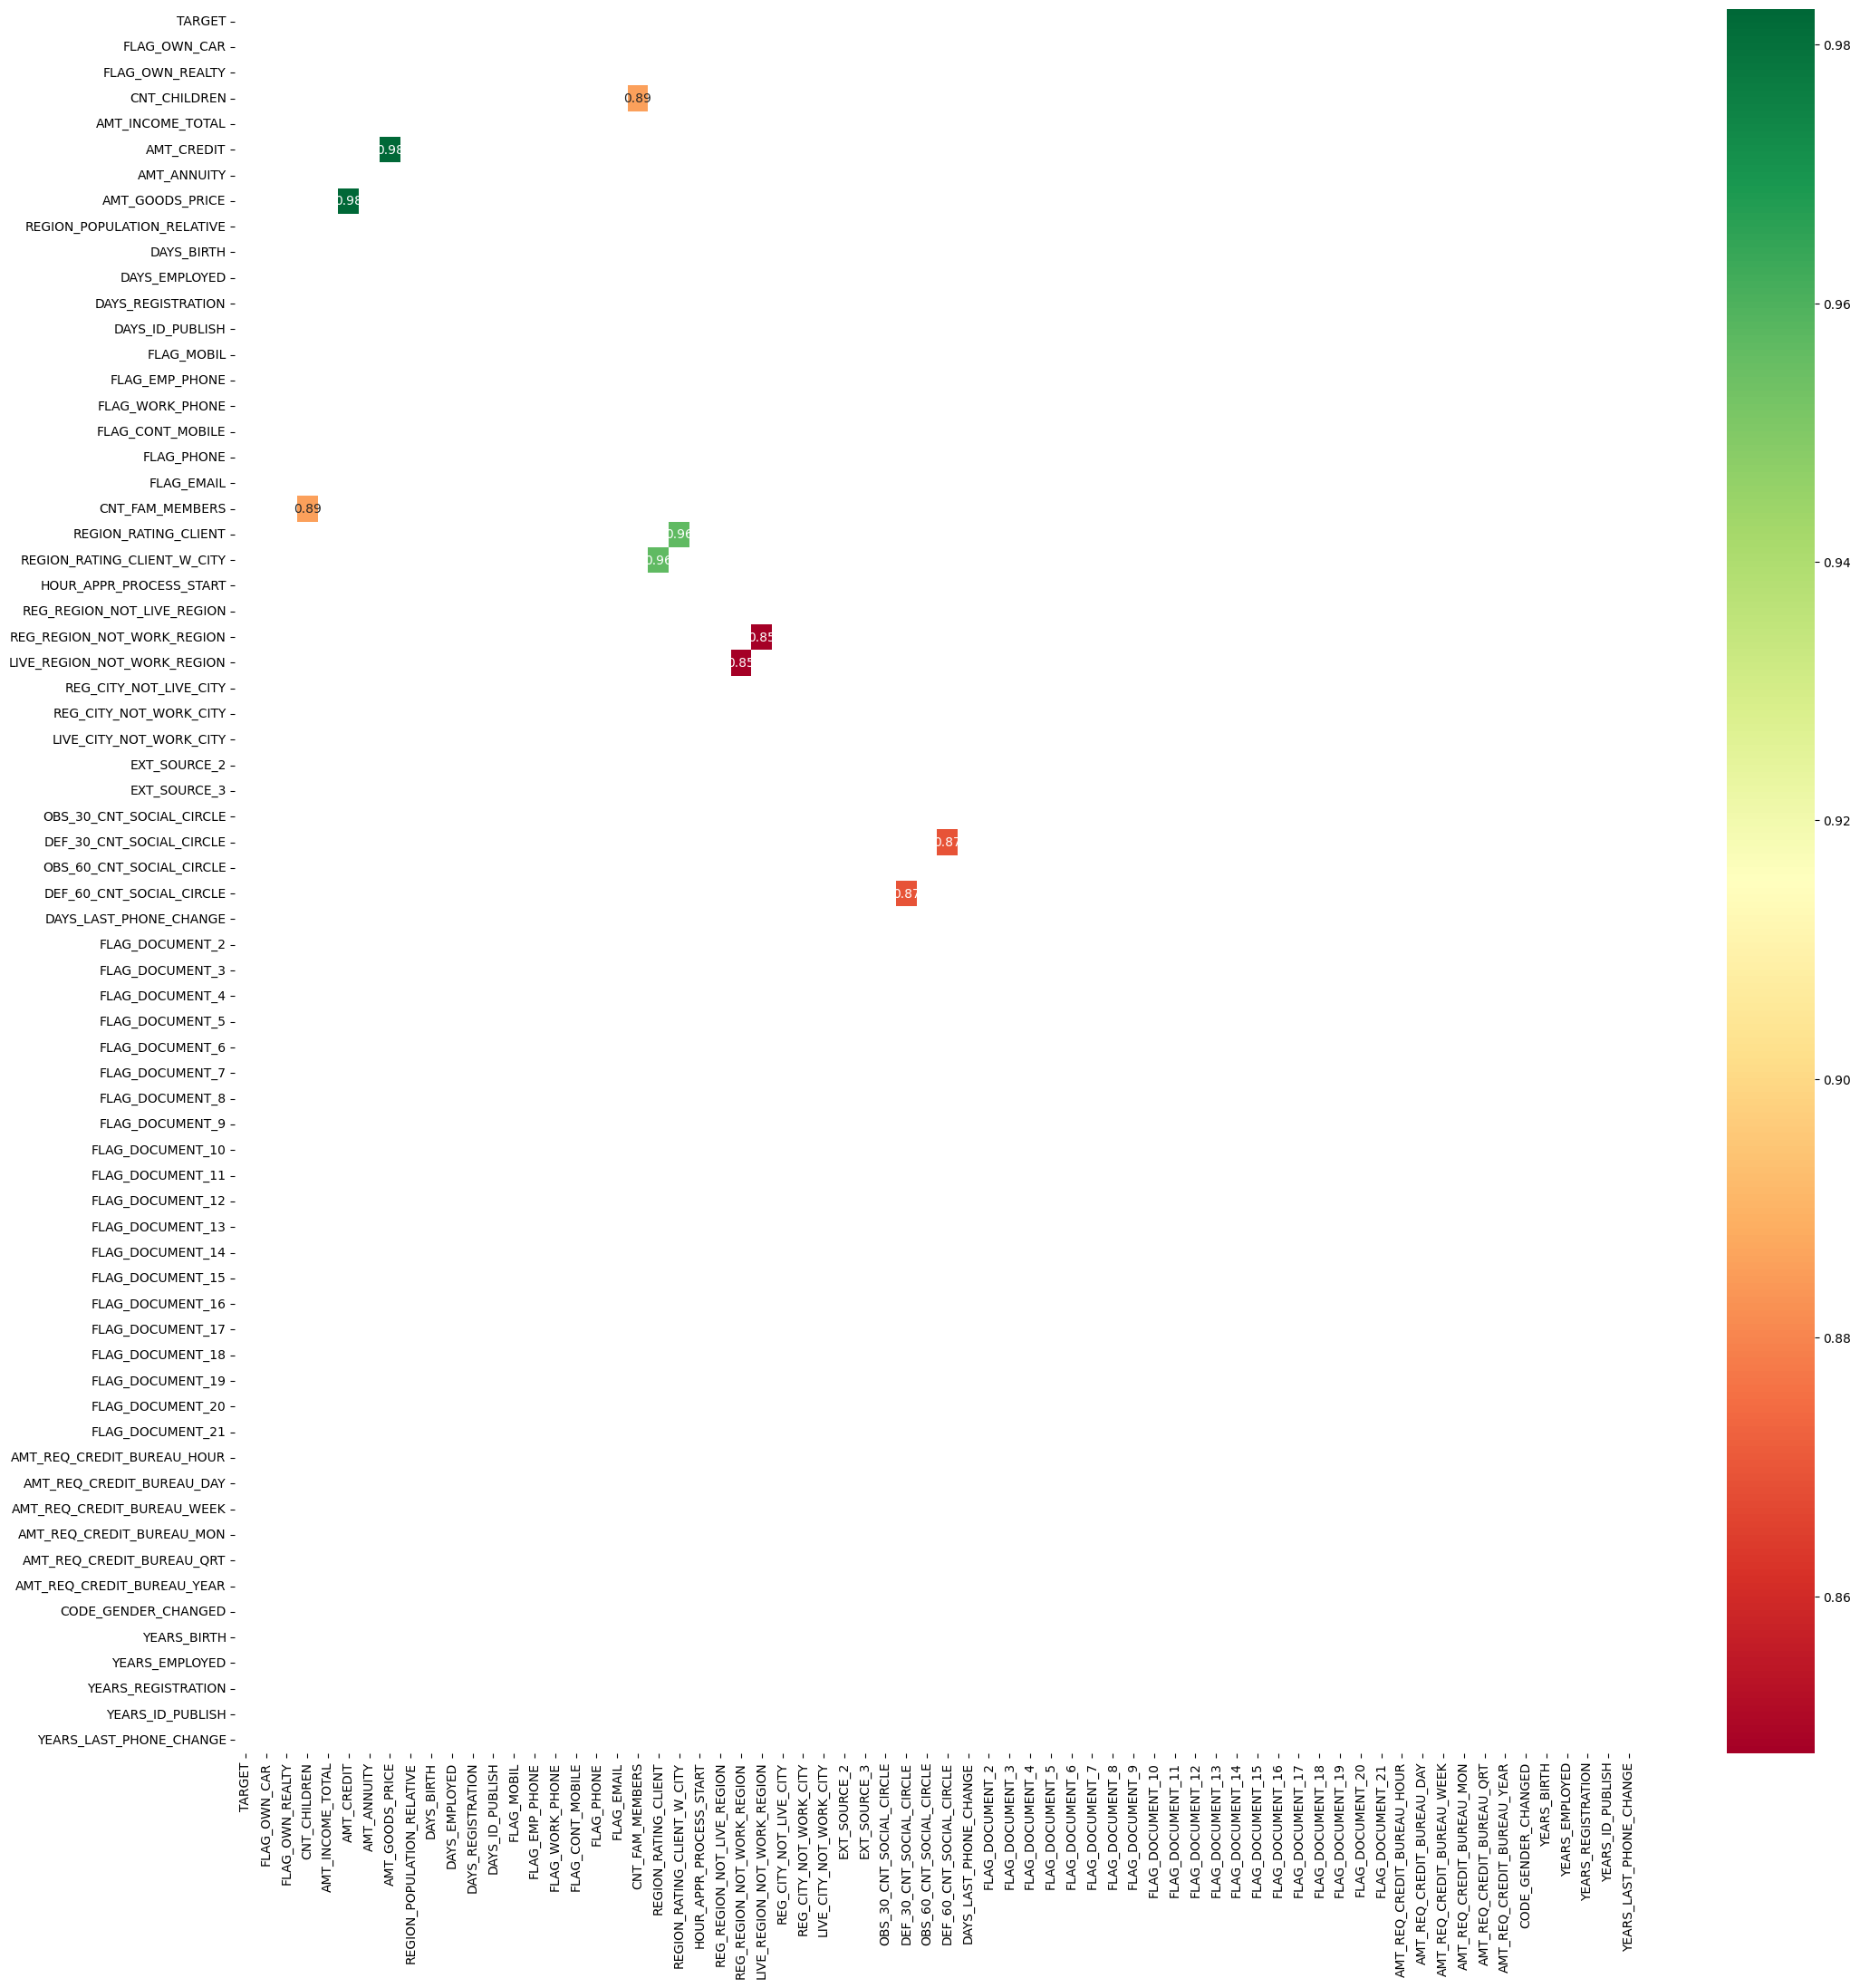

In [568]:
plt.figure(figsize = (25,25))
sns.heatmap(data = corr_df1[(corr_df1 >= 0.8) & (corr_df1 < 0.99)], annot = True, cmap = "RdYlGn", cbar = True, fmt='.2f')
plt.show()

### Подивимось на 10 найкращих кореляцій для випадків із платіжними труднощами

In [569]:
corr_df1[corr_df1 <= 0.99].unstack().sort_values(ascending = False).head(22)

AMT_GOODS_PRICE              AMT_CREDIT                    0.98
AMT_CREDIT                   AMT_GOODS_PRICE               0.98
REGION_RATING_CLIENT         REGION_RATING_CLIENT_W_CITY   0.96
REGION_RATING_CLIENT_W_CITY  REGION_RATING_CLIENT          0.96
CNT_CHILDREN                 CNT_FAM_MEMBERS               0.89
CNT_FAM_MEMBERS              CNT_CHILDREN                  0.89
DEF_30_CNT_SOCIAL_CIRCLE     DEF_60_CNT_SOCIAL_CIRCLE      0.87
DEF_60_CNT_SOCIAL_CIRCLE     DEF_30_CNT_SOCIAL_CIRCLE      0.87
REG_REGION_NOT_WORK_REGION   LIVE_REGION_NOT_WORK_REGION   0.85
LIVE_REGION_NOT_WORK_REGION  REG_REGION_NOT_WORK_REGION    0.85
LIVE_CITY_NOT_WORK_CITY      REG_CITY_NOT_WORK_CITY        0.78
REG_CITY_NOT_WORK_CITY       LIVE_CITY_NOT_WORK_CITY       0.78
AMT_GOODS_PRICE              AMT_ANNUITY                   0.75
AMT_ANNUITY                  AMT_GOODS_PRICE               0.75
AMT_CREDIT                   AMT_ANNUITY                   0.75
AMT_ANNUITY                  AMT_CREDIT                    0.75
FLAG_DOCUMENT_6              YEARS_EMPLOYED                0.62
YEARS_EMPLOYED               FLAG_DOCUMENT_6               0.62
DAYS_EMPLOYED                FLAG_DOCUMENT_6               0.62
FLAG_DOCUMENT_6              DAYS_EMPLOYED                 0.62
DAYS_BIRTH                   DAYS_EMPLOYED                 0.58
DAYS_EMPLOYED                DAYS_BIRTH                    0.58
dtype: float64

Оскільки у нас є комбінації, що повторюються, дивлячись на наведену вище таблицю і видаляючи дублі, ми отримуємо топ-10 кореляцій, як показано нижче:

- AMT_GOODS_PRICE -              AMT_CREDIT                    0.98
- REGION_RATING_CLIENT -         REGION_RATING_CLIENT_W_CITY   0.96
- CNT_FAM_MEMBERS -              CNT_CHILDREN                  0.89
- DEF_60_CNT_SOCIAL_CIRCLE -     DEF_30_CNT_SOCIAL_CIRCLE      0.87
- REG_REGION_NOT_WORK_REGION -   LIVE_REGION_NOT_WORK_REGION   0.85
- LIVE_CITY_NOT_WORK_CITY -      REG_CITY_NOT_WORK_CITY        0.78
- AMT_ANNUITY -                  AMT_GOODS_PRICE               0.75
- AMT_ANNUITY -                  AMT_CREDIT                    0.75
- DAYS_EMPLOYED -                FLAG_DOCUMENT_6               0.62
- DAYS_BIRTH -                   DAYS_EMPLOYED                 0.58

### Побудова кореляційної матриці для випадків із вчасними платежеми

In [570]:
df0.select_dtypes(include='number').shape

(282686, 68)

Є 67 числових стовпчиків. Створимо кореляційну матрицю `corr` для кращого перегляду результатів

In [571]:
corr_df0 = df0.select_dtypes(include='number').corr()

In [572]:
corr_df0.head()

TARGET  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
TARGET               NaN           NaN              NaN           NaN   
FLAG_OWN_CAR         NaN          1.00            -0.01          0.11   
FLAG_OWN_REALTY      NaN         -0.01             1.00         -0.00   
CNT_CHILDREN         NaN          0.11            -0.00          1.00   
AMT_INCOME_TOTAL     NaN          0.18             0.00          0.03   

                  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
TARGET                         NaN         NaN          NaN              NaN   
FLAG_OWN_CAR                  0.18        0.12         0.14             0.12   
FLAG_OWN_REALTY               0.00       -0.04        -0.01            -0.05   
CNT_CHILDREN                  0.03        0.00         0.02            -0.00   
AMT_INCOME_TOTAL              1.00        0.34         0.42             0.35   

                  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
TARGET                                   NaN         NaN            NaN   
FLAG_OWN_CAR                            0.04       -0.14          -0.16   
FLAG_OWN_REALTY                         0.01        0.12           0.07   
CNT_CHILDREN                           -0.02       -0.34          -0.25   
AMT_INCOME_TOTAL                        0.17       -0.06          -0.14   

                  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  \
TARGET                          NaN              NaN         NaN   
FLAG_OWN_CAR                  -0.09            -0.02       -0.00   
FLAG_OWN_REALTY                0.03            -0.01       -0.00   
CNT_CHILDREN                  -0.19             0.03        0.00   
AMT_INCOME_TOTAL              -0.06            -0.02        0.00   

                  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
TARGET                       NaN              NaN               NaN   
FLAG_OWN_CAR                0.16             0.01             -0.01   
FLAG_OWN_REALTY            -0.07            -0.11              0.01   
CNT_CHILDREN                0.24             0.06             -0.00   
AMT_INCOME_TOTAL            0.14            -0.03             -0.02   

                  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
TARGET                   NaN         NaN              NaN   
FLAG_OWN_CAR           -0.01        0.03             0.15   
FLAG_OWN_REALTY        -0.04        0.03             0.01   
CNT_CHILDREN           -0.03        0.02             0.88   
AMT_INCOME_TOTAL        0.00        0.08             0.03   

                  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
TARGET                             NaN                          NaN   
FLAG_OWN_CAR                     -0.02                        -0.02   
FLAG_OWN_REALTY                   0.00                         0.00   
CNT_CHILDREN                      0.02                         0.02   
AMT_INCOME_TOTAL                 -0.19                        -0.20   

                  HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
TARGET                                NaN                         NaN   
FLAG_OWN_CAR                         0.01                       -0.00   
FLAG_OWN_REALTY                     -0.10                       -0.03   
CNT_CHILDREN                        -0.01                       -0.01   
AMT_INCOME_TOTAL                     0.08                        0.07   

                  REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
TARGET                                   NaN                          NaN   
FLAG_OWN_CAR                            0.04                         0.05   
FLAG_OWN_REALTY                        -0.03                        -0.02   
CNT_CHILDREN                            0.01                         0.02   
AMT_INCOME_TOTAL                        0.14                         0.13   

                  REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
TARGET                               NaN       

Створимо теплову карту для перегляду кореляцій вище 80% і 99,99%

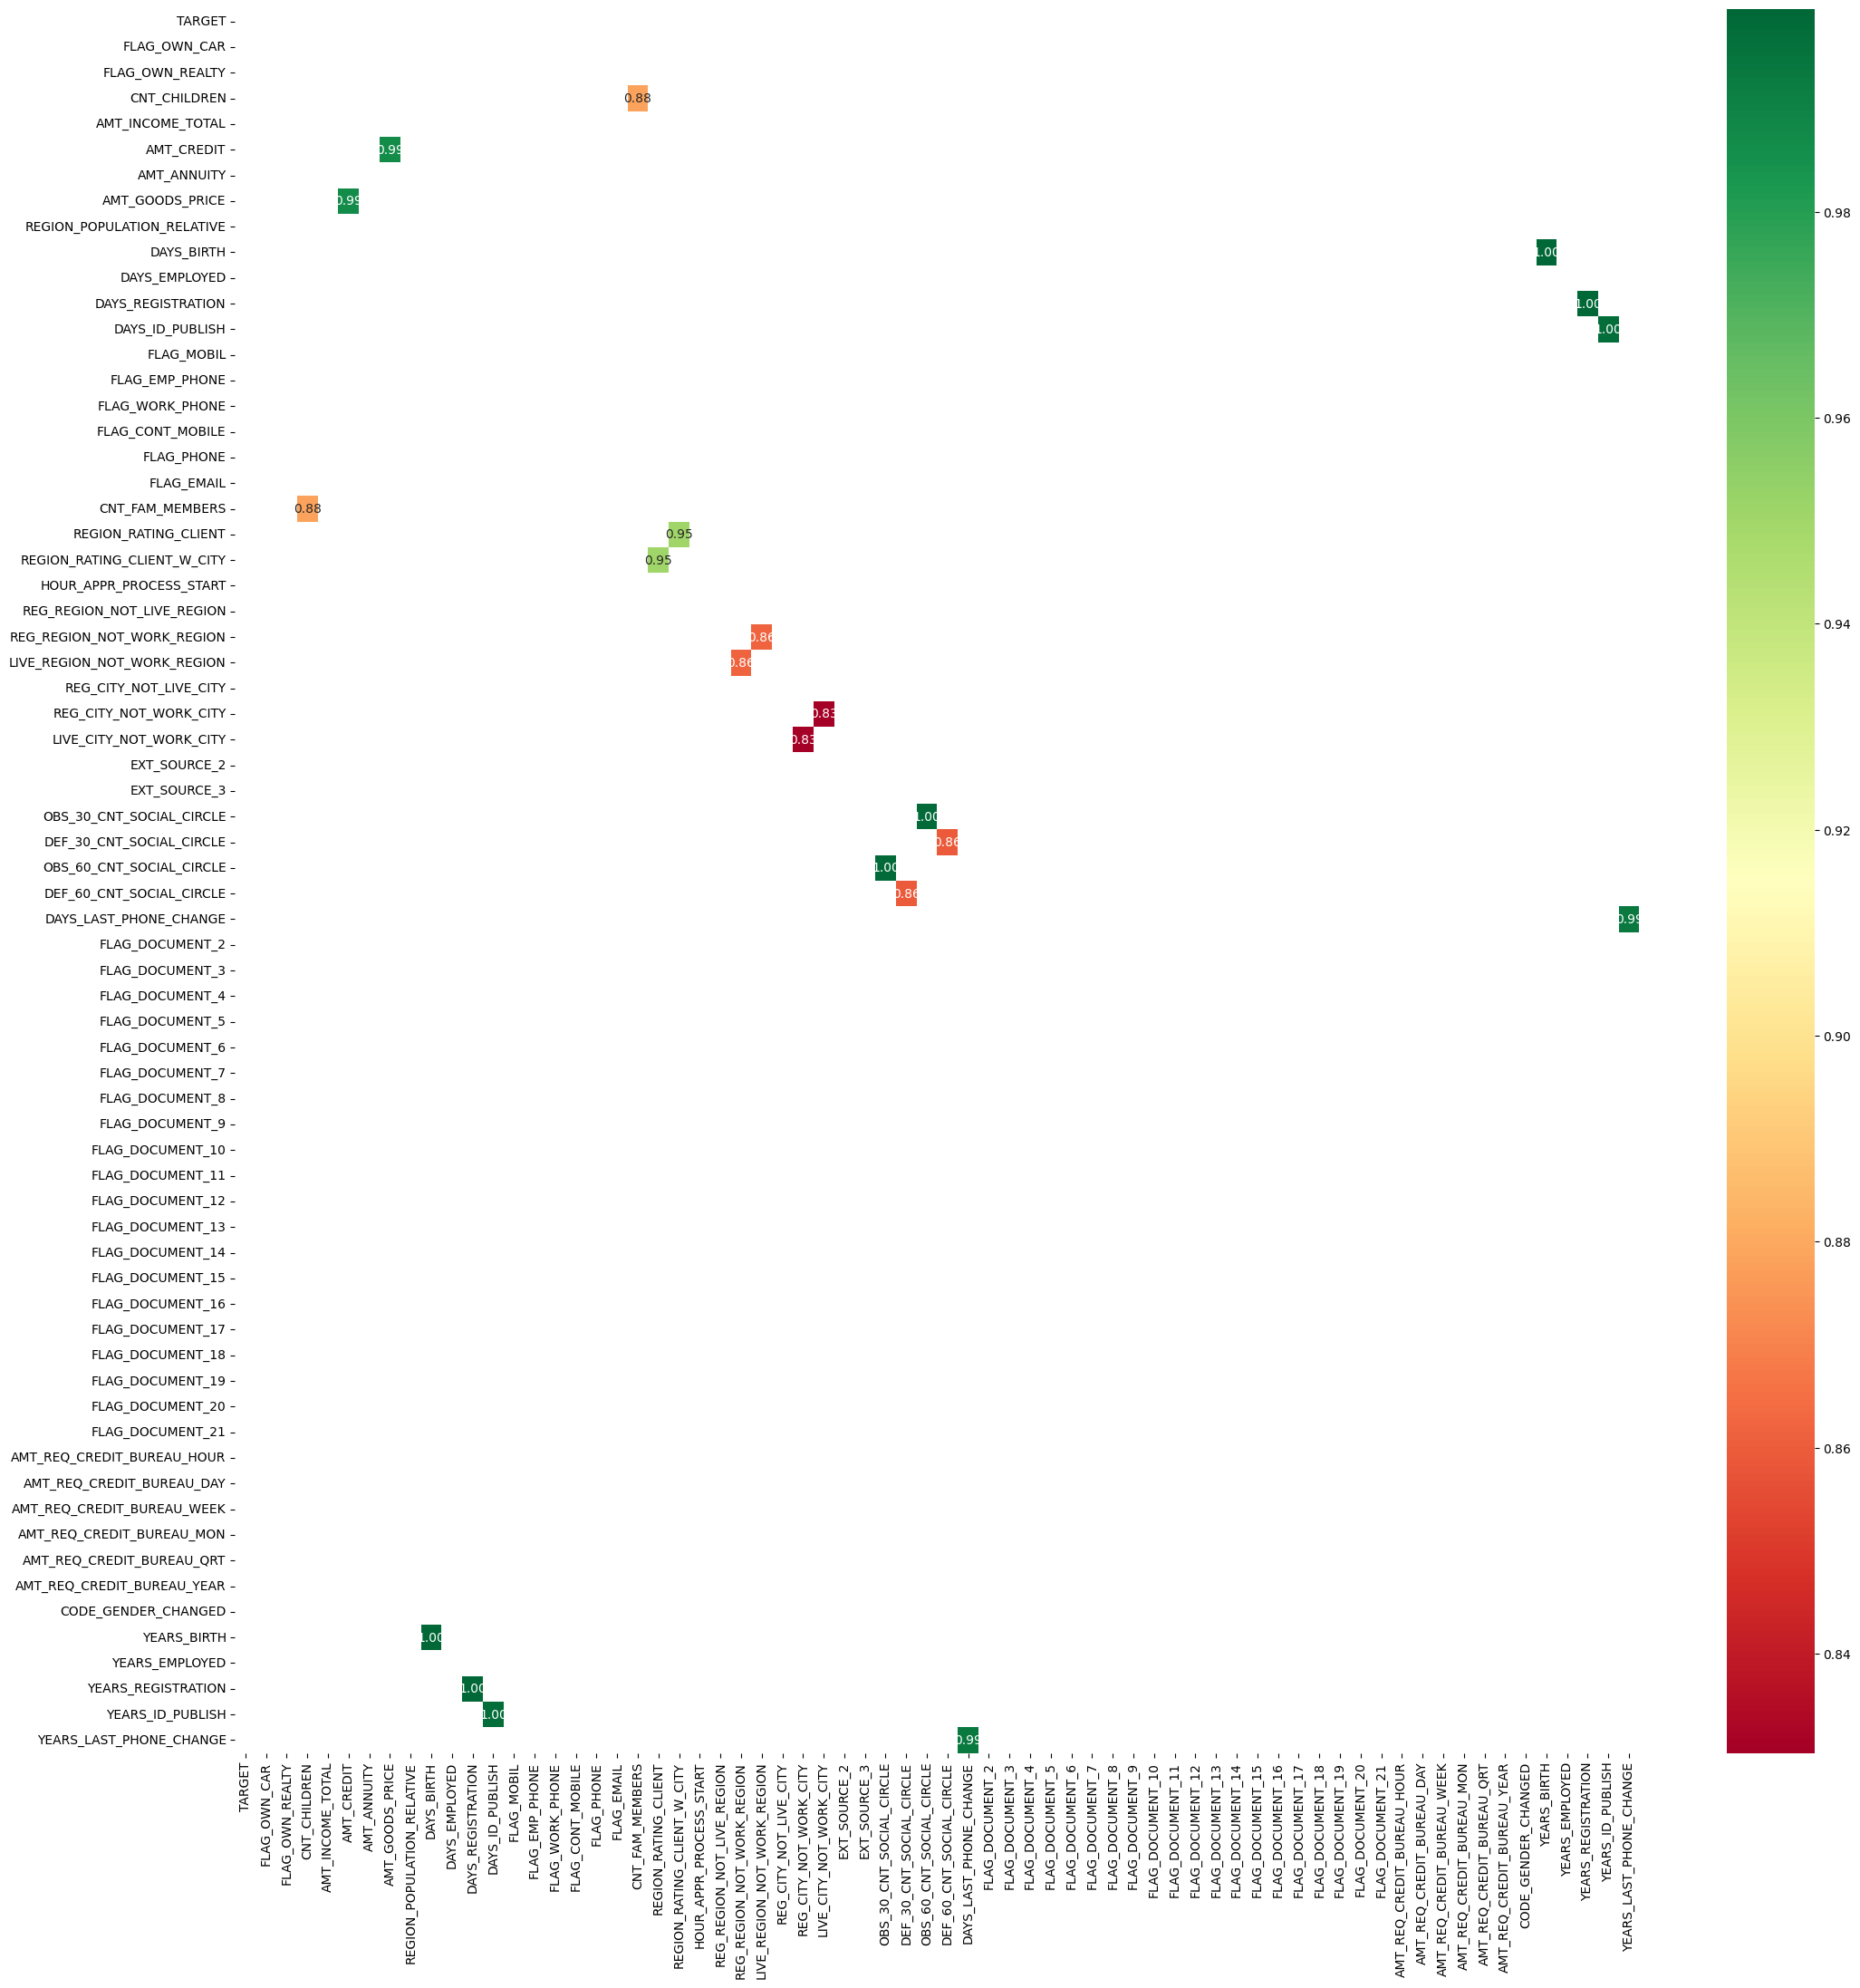

In [573]:
plt.figure(figsize = (25,25))
sns.heatmap(data = corr_df0[(corr_df0 >= 0.8) & (corr_df0 < 0.9999)], annot = True, cmap = "RdYlGn", cbar = True, fmt='.2f')
plt.show()

### Подивимось на 10 найкращих кореляцій для вчасних платежів

In [574]:
corr_df0[corr_df0 <= 0.99].unstack().sort_values(ascending = False).head(28)

AMT_GOODS_PRICE              AMT_CREDIT                    0.99
AMT_CREDIT                   AMT_GOODS_PRICE               0.99
REGION_RATING_CLIENT_W_CITY  REGION_RATING_CLIENT          0.95
REGION_RATING_CLIENT         REGION_RATING_CLIENT_W_CITY   0.95
CNT_CHILDREN                 CNT_FAM_MEMBERS               0.88
CNT_FAM_MEMBERS              CNT_CHILDREN                  0.88
REG_REGION_NOT_WORK_REGION   LIVE_REGION_NOT_WORK_REGION   0.86
LIVE_REGION_NOT_WORK_REGION  REG_REGION_NOT_WORK_REGION    0.86
DEF_30_CNT_SOCIAL_CIRCLE     DEF_60_CNT_SOCIAL_CIRCLE      0.86
DEF_60_CNT_SOCIAL_CIRCLE     DEF_30_CNT_SOCIAL_CIRCLE      0.86
LIVE_CITY_NOT_WORK_CITY      REG_CITY_NOT_WORK_CITY        0.83
REG_CITY_NOT_WORK_CITY       LIVE_CITY_NOT_WORK_CITY       0.83
AMT_ANNUITY                  AMT_GOODS_PRICE               0.78
AMT_GOODS_PRICE              AMT_ANNUITY                   0.78
AMT_CREDIT                   AMT_ANNUITY                   0.77
AMT_ANNUITY                  AMT_CREDIT                    0.77
DAYS_EMPLOYED                DAYS_BIRTH                    0.63
DAYS_BIRTH                   DAYS_EMPLOYED                 0.63
                             YEARS_EMPLOYED                0.63
YEARS_EMPLOYED               DAYS_BIRTH                    0.63
YEARS_BIRTH                  DAYS_EMPLOYED                 0.63
DAYS_EMPLOYED                YEARS_BIRTH                   0.63
YEARS_BIRTH                  YEARS_EMPLOYED                0.63
YEARS_EMPLOYED               YEARS_BIRTH                   0.63
                             FLAG_DOCUMENT_6               0.60
FLAG_DOCUMENT_6              YEARS_EMPLOYED                0.60
DAYS_EMPLOYED                FLAG_DOCUMENT_6               0.60
FLAG_DOCUMENT_6              DAYS_EMPLOYED                 0.60
dtype: float64

Оскільки у нас є комбінації, що повторюються, дивлячись на наведену вище таблицю і видаляючи дублі, ми отримуємо топ-10 кореляцій, як показано нижче:

- AMT_GOODS_PRICE              AMT_CREDIT                    0.99
- REGION_RATING_CLIENT         REGION_RATING_CLIENT_W_CITY   0.95
- CNT_FAM_MEMBERS              CNT_CHILDREN                  0.88
- REG_REGION_NOT_WORK_REGION   LIVE_REGION_NOT_WORK_REGION   0.86
- DEF_30_CNT_SOCIAL_CIRCLE     DEF_60_CNT_SOCIAL_CIRCLE      0.86
- LIVE_CITY_NOT_WORK_CITY      REG_CITY_NOT_WORK_CITY        0.83
- AMT_ANNUITY                  AMT_GOODS_PRICE               0.78
- AMT_ANNUITY                  AMT_CREDIT                    0.77
- DAYS_BIRTH                   DAYS_EMPLOYED                 0.63
- DAYS_EMPLOYED                FLAG_DOCUMENT_6               0.60

### Порівняємо 10 найкращих кореляцій між випадками із платіжними труднощами та вчасними платежами

**Спостереження**

- Топ-10 кореляцій для Труднощів з оплатою та Вчасних платежів однакові, за винятком незначних відмінностей у відсотках кореляції
- Найвища кореляція для комбінації `AMT_GOODS_PRICE` та `AMT_CREDIT`.
- Для набору даних "Труднощі з оплатою" кореляція між `AMT_GOODS_PRICE` та `AMT_CREDIT` становить 0,98
- Для набору даних "Вчасні платежі" кореляція між `AMT_GOODS_PRICE` та `AMT_CREDIT` становить 0,99

# Одновимірний аналіз числових змінних

### Аналіз стовпця `AMT_CREDIT`

#### Пошук викидів в `AMT_CREDIT` при випадках із платіжними труднощами

Розрахунок IQR (Inter Quartile range)

In [575]:
Q1 = df1['AMT_CREDIT'].quantile(0.25)
Q3 = df1['AMT_CREDIT'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

448915.5


Значення *до* (Q1 - 1.5 * IQR) та *після* (Q3 + 1.5 * IQR) є викидами.

In [576]:
Min_value1 = (Q1 - 1.5 * IQR)
Max_value1 = (Q3 + 1.5 * IQR)
print("Мінімальне значення, до якого існують викиди: {}".format(Min_value1))
print("Максимальне значення, після якого існують викиди: {}".format(Max_value1))

Мінімальне значення, до якого існують викиди: -388973.25
Максимальне значення, після якого існують викиди: 1406688.75


#### Пошук викидів в `AMT_CREDIT` при випадках із вчасними оплатами

Розрахунок IQR (Inter Quartile range)

In [577]:
Q1 = df0['AMT_CREDIT'].quantile(0.25)
Q3 = df0['AMT_CREDIT'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

540000.0


Значення *до* (Q1 - 1.5 * IQR) та *після* (Q3 + 1.5 * IQR) є викидами.

In [578]:
Min_value0 = (Q1 - 1.5 * IQR)
Max_value0 = (Q3 + 1.5 * IQR)
print("Мінімальне значення, до якого існують викиди: {}".format(Min_value0))
print("Максимальне значення, після якого існують викиди: {}".format(Max_value0))

Мінімальне значення, до якого існують викиди: -540000.0
Максимальне значення, після якого існують викиди: 1620000.0


Видалення викидів і побудова діаграми розподілу

In [579]:
def kde_no_outliers(df0, df1, Max_value0, Max_value1, column):
  plt.figure(figsize = (14,6))
  sns.kdeplot(df1[df1[column] <= Max_value1][column],label = 'Payment difficulties')
  sns.kdeplot(df0[df0[column] <= Max_value0][column],label = 'On-Time Payments')
  plt.ticklabel_format(style='plain', axis='x')
  plt.xticks(rotation = 45)
  plt.legend()
  plt.show()

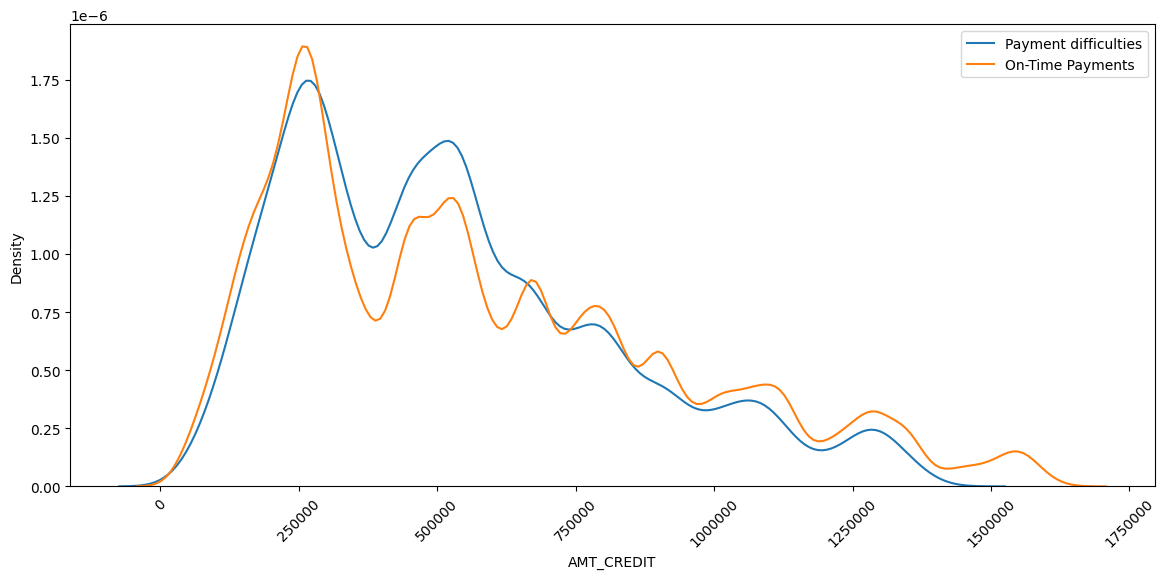

In [580]:
kde_no_outliers(df0, df1, Max_value0, Max_value1, 'AMT_CREDIT')

**Спостереження**

- Для `AMT_CREDIT` від 250000 до приблизно 650000 більше клієнтів мають труднощі з оплатою
- Для `AMT_CREDIT` > 750000 більше клієнтів, які вчасно здійснюють платежі

# ДЗ 5. Одновимірний аналіз числової колонки

Проведіть подібно до прикладу одновимірний аналіз (виявлення викидів, їх усунення ат побудова KDE-графіку) для числових змінних:

- YEARS_BIRTH;
- AMT_GOODS_PRICE;
- DAYS_EMPLOYED.

Опціонально:

- CNT_CHILDREN;
- AMT_INCOME_TOTAL.

Для цього винесіть функціонал для аналізу у функцію та викличіть функцію для кожної двійки змінних.

Зробіть висновки з аналізу.

## Функція для автоматизованого одновимірного аналізу числовох колонки на викиди

In [581]:

def analyze_column_outliers(df, column_name, group_name):
    """
    Аналізує викиди в заданому стовпці DataFrame для вказаної групи.

    Args:
        df: DataFrame pandas, що містить дані.
        column_name: Назва стовпця для аналізу.
        group_name: Назва групи для ідентифікації у виводі.

    Returns:
        tuple: (min_value, max_value) - межі для викидів. Виводить результати аналізу на екран.
        Повертає None у випадку помилки.
    """
    if not isinstance(df, pd.DataFrame):
        print("Помилка: df має бути DataFrame.")
        return None

    if column_name not in df.columns:
        print(f"Помилка: Стовпець '{column_name}' відсутній у DataFrame.")
        return None

    if not pd.api.types.is_numeric_dtype(df[column_name]):
        print(f"Помилка: Стовпець '{column_name}' повинен бути числовим.")
        return None

    try:
        Q1 = df[column_name].quantile(0.25)
        Q3 = df[column_name].quantile(0.75)
        IQR = Q3 - Q1

        min_value = Q1 - 1.5 * IQR
        max_value = Q3 + 1.5 * IQR

        print(f"Аналіз '{column_name}' для групи: {group_name}")
        print(f"IQR: {IQR}")
        print(f"Мінімальне значення, до якого існують викиди: {min_value}")
        print(f"Максимальне значення, після якого існують викиди: {max_value}")
        print("-" * 30)

        return min_value, max_value

    except Exception as e:
        print(f"Виникла помилка під час аналізу: {e}")
        return None


### Аналіз стовпця `YEARS_BIRTH`

In [632]:
Min_value1, Max_value1 = analyze_column_outliers(df1, "YEARS_BIRTH", "1")
print(Min_value1, Max_value1)

Аналіз 'YEARS_BIRTH' для групи: 1
IQR: 18.0
Мінімальне значення, до якого існують викиди: 4.0
Максимальне значення, після якого існують викиди: 76.0
------------------------------
4.0 76.0


In [633]:
Min_value0, Max_value0 = analyze_column_outliers(df0, "YEARS_BIRTH", "0")
print(Min_value0, Max_value0)

Аналіз 'YEARS_BIRTH' для групи: 0
IQR: 20.0
Мінімальне значення, до якого існують викиди: 4.0
Максимальне значення, після якого існують викиди: 84.0
------------------------------
4.0 84.0


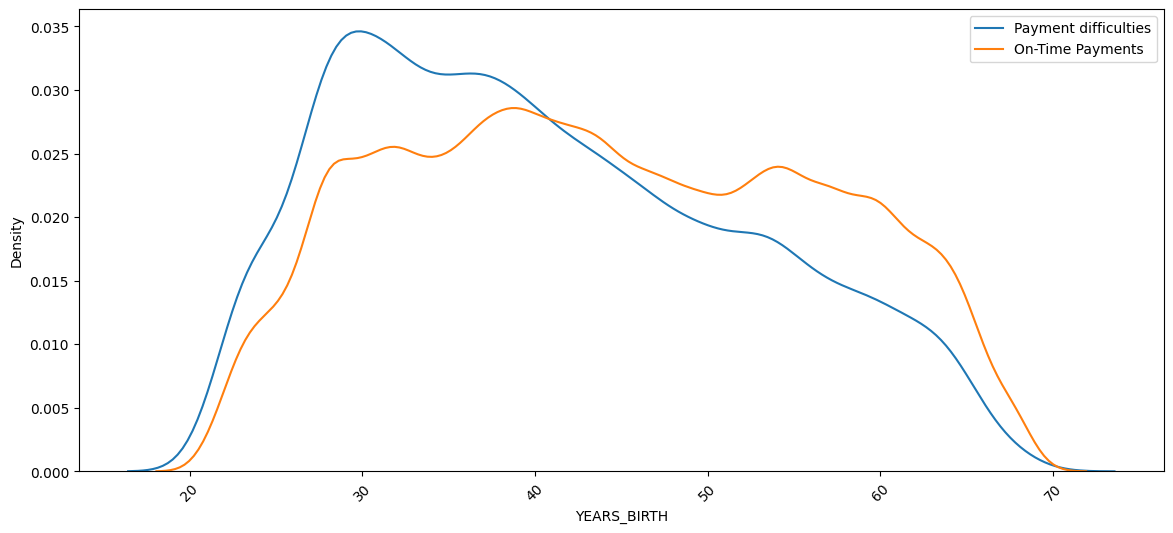

In [634]:
kde_no_outliers(df0, df1, Max_value0, Max_value1, 'YEARS_BIRTH')

**Спостереження**

- Для `YEARS_BIRTH` < 41 більше клієнтів мають платіжні труднощі.
- Для `YEARS_BIRTH` починаючи приблизно від 41 року більше клієнтів виплачують кредит вчасно.


### Аналіз стовпця `AMT_GOODS_PRICE`

In [626]:
Min_value1, Max_value1 = analyze_column_outliers(df1, "AMT_GOODS_PRICE", "1")
print(Min_value1, Max_value1)

Аналіз 'AMT_GOODS_PRICE' для групи: 1
IQR: 436500.0
Мінімальне значення, до якого існують викиди: -416250.0
Максимальне значення, після якого існують викиди: 1329750.0
------------------------------
-416250.0 1329750.0


In [627]:
Min_value0, Max_value0 = analyze_column_outliers(df0, "AMT_GOODS_PRICE", "0")
print(Min_value0, Max_value0)

Аналіз 'AMT_GOODS_PRICE' для групи: 0
IQR: 446502.375
Мінімальне значення, до якого існують викиди: -431253.5625
Максимальне значення, після якого існують викиди: 1354755.9375
------------------------------
-431253.5625 1354755.9375


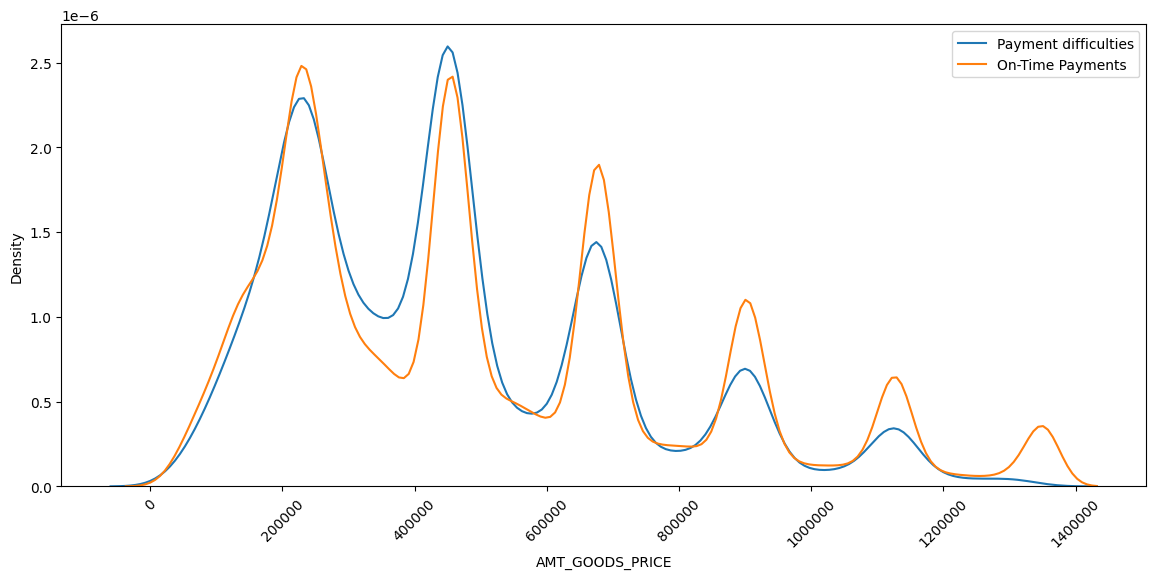

In [628]:
kde_no_outliers(df0, df1, Max_value0, Max_value1, 'AMT_GOODS_PRICE')

**Спостереження**

- Для `AMT_GOODS_PRICE` від 250000 до приблизно 650000 більше клієнтів мають труднощі з оплатою
- Для `AMT_GOODS_PRICE` > 750000 більше клієнтів, які вчасно здійснюють платежі

### Аналіз стовпця `DAYS_EMPLOYED`

In [588]:
Min_value1, Max_value1 = analyze_column_outliers(df1, "DAYS_EMPLOYED", "1")
print(Min_value1, Max_value1)

Аналіз 'DAYS_EMPLOYED' для групи: 1
IQR: 2603.0
Мінімальне значення, до якого існують викиди: -3227.5
Максимальне значення, після якого існують викиди: 7184.5
------------------------------
-3227.5 7184.5


In [589]:
Min_value0, Max_value0 = analyze_column_outliers(df0, "DAYS_EMPLOYED", "0")
print(Min_value0, Max_value0)

Аналіз 'DAYS_EMPLOYED' для групи: 0
IQR: 5107.0
Мінімальне значення, до якого існують викиди: -6693.5
Максимальне значення, після якого існують викиди: 13734.5
------------------------------
-6693.5 13734.5


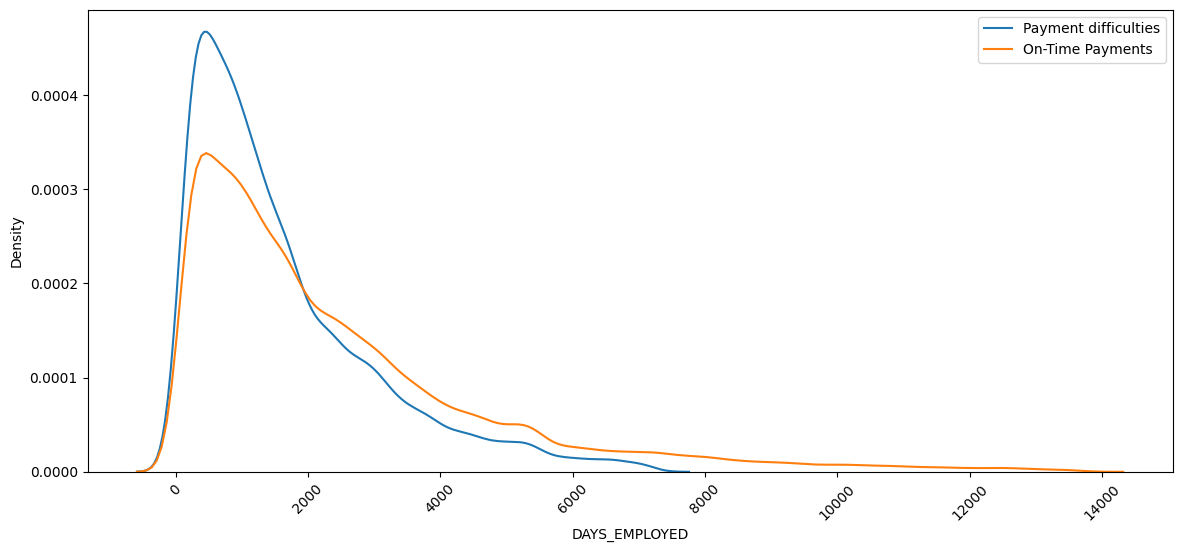

In [590]:
kde_no_outliers(df0, df1, Max_value0, Max_value1, 'DAYS_EMPLOYED')

**Спостереження**

- Для `DAYS_EMPLOYED` люди, які працюють до 2000 днів, мають більші труднощі з оплатою.
- Для `DAYS_EMPLOYED` > 2000 більше клієнтів, які вчасно здійснюють платежі.

### Аналіз стовпця `CNT_CHILDREN`

In [629]:
Min_value1, Max_value1 = analyze_column_outliers(df1, "CNT_CHILDREN", "1")
print(Min_value1, Max_value1)

Аналіз 'CNT_CHILDREN' для групи: 1
IQR: 1.0
Мінімальне значення, до якого існують викиди: -1.5
Максимальне значення, після якого існують викиди: 2.5
------------------------------
-1.5 2.5


In [630]:
Min_value0, Max_value0 = analyze_column_outliers(df0, "CNT_CHILDREN", "0")
print(Min_value0, Max_value0)

Аналіз 'CNT_CHILDREN' для групи: 0
IQR: 1.0
Мінімальне значення, до якого існують викиди: -1.5
Максимальне значення, після якого існують викиди: 2.5
------------------------------
-1.5 2.5


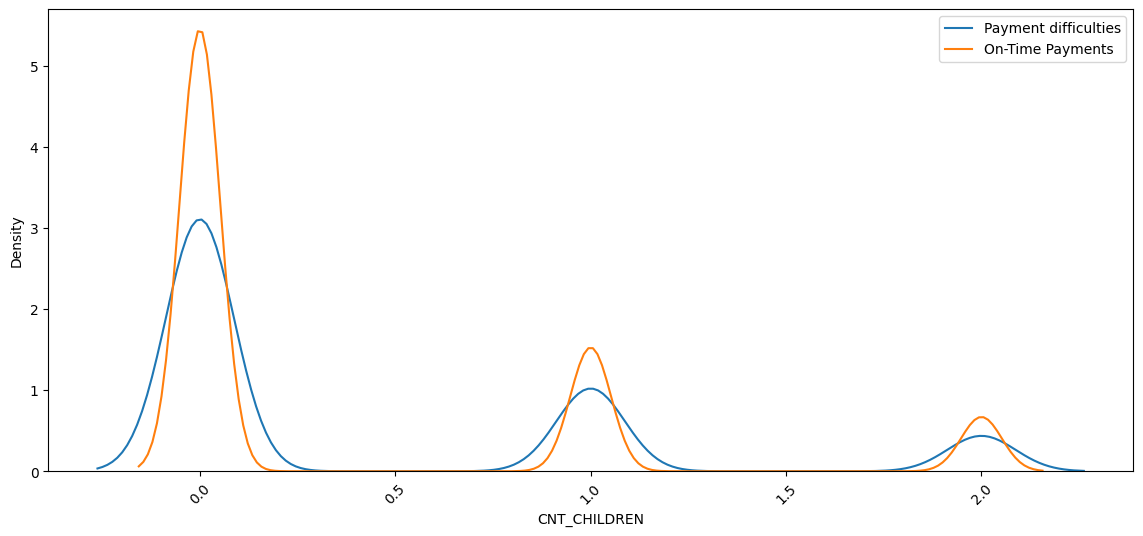

In [631]:
kde_no_outliers(df0, df1, Max_value0, Max_value1, 'CNT_CHILDREN')

**Спостереження**

- Для `CNT_CHILDREN` графік показує, що відсутність дітей корелює з більш своєчасними платежами. Люди без дітей значно частіше здійснюють платежі вчасно, ніж ті, хто має дітей. Зі збільшенням кількості дітей ця різниця між групами зменшується.
- скільки б у кієнта не було дітей, ймовірність, що він виплатить кредит вчасно, більша, ніж не виплатить.

### Аналіз стовпця `AMT_INCOME_TOTAL`

In [594]:
Min_value1, Max_value1 = analyze_column_outliers(df1, "AMT_INCOME_TOTAL", "1")
print(Min_value1, Max_value1)

Аналіз 'AMT_INCOME_TOTAL' для групи: 1
IQR: 90000.0
Мінімальне значення, до якого існують викиди: -22500.0
Максимальне значення, після якого існують викиди: 337500.0
------------------------------
-22500.0 337500.0


In [595]:
Min_value0, Max_value0 = analyze_column_outliers(df0, "AMT_INCOME_TOTAL", "0")
print(Min_value0, Max_value0)

Аналіз 'AMT_INCOME_TOTAL' для групи: 0
IQR: 90000.0
Мінімальне значення, до якого існують викиди: -22500.0
Максимальне значення, після якого існують викиди: 337500.0
------------------------------
-22500.0 337500.0


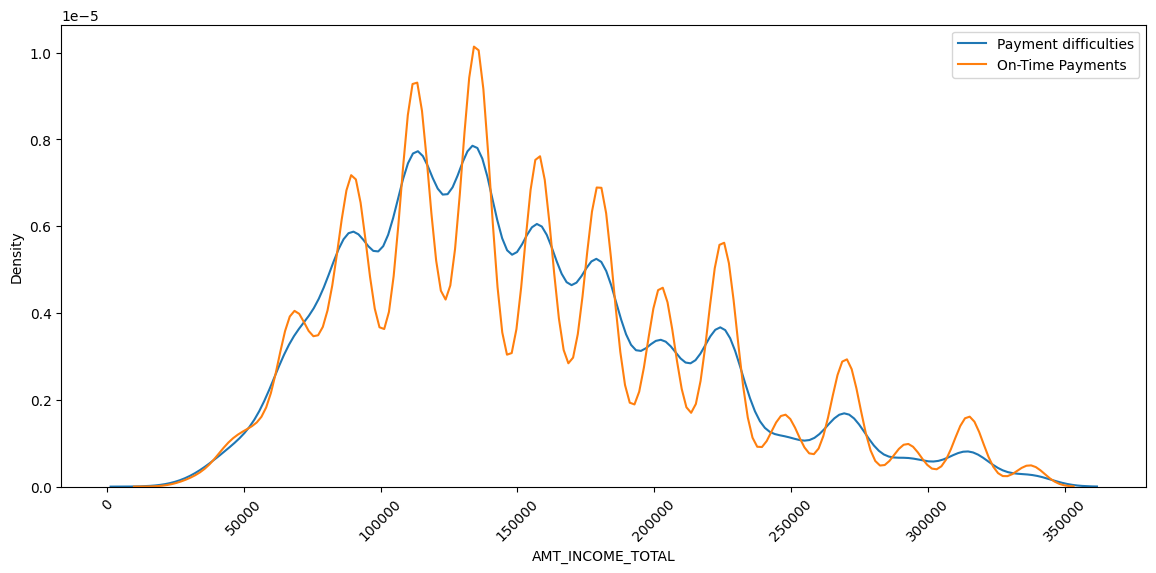

In [596]:
kde_no_outliers(df0, df1, Max_value0, Max_value1, 'AMT_INCOME_TOTAL')

**Спостереження**

Наявність кількох піків свідчить про те, що розподіл доходів є складним і неоднорідним.

- Однак можна помітити, що обидві групи людей мають низьку щільність для `AMT_INCOME_TOTAL` близько 0–50,000
- Помітно більше піків для категорії "On-Time Payments" у вищих доходах (200,000+), що може свідчити про тенденцію: клієнти з високими доходами частіше виплачують борги вчасно.

# Двовимірний/Багатовимірний аналіз

## Неперервні vs неперервні змінні

### Аналіз стовпця `AMT_GOODS_PRICE` vs `AMT_CREDIT`

**Пошук викидів для ствопця `AMT_GOODS_PRICE ` для групи із платіжними труднощами**

In [597]:
max_value1_AMT_GOODS_PRICE = outlier_range(df1,'AMT_GOODS_PRICE')
max_value1_AMT_GOODS_PRICE

1329750.0

**Пошук викидів для ствопця `AMT_CREDIT` для групи із платіжними труднощами**

In [598]:
max_value1_AMT_CREDIT = outlier_range(df1,'AMT_CREDIT')
max_value1_AMT_CREDIT

1406688.75

**Пошук викидів для `AMT_GOODS_PRICE `для групи із вчасними оплатами**

In [599]:
max_value0_AMT_GOODS_PRICE = outlier_range(df0,'AMT_GOODS_PRICE')
max_value0_AMT_GOODS_PRICE

1354755.9375

**Пошук викидів для `AMT_CREDIT `для групи із вчасними оплатами**

In [600]:
max_value0_AMT_CREDIT = outlier_range(df0,'AMT_CREDIT')
max_value0_AMT_CREDIT

1620000.0

Побудова діаграми розсіювання для порівняння з видаленими викидами

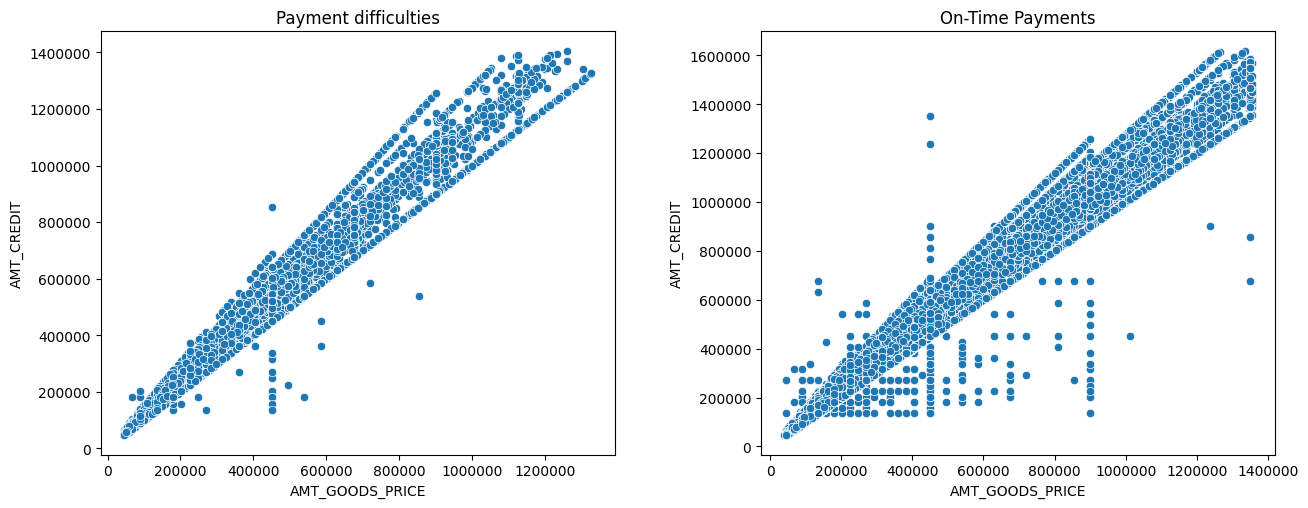

In [601]:
plt.figure(figsize = (14, 6))

plt.subplot(1,2,1)
plt.title('Payment difficulties')
sns.scatterplot(x = df1[df1['AMT_GOODS_PRICE'] < max_value1_AMT_GOODS_PRICE].AMT_GOODS_PRICE,
                y = df1[df1['AMT_CREDIT'] < max_value1_AMT_CREDIT].AMT_CREDIT, data = df1)
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')

plt.subplot(1,2,2)
plt.title('On-Time Payments')
sns.scatterplot(x = df0[df0['AMT_GOODS_PRICE'] < max_value0_AMT_GOODS_PRICE].AMT_GOODS_PRICE,
                y = df0[df0['AMT_CREDIT'] < max_value0_AMT_CREDIT].AMT_CREDIT, data = df0)
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')

plt.tight_layout(pad = 4)
plt.show()

**Спостереження**
- AMT_GOODS_PRICE та AMT_CREDIT мають сильну позитивну кореляцію. Це означає, що зі збільшенням ціни товару зростає і сума кредиту

# ДЗ 6. Кореляційний аналіз для пари числових змінних

Проведіть подібний до прикладу кореляційний аналіз для пари чслових змінних:

- AMT_ANNUITY i AMT_CREDIT;
- DAYS_EMPLOYED i AMT_INCOME_TOTAL;
- AMT_CREDIT i DAYS_BIRTH.

 Для цього винесіть функціонал аналізу у функцію та викличіть функцію для кожної двійки змінних.

 Зробіть висновок про наявність кореляції між змінними.

## Функція для автоматизованого кореляційного аналізу для пари числових змінних

In [602]:
# Універсальна функція для аналізу

def analyze_and_plot(df_group1, df_group0, column_x, column_y, group1_label="Group 1", group0_label="Group 0"):
    # Пошук викидів для кожної групи та змінної
    max_value1_x = outlier_range(df_group1, column_x)
    max_value1_y = outlier_range(df_group1, column_y)

    max_value0_x = outlier_range(df_group0, column_x)
    max_value0_y = outlier_range(df_group0, column_y)

# Побудова діаграм розсіювання
    plt.figure(figsize=(14, 6))

    # Діаграма для групи 1
    plt.subplot(1, 2, 1)
    plt.title(group1_label)
    sns.scatterplot(
        x=df_group1[df_group1[column_x] < max_value1_x][column_x],
        y=df_group1[df_group1[column_y] < max_value1_y][column_y]
    )
    plt.ticklabel_format(style='plain', axis='x')
    plt.ticklabel_format(style='plain', axis='y')

    # Діаграма для групи 2
    plt.subplot(1, 2, 2)
    plt.title(group0_label)
    sns.scatterplot(
        x=df_group0[df_group0[column_x] < max_value0_x][column_x],
        y=df_group0[df_group0[column_y] < max_value0_y][column_y]
    )
    plt.ticklabel_format(style='plain', axis='x')
    plt.ticklabel_format(style='plain', axis='y')

    plt.tight_layout(pad=4)
    plt.show()


### Аналіз стовпців AMT_ANNUITY i AMT_CREDIT



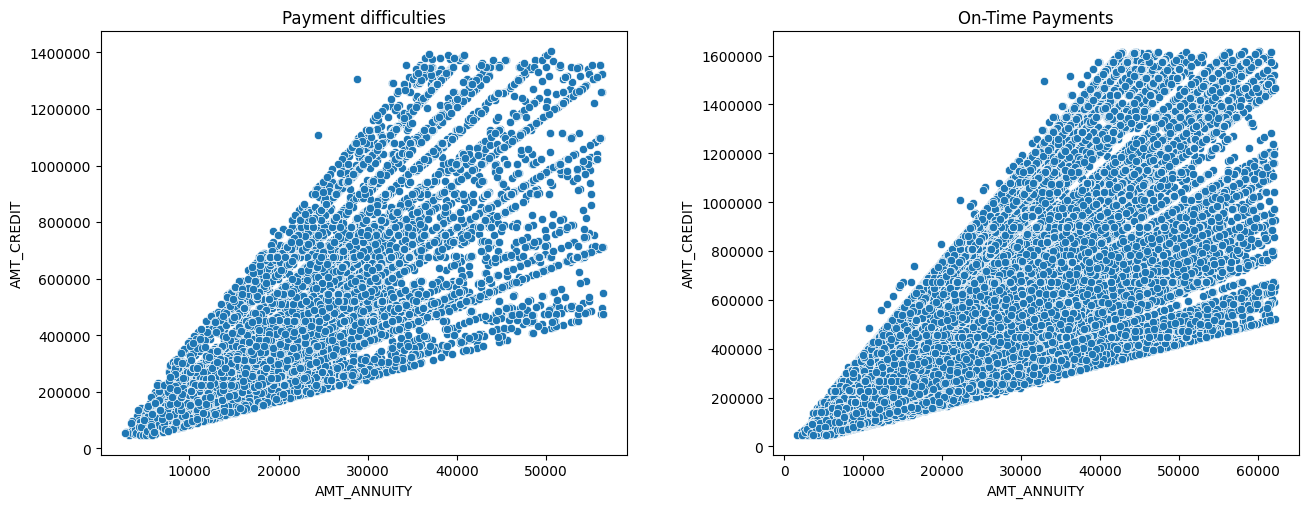

In [603]:
analyze_and_plot(df1, df0, 'AMT_ANNUITY', 'AMT_CREDIT', "Payment difficulties", "On-Time Payments")

**Спостереження**
- AMT_ANNUITY та AMT_CREDIT мають сильну позитивну кореляцію. Це означає, що чим більший щомісячний платіж, тим вища сума кредиту.

### Аналіз стовпців DAYS_EMPLOYED i AMT_INCOME_TOTAL

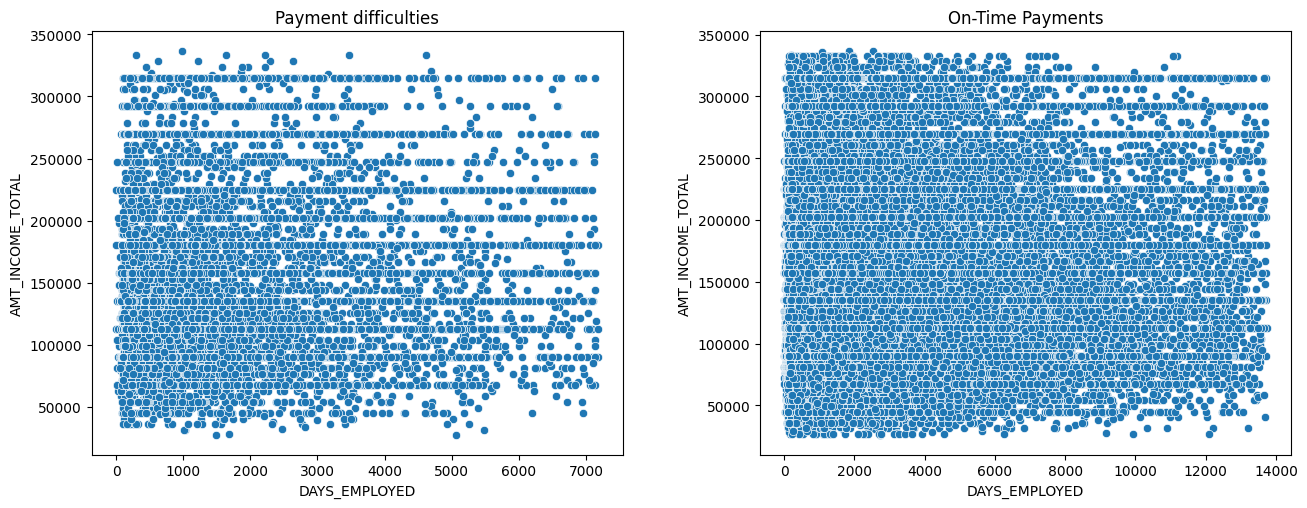

In [604]:
analyze_and_plot(df1, df0, 'DAYS_EMPLOYED', 'AMT_INCOME_TOTAL', "Payment difficulties", "On-Time Payments")

**Спостереження**
- Кореляція між DAYS_EMPLOYED та AMT_INCOME_TOTAL відсутня або близька до 0.

до речі, група з вчасними платежами має ширший діапазон значень DAYS_EMPLOYED, що може свідчити про те, що більший досвід роботи пов'язаний із здатністю вчасно сплачувати кредити.

### Аналіз стовпців AMT_CREDIT i DAYS_BIRTH

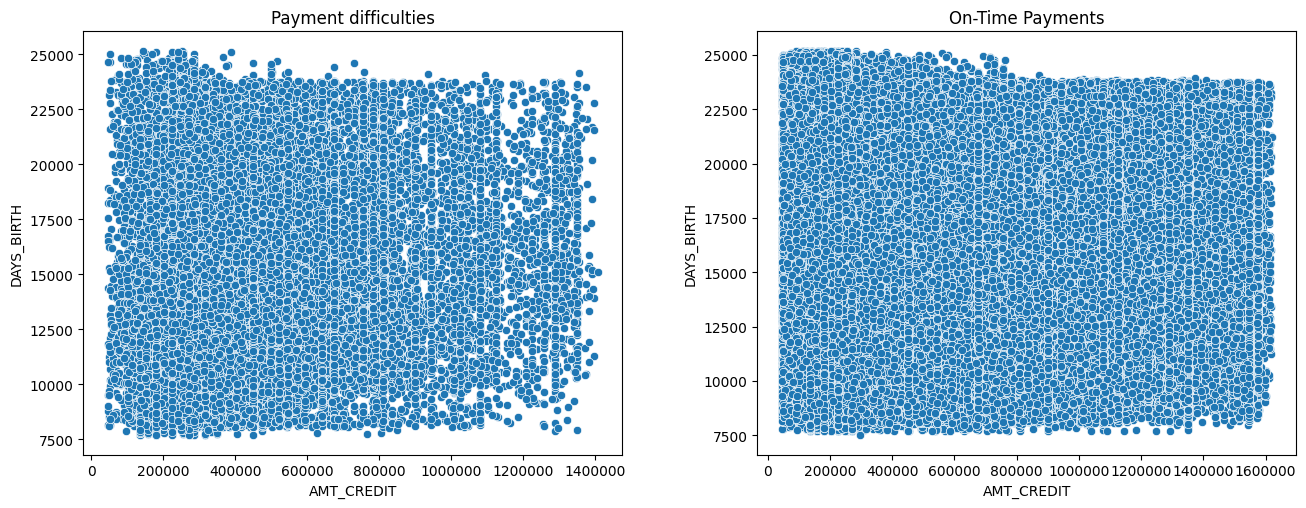

In [605]:
analyze_and_plot(df1, df0, 'AMT_CREDIT', 'DAYS_BIRTH', "Payment difficulties", "On-Time Payments")

**Спостереження**
- Кореляція між AMT_CREDIT та DAYS_BIRTH відсутня або близька до 0.

## Неперервні та категоріальні змінні

In [606]:
def draw_boxplot(df, categorical, continuous, max_continuous, title, hue_column, subplot_position):
    """
    Малює блок-діаграму для заданого DataFrame, категоріальної та неперервної змінної.
    """
    plt.subplot(1, 2, subplot_position)
    plt.title(title)
    red_diamond = dict(markerfacecolor='r', marker='D')
    sns.boxplot(x=categorical,
                y=df[df[continuous] < max_continuous][continuous],
                data=df,
                flierprops=red_diamond,
                order=sorted(df[categorical].unique(), reverse=True),
                hue=hue_column, hue_order=sorted(df[hue_column].unique(), reverse=True))
    plt.ticklabel_format(style='plain', axis='y')
    plt.xticks(rotation=90)

def bi_boxplot(categorical, continuous, max_continuous1, max_continuous0, hue_column):
    """
    Створює паралельні блок-діаграми для двох груп, визначених у наборі даних, на основі
    категоріальної та неперервної змінної, виділяючи відмінності за допомогою відтінків.
    """
    plt.figure(figsize=(14, 7))

    # Графік для першо групи "Труднощі з платежами" (Payment Difficulties)
    draw_boxplot(df1, categorical, continuous, max_continuous1, 'Payment Difficulties', hue_column, 1)

    # Графік для другої групи "Вчасні оплати" (On-Time Payments)
    draw_boxplot(df0, categorical, continuous, max_continuous0, 'On-Time Payments', hue_column, 2)

    plt.tight_layout(pad=4)
    plt.show()

### Аналіз стовпців `AMT_CREDIT` vs `NAME_EDUCATION_TYPE` vs `CODE_GENDER`

**Пошук викидів для `AMT_CREDIT `для групи із платіжними труднощами**

In [607]:
max_value1_AMT_CREDIT = outlier_range(df1,'AMT_CREDIT')
max_value1_AMT_CREDIT

1406688.75

**Пошук викидів для `AMT_CREDIT ` для групи із вчасними платежами**

In [608]:
max_value0_AMT_CREDIT = outlier_range(df0,'AMT_CREDIT')
max_value0_AMT_CREDIT

1620000.0

**Клієнт з платіжними труднощами**

In [609]:
df1.groupby(by = ['NAME_EDUCATION_TYPE','CODE_GENDER']).AMT_CREDIT.describe().head()

count      mean       std       min  \
NAME_EDUCATION_TYPE CODE_GENDER                                         
Academic degree     F              3.00 950245.50 504711.38 544491.00   
Higher education    F           2438.00 648500.58 410415.70  47970.00   
                    M           1571.00 642070.94 409695.93  45000.00   
Incomplete higher   F            504.00 520150.35 352227.49  91692.00   
                    M            368.00 554723.82 347843.71  74628.00   

                                      25%       50%        75%        max  
NAME_EDUCATION_TYPE CODE_GENDER                                            
Academic degree     F           667660.50 790830.00 1153122.75 1515415.50  
Higher education    F           323595.00 545040.00  877500.00 2687355.00  
                    M           329202.00 545040.00  832797.00 2695500.00  
Incomplete higher   F           269550.00 450000.00  675000.00 2695500.00  
                    M           284400.00 497520.00  699976.12 2013840.00

**Клієнт зі вчасними платежами**

In [610]:
df0.groupby(by = ['NAME_EDUCATION_TYPE','CODE_GENDER']).AMT_CREDIT.describe().head()

count      mean       std       min  \
NAME_EDUCATION_TYPE CODE_GENDER                                          
Academic degree     F              97.00 708770.74 463052.42 130824.00   
                    M              64.00 735235.38 497739.97  74182.50   
Higher education    F           47852.00 682485.00 456642.78  45000.00   
                    M           23002.00 713144.54 486073.66  45000.00   
Incomplete higher   F            5780.00 555340.53 385980.60  45000.00   

                                      25%       50%        75%        max  
NAME_EDUCATION_TYPE CODE_GENDER                                            
Academic degree     F           354469.50 607500.00 1006920.00 2463840.00  
                    M           309519.00 610056.00 1036890.00 1984500.00  
Higher education    F           302206.50 568057.50  916470.00 4050000.00  
                    M           315000.00 592560.00  973503.00 4050000.00  
Incomplete higher   F           253737.00 454500.00  760225.50 2517300.00

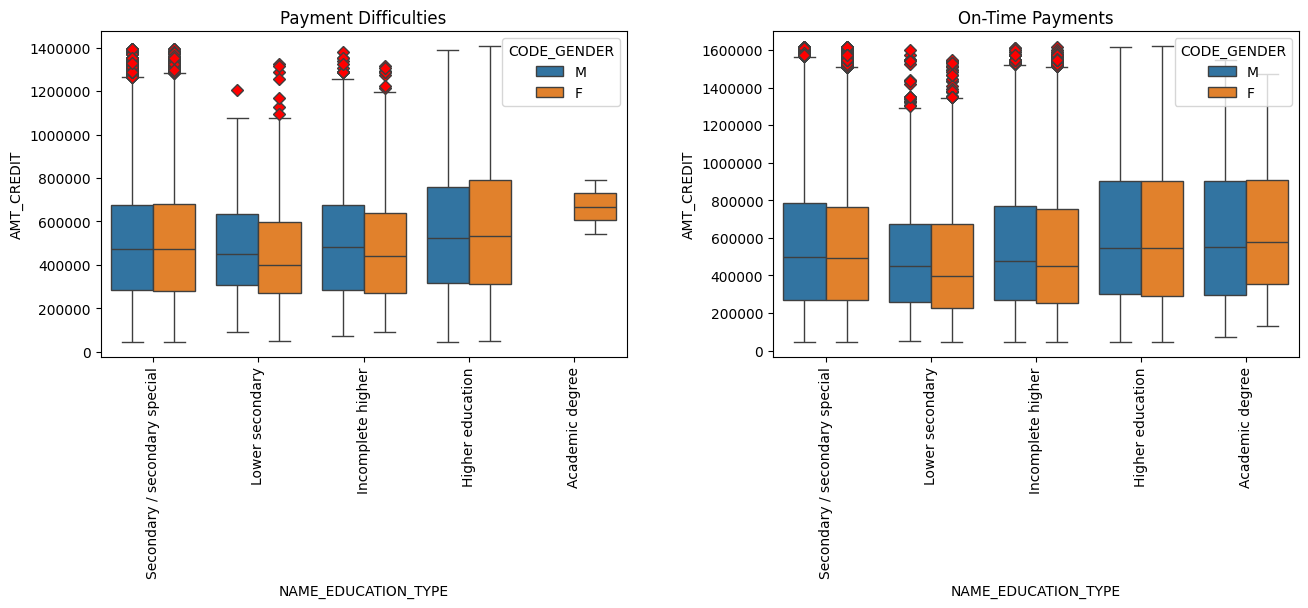

In [611]:
bi_boxplot('NAME_EDUCATION_TYPE','AMT_CREDIT',max_value1_AMT_CREDIT, max_value0_AMT_CREDIT, 'CODE_GENDER')

**Спостереження**
- Клієнти з "академічним ступенем" мають широкий діапазон кредитів для своєчасних платежів, тоді як для клієнтів з проблемами з оплатою цей діапазон значно нижчий
- Якщо поглянути на зведену статистику, то клієнти з "вищою освітою" та проблемами з оплатою беруть середній та медіанний кредит у значно більшому діапазоні, ніж клієнти з вчасною оплатою.
- Клієнти-чоловіки з "вищою освітою" завжди сплачують кредит вчасно

 # ДЗ 7. Кореляційний аналіз між двома категоріальними змінними та числовою

 Проведіть аналогічний кореляційний аналіз для трійок змінних:

 - AMT_INCOME_TOTAL vs. NAME_FAMILY_STATUS vs. CODE_GENDER;
 - AMT_INCOME_TOTAL vs. YEARTH_BIRTH_CATEGORY vs. NAME_HOUSING_TYPE;
 - AMT_GOODS_PRICE vs. NAME_INCOME_TYPE vs. CODE_GENDER;
 - AMT_INCOME_TOTAL vs. OCCUPATION_TYPE vs. CODE_GENDER.

 Можете також проаналізувати додатково свою трійку.

 Для цього винесіть функціонал аналізу у функцію та викличіть функцію для кожної трійки змінних.

 Зробіть висновок про наявність кореляції між змінними.

## Функція для автоматизованого кореляційного аналізу між двома категоріальними змінними та числовою

In [612]:
def analyze_columns(df1, df0, categorical, continuous, hue_column):
    """
    Створює аналіз заданих колонок та відображає результати.
    """
    # Пошук викидів
    max_continuous1 = outlier_range(df1, continuous)
    max_continuous0 = outlier_range(df0, continuous)

    print(f"Максимальне значення без викидів для групи 'Payment Difficulties' ({continuous}): {max_continuous1}")
    print(f"Максимальне значення без викидів для групи 'On-Time Payments' ({continuous}): {max_continuous0}")

    # Групування даних для описової статистики
    print("\nКлієнт з платіжними труднощами:")
    print(df1.groupby(by=[categorical, hue_column])[continuous].describe().head())

    print("\nКлієнт зі вчасними платежами:")
    print(df0.groupby(by=[categorical, hue_column])[continuous].describe().head())

    # Побудова блок-діаграм
    plt.figure(figsize=(14, 6))

    draw_boxplot(df1, categorical, continuous, max_continuous1, 'Payment Difficulties', hue_column, 1)
    draw_boxplot(df0, categorical, continuous, max_continuous0, 'On-Time Payments', hue_column, 2)

    plt.tight_layout(pad=4)
    plt.show()


## Аналіз стовпців AMT_INCOME_TOTAL vs. NAME_FAMILY_STATUS vs. CODE_GENDER

Максимальне значення без викидів для групи 'Payment Difficulties' (AMT_INCOME_TOTAL): 337500.0
Максимальне значення без викидів для групи 'On-Time Payments' (AMT_INCOME_TOTAL): 337500.0

Клієнт з платіжними труднощами:
                                 count      mean        std      min  \
NAME_FAMILY_STATUS CODE_GENDER                                         
Civil marriage     F           1753.00 153620.72  101045.86 25650.00   
                   M           1208.00 173949.99   92449.17 36000.00   
Married            F           8324.00 159907.85 1283283.40 27000.00   
                   M           6526.00 182233.06   94787.77 31500.00   
Separated          F           1045.00 161159.55   82633.33 36000.00   

                                     25%       50%       75%          max  
NAME_FAMILY_STATUS CODE_GENDER                                             
Civil marriage     F           108000.00 135000.00 180000.00   3150000.00  
                   M           117000.00 157500.

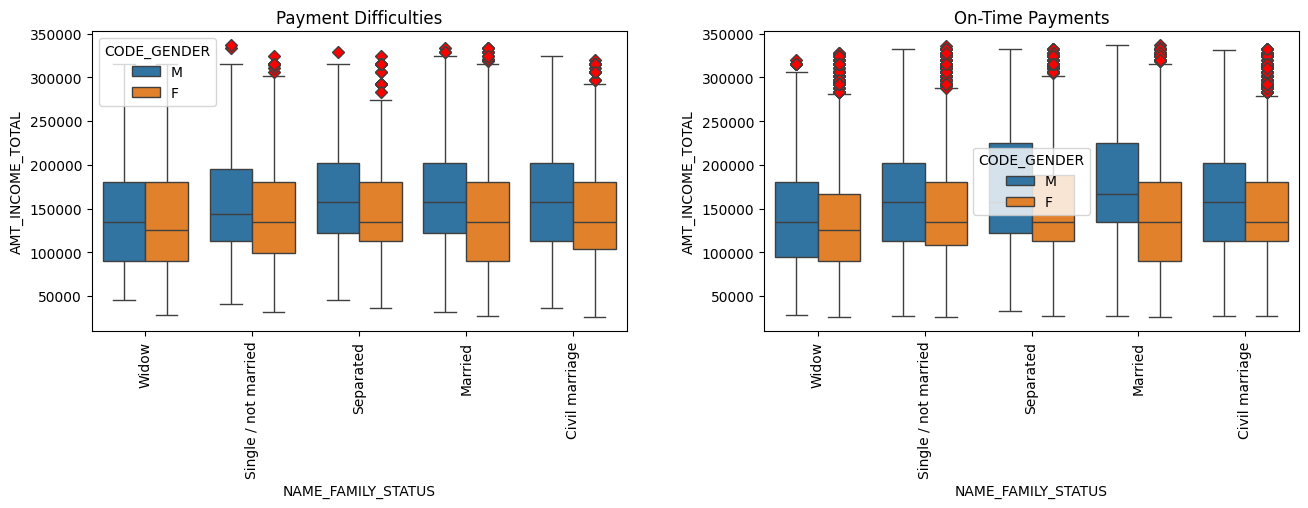

In [613]:
analyze_columns(df1, df0, 'NAME_FAMILY_STATUS', 'AMT_INCOME_TOTAL', 'CODE_GENDER')

**Спостереження**

- Прибуток клієнтів, які мають труднощі з оплатою кредитів, не перевищує 200тис., тоді як клієнти, що виплачують кредити вчасно мають ширший діапазоене значень.
- майже у всіх категоріях(окрім, вдівців з труднощами у виплаті кредитів - там однаково), чоловіки мають більший приюбуток, ніж жінки
- у групі вчасних виплатів кредитів, лише жінки та вдівці мають певні відхилення від норми, тоді як всі клієнти з труднощами з виплатами мають певні відхилення.

## Аналіз стовпців AMT_INCOME_TOTAL vs. YEARS_BIRTH_CATEGORY vs. NAME_HOUSING_TYPE

Максимальне значення без викидів для групи 'Payment Difficulties' (AMT_INCOME_TOTAL): 337500.0
Максимальне значення без викидів для групи 'On-Time Payments' (AMT_INCOME_TOTAL): 337500.0

Клієнт з платіжними труднощами:
                                           count      mean      std      min  \
YEARS_BIRTH_CATEGORY NAME_HOUSING_TYPE                                         
20-30                Co-op apartment       40.00 148628.70 59516.24 67500.00   
                     House / apartment   4201.00 151897.22 70874.65 31500.00   
                     Municipal apartment  153.00 153608.82 78282.79 45000.00   
                     Office apartment      40.00 147375.00 50817.26 67500.00   
                     Rented apartment     229.00 144210.10 59998.66 45000.00   

                                               25%       50%       75%  \
YEARS_BIRTH_CATEGORY NAME_HOUSING_TYPE                                   
20-30                Co-op apartment     110250.00 135000.00 185625.00  

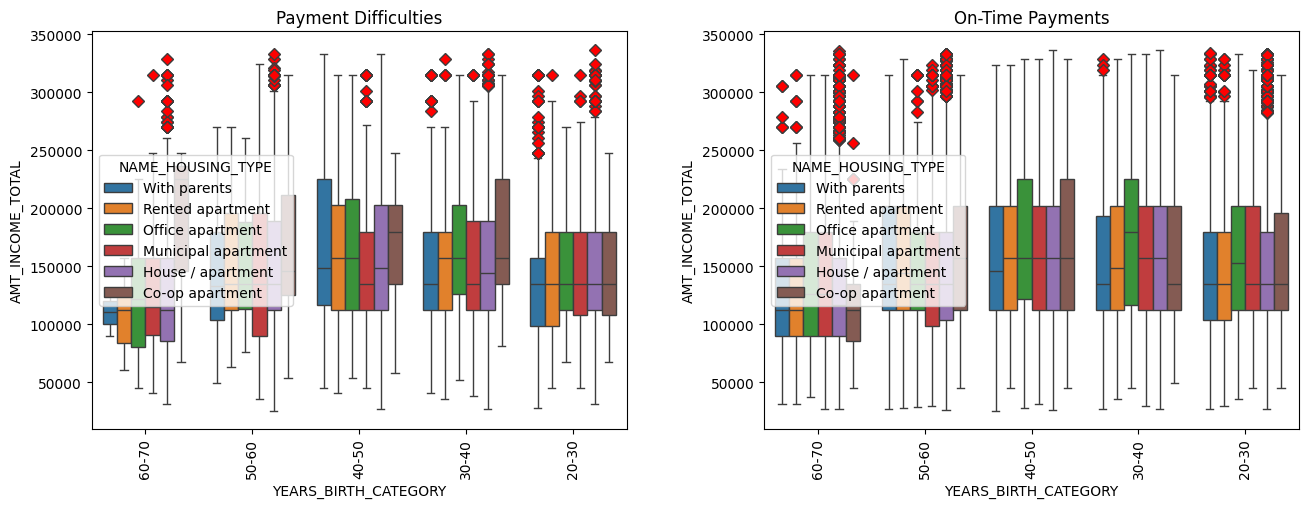

In [614]:
analyze_columns(df1, df0, 'YEARS_BIRTH_CATEGORY', 'AMT_INCOME_TOTAL', 'NAME_HOUSING_TYPE')

**Спостереження**
- Молоді клієнти(20-30 років) з офісною, муніципалітетною чи кооперативною квартирою, які мають труднощі з виплатою кредитів, мають нижчий дохід, ніж ті, хто виплачують вчасно.
- Доросла вікова категорія клінтів(60-70 років), яка ивплачує кредити вчасно, для всіх типів житла,окрім кооперативного, має значно більший діапазон значень прибутку, ніж з виплатними проблемами.
- Клієнти від 50 до 60 років, які орендують житло, живуть з батьками або ж мають офіс, та знаходяться в категорії з проблемами з виплатою кредитів, мають менший діапазон значень прибутку, ніж клієнти з тією ж власністю, які виплачують кредит вчасно.

## Аналіз стовпців AMT_GOODS_PRICE vs. NAME_INCOME_TYPE vs. CODE_GENDER

Максимальне значення без викидів для групи 'Payment Difficulties' (AMT_GOODS_PRICE): 1329750.0
Максимальне значення без викидів для групи 'On-Time Payments' (AMT_GOODS_PRICE): 1354755.9375

Клієнт з платіжними труднощами:
                                   count      mean       std       min  \
NAME_INCOME_TYPE     CODE_GENDER                                         
Commercial associate F           2968.00 536304.02 353598.52  45000.00   
                     M           2392.00 526355.38 335793.33  45000.00   
Maternity leave      F              2.00 929250.00 715945.62 423000.00   
Pensioner            F           2243.00 494976.12 316903.86  45000.00   
                     M            739.00 486543.08 321104.43  45000.00   

                                       25%       50%        75%        max  
NAME_INCOME_TYPE     CODE_GENDER                                            
Commercial associate F           270000.00 450000.00  675000.00 3600000.00  
                     M      

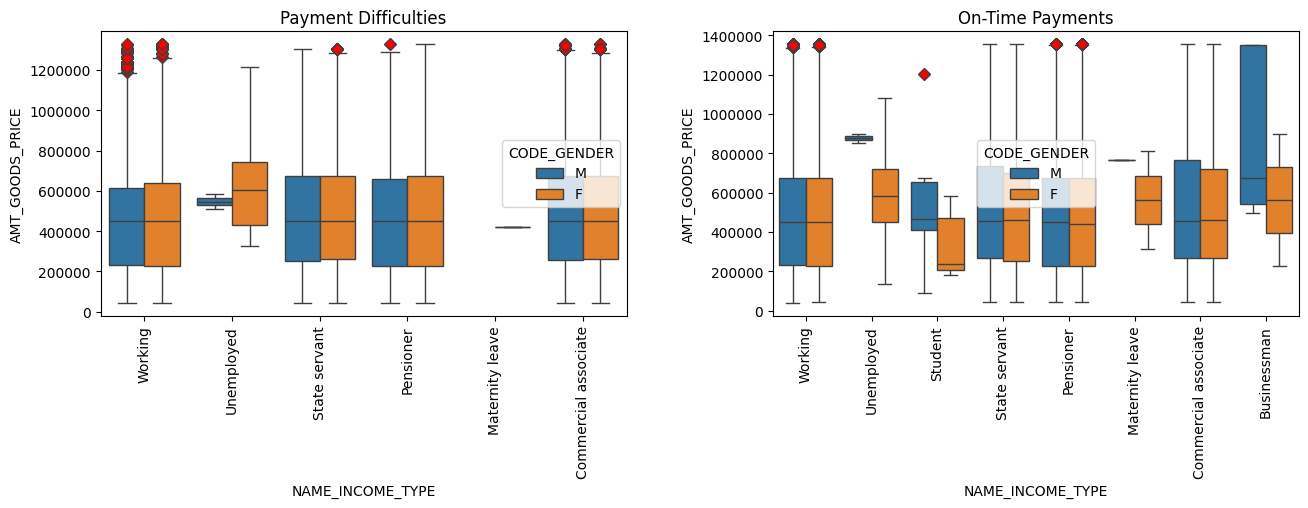

In [615]:
analyze_columns(df1, df0, 'NAME_INCOME_TYPE', 'AMT_GOODS_PRICE', 'CODE_GENDER')

**Спостереження**

- Чоловіки-бізнесмени, які не мають проблем з виплатою кредитів, мають значну більшу варіативність у ціні, на що вони беруть кредит, ніж ті, хто мають проблеми з виплатами.
- Середня сума, яку беруть чоловіки з проблемами у виплаті кредиту, значно нижча, ніж у тих, хто виплачує кредит вчасно.
- Чоловіків, які знаходяться в дикретній відпустці, та мають проблеми з виплатою кредитів, немає. Тоді як варіативність жінок вдикретній відпустці, що виплачують кредит вчасно, набаагто вища, ніж тих, хто має проблеми з виплатами.

## Аналіз стовпців AMT_INCOME_TOTAL vs. OCCUPATION_TYPE vs. CODE_GENDER

Максимальне значення без викидів для групи 'Payment Difficulties' (AMT_INCOME_TOTAL): 337500.0
Максимальне значення без викидів для групи 'On-Time Payments' (AMT_INCOME_TOTAL): 337500.0

Клієнт з платіжними труднощами:
                             count      mean      std      min       25%  \
OCCUPATION_TYPE CODE_GENDER                                                
Accountants     F           457.00 174840.64 79021.04 54000.00 112500.00   
                M            17.00 202367.65 98623.66 81000.00 121500.00   
Cleaning staff  F           410.00 128907.99 70328.23 31500.00  90000.00   
                M            37.00 119493.24 45786.21 45000.00  90000.00   
Cooking staff   F           555.00 129298.38 55531.88 32400.00  90000.00   

                                  50%       75%       max  
OCCUPATION_TYPE CODE_GENDER                                
Accountants     F           157500.00 202500.00 540000.00  
                M           180000.00 252000.00 438750.00  
Cleaning

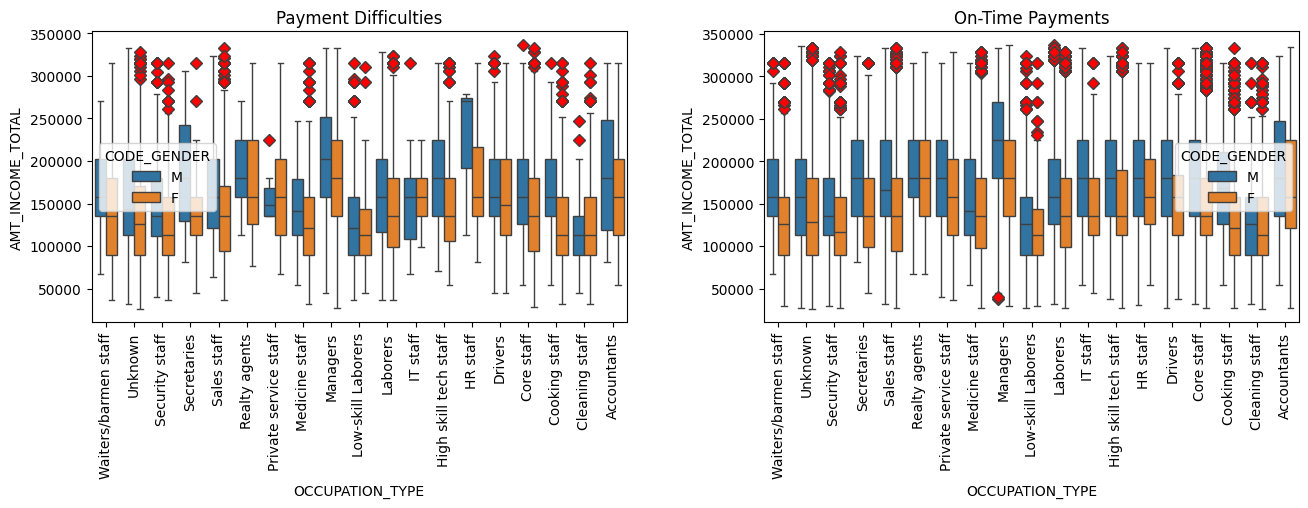

In [616]:
analyze_columns(df1, df0, 'OCCUPATION_TYPE', 'AMT_INCOME_TOTAL', 'CODE_GENDER')

**Спостереження**

- Private service staff, Reality agents, Medicine staff, HR staff клієнти, які виплачують кредити вчасно, мають значно більший діапазон значень прибутку, ніж ті, хто мають проблеми з кредитами.
- Secretaries, Managers, HR staff, Accountaints мають велику варіантивність в доході в обох групах.


## Категоріальні та категоріальні змінні

### Аналіз стовпців `NAME_INCOME_TYPE` vs `CODE_GENDER`

In [617]:
def bi_countplot_target(df0, df1, column, hue_column):
    group_name = f'Нормалізований розподіл значень за категорією: {column}'
    print(group_name.upper())

    pltname = 'Клієнт зі складнощями щодо платності'
    unique_hue_values = df1[hue_column].unique()
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(14,4)

    proportions = df1.groupby(hue_column)[column].value_counts(normalize=True)
    proportions = (proportions*100).round(2)
    ax = proportions.unstack(hue_column).sort_values(
      by=unique_hue_values[0], ascending=False
      ).plot.bar(ax=axes[0], title=pltname)

    # анотація значень в барплоті
    for container in ax.containers:
      ax.bar_label(container, fmt='{:,.1f}%')

    pltname = 'Клієнти зі своєчасними платежами'
    unique_hue_values = df0[hue_column].unique()

    proportions = df0.groupby(hue_column)[column].value_counts (normalize=True)
    proportions = (proportions*100).round(2)
    ax = proportions.unstack(hue_column).sort_values(
    by=unique_hue_values[0], ascending=False
      ).plot.bar(ax=axes[1], title=pltname)

    for container in ax.containers:
      ax.bar_label(container, fmt='{:,.1f}%')

    plt.show()


    #------------
    group_name = f'Кількість значень за категорією {column}'
    print(group_name.upper())

    pltname = 'Клієнт зі своєчасними платежами'
    unique_hue_values = df1[hue_column].unique()
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(14,4)
    counts = df1.groupby(hue_column)[column].value_counts()
    ax = counts.unstack(hue_column).sort_values(
      by=unique_hue_values [0], ascending=False
      ).plot.bar(ax=axes [0], title=pltname )

    for container in ax.containers:
      ax.bar_label(container)

    pltname = 'Клієнти зі своєчасними платежами'
    unique_hue_values = df0[hue_column].unique()
    counts = df0.groupby(hue_column)[column].value_counts()
    ax = counts.unstack(hue_column).sort_values (
      by=unique_hue_values[0], ascending=False
      ).plot.bar(ax=axes[1], title=pltname)

    for container in ax. containers:
      ax.bar_label(container)

    plt.show()

НОРМАЛІЗОВАНИЙ РОЗПОДІЛ ЗНАЧЕНЬ ЗА КАТЕГОРІЄЮ: NAME_INCOME_TYPE


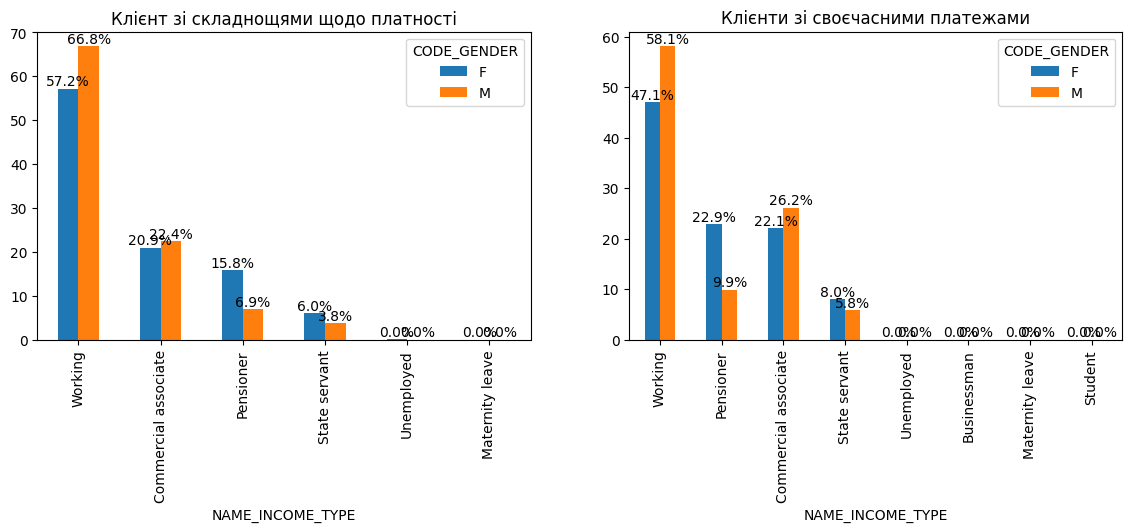

КІЛЬКІСТЬ ЗНАЧЕНЬ ЗА КАТЕГОРІЄЮ NAME_INCOME_TYPE


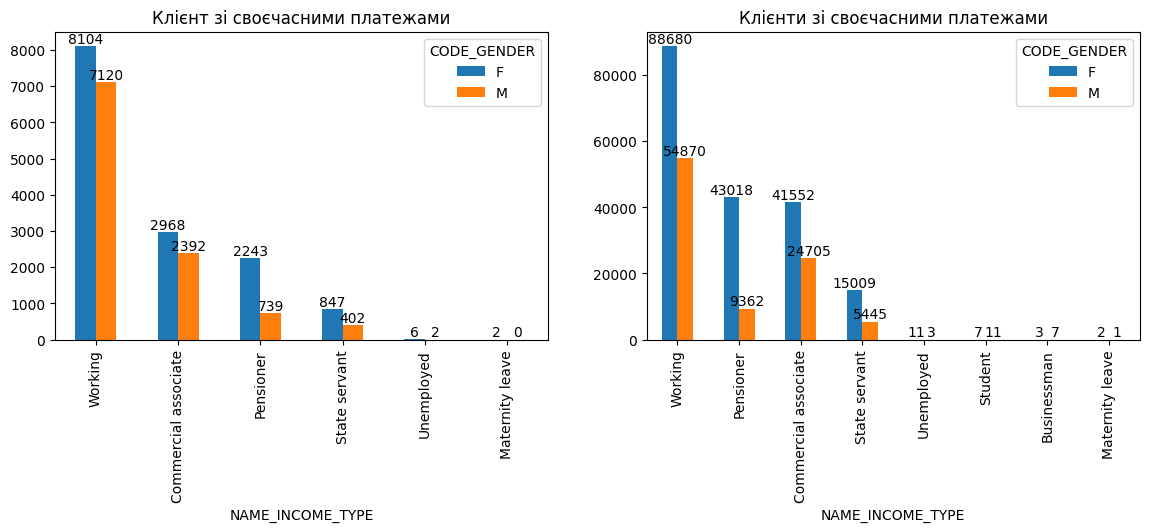

In [618]:
bi_countplot_target(df0, df1, 'NAME_INCOME_TYPE','CODE_GENDER')

**Спостереження**
- Клієнти категорії `Working` та `Male` мають більше труднощів з оплатою порівняно з тими, хто платить вчасно
- Клієнти категорії `Pensioner` та `Female` мають більше труднощів з оплатою порівняно з тими, хто платить вчасно
- Клієнти категорії `Businessman` та `Student` здійснюють платежі вчасно, хоча їхня історія невелика

# ДЗ 8. Аналіз взаємозалежностей між двома категоріальними змінними.

Проведіть подібний до прикладу аналіз залежностей між категоріальних змінними для пар змінних.

- NAME_EDUCATION_TYPE vs. CODE_GENDER;
- NAME_FAMILY_STATUS vs. OCCUPATION_TYPE;
- OCCUPATION_TYPE vs. NAME_CONTARCT_TYPE.

Опишіть спостередження щодо того, чи є цікаві знахідки стосовно цільової змінної з цього аналізу.


# Аналіз стовпців NAME_EDUCATION_TYPE vs. CODE_GENDER

НОРМАЛІЗОВАНИЙ РОЗПОДІЛ ЗНАЧЕНЬ ЗА КАТЕГОРІЄЮ: NAME_EDUCATION_TYPE


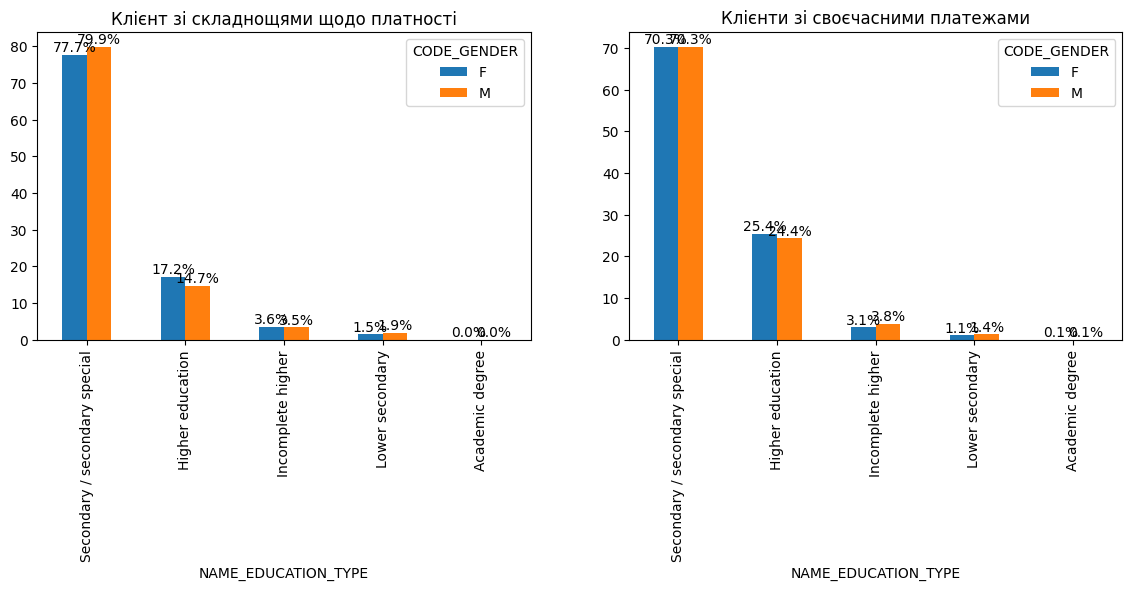

КІЛЬКІСТЬ ЗНАЧЕНЬ ЗА КАТЕГОРІЄЮ NAME_EDUCATION_TYPE


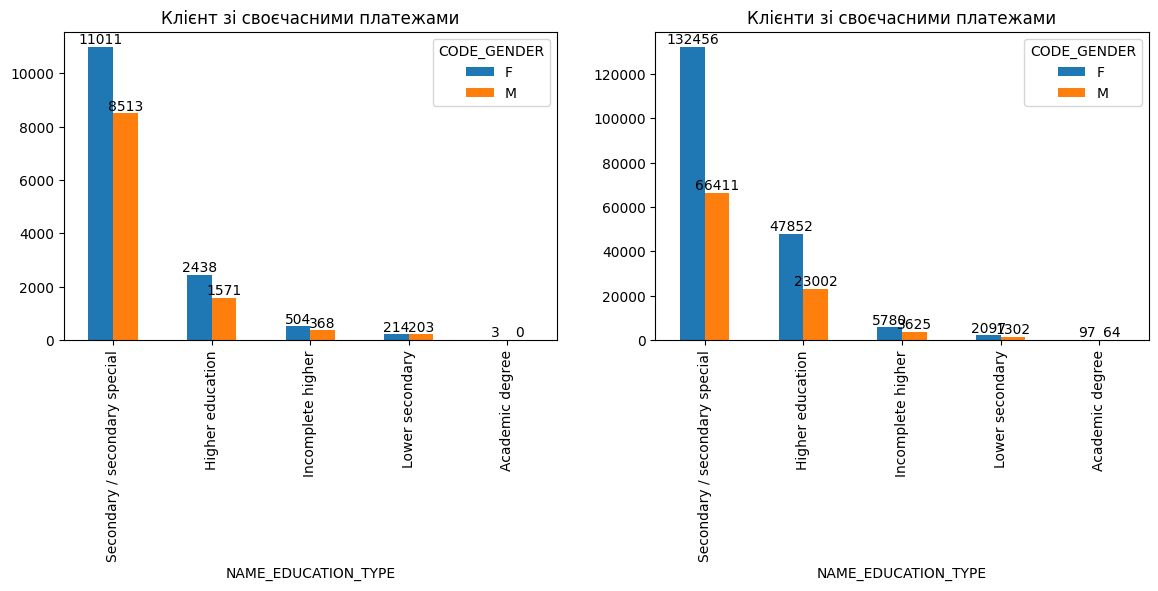

In [619]:
bi_countplot_target(df0, df1, 'NAME_EDUCATION_TYPE','CODE_GENDER')

**Спостереження**
- Усі клієнти категорії `Secondary/secondary special`,які здійснюють платежі вчасно, є пропорційно однаковими.
- Клієнтів-чоловіків в групі "сплачують кредити вчасно", які не закінчили освіту чи мають нижню середню освіту, більше, ніж жінок.
- Даних про клієнтів з `Academic degree` дуже мало, але вони рівномірно розподілені між статтями в обох групах.

# Аналіз стовпців NAME_FAMILY_STATUS vs. OCCUPATION_TYPE

НОРМАЛІЗОВАНИЙ РОЗПОДІЛ ЗНАЧЕНЬ ЗА КАТЕГОРІЄЮ: NAME_FAMILY_STATUS


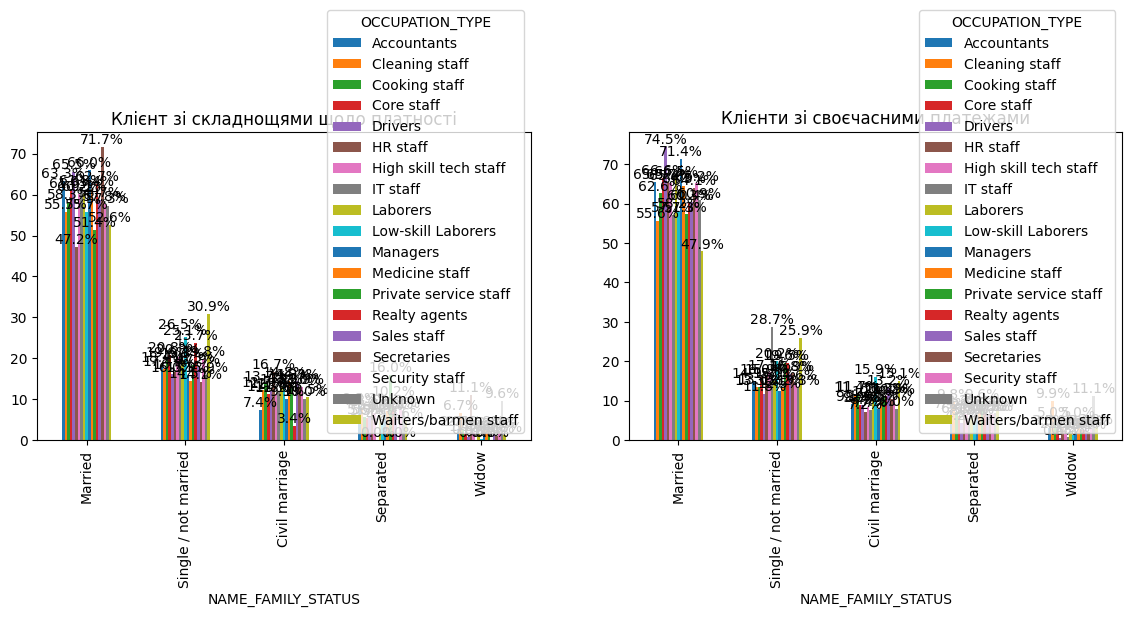

КІЛЬКІСТЬ ЗНАЧЕНЬ ЗА КАТЕГОРІЄЮ NAME_FAMILY_STATUS


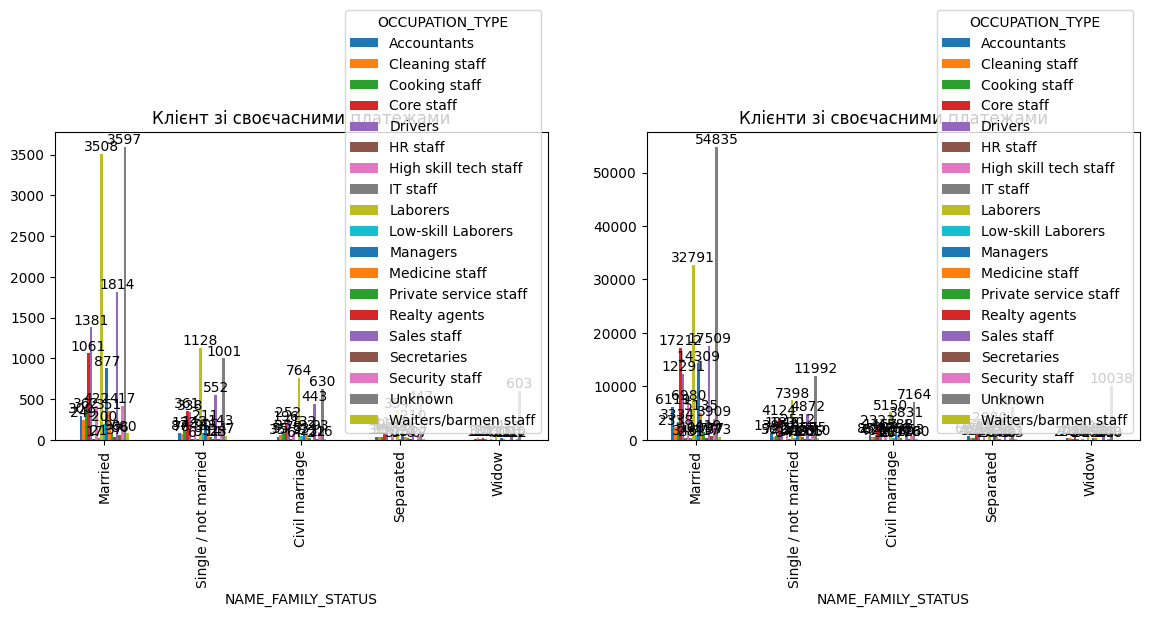

In [620]:
bi_countplot_target(df0, df1, 'NAME_FAMILY_STATUS','OCCUPATION_TYPE')

НОРМАЛІЗОВАНИЙ РОЗПОДІЛ ЗНАЧЕНЬ ЗА КАТЕГОРІЄЮ: OCCUPATION_TYPE


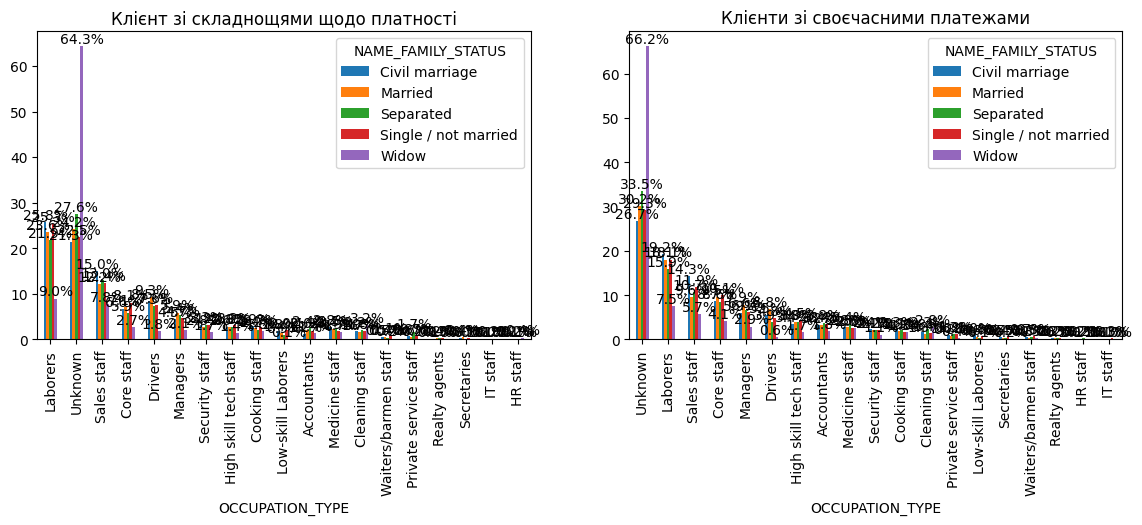

КІЛЬКІСТЬ ЗНАЧЕНЬ ЗА КАТЕГОРІЄЮ OCCUPATION_TYPE


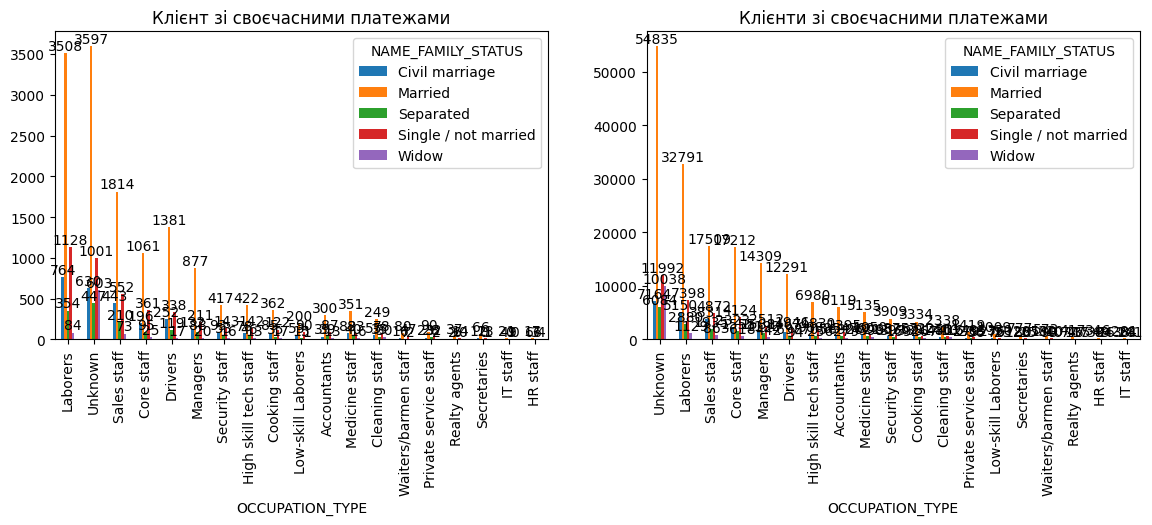

In [621]:
bi_countplot_target(df0, df1, 'OCCUPATION_TYPE','NAME_FAMILY_STATUS')

**Спостереження**
- Клієнтів у категоріях `IT staff` та `Laborers` найбільше в обох гркпах.
- Відсоток клієнтів категорії `Widow` з невідомою зайнятістю знатно ліжирує в двох групах.
- Одружених клієнтів категорії, які працюють секретарями та виплачують кредит вчасно, більше, ніж тих, хто має з цим труднощі.

# Аналіз стовпців OCCUPATION_TYPE vs. NAME_CONTARCT_TYPE

НОРМАЛІЗОВАНИЙ РОЗПОДІЛ ЗНАЧЕНЬ ЗА КАТЕГОРІЄЮ: OCCUPATION_TYPE


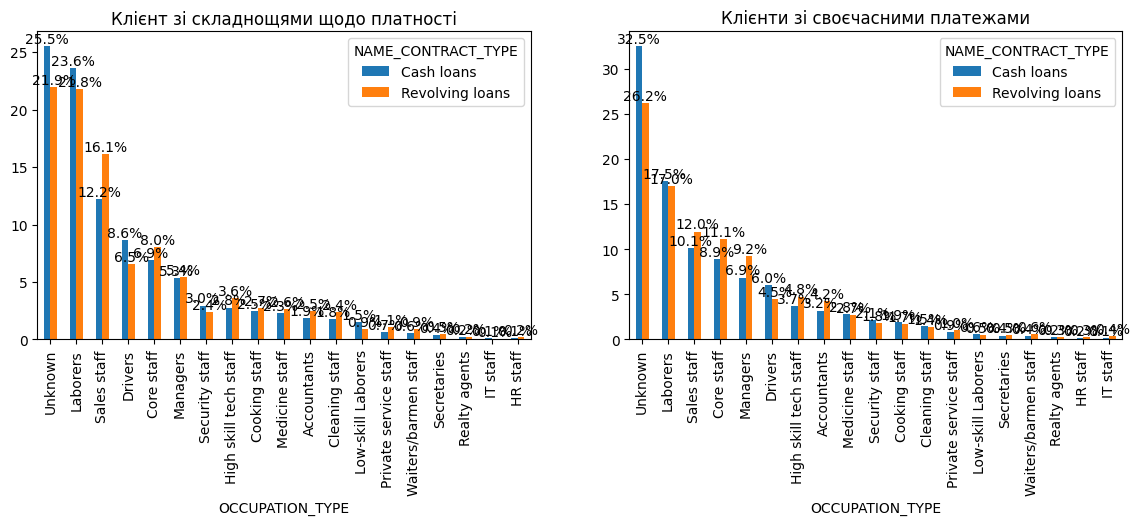

КІЛЬКІСТЬ ЗНАЧЕНЬ ЗА КАТЕГОРІЄЮ OCCUPATION_TYPE


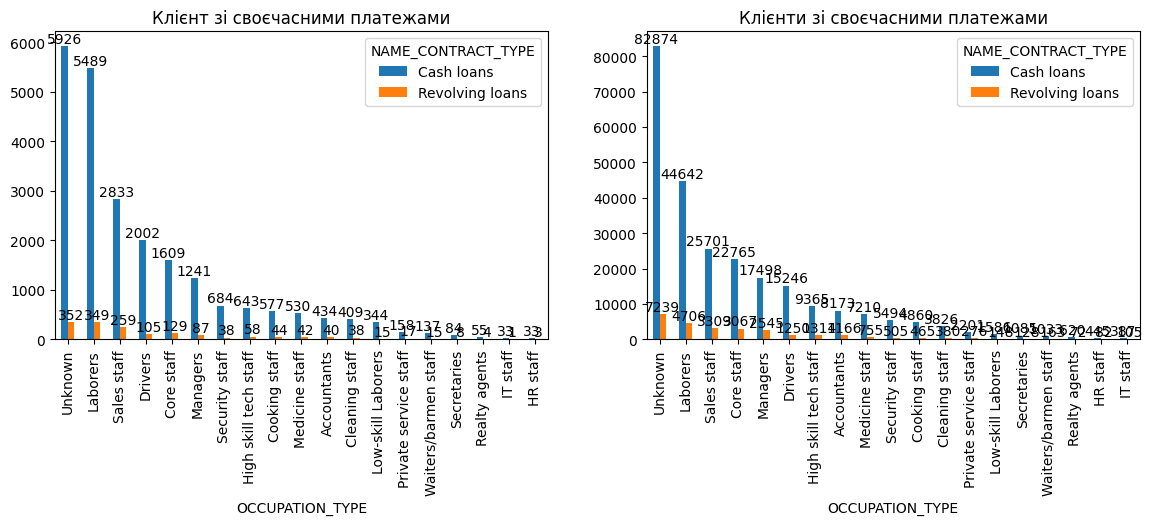

In [622]:
bi_countplot_target(df0, df1, 'OCCUPATION_TYPE','NAME_CONTRACT_TYPE')

**Спостереження**
- Клієнтів з невідомою зайнятістю які виплачують кредит вчасно, значно більше, ніж тих, хто має труднощу з виплатами кредиту.
- Клієнтsв категорії `Laborers` та `Sales staff`, які мають труднощі з виплатою кредитів з обома типами кредитних контрактів більше, ніж тих, хто виплачує борг вчасно.

# ДЗ 9. Висновок з провденого аналізу.

Напишіть ваш висновок з проведеного аналізу, яким категоріям осіб, ви б видавали кредит? Категорія може бути, наприклад, люди з такою-то освітою, з таким-то доходом, з таким-то досвідом роботи.

# Висновок: Категорія клієнтів, на яких слід орієнтуватися при наданні кредиту.

Після проведеного аналізу можна сказати, що найбільш влучними категоріями клієнтів, на які можна орієнтуватися у видачі кредитів є:
- працюючі чоловіки та жінки з середньою освітою;
- клієнти, у яких немає дітей;
- клієнти, які працюють більше 2000 днів та беруть кредити на суму від 750тис;
- клієнти з високими доходами;
- клієнти віком від 41 року